In [1]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.utils import save_image
import argparse
from PIL import Image

2024-01-12 22:04:49.106825: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 22:04:49.184689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 22:04:50.429832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
class Args:
    def __init__(self):
        self.run_name = "DDPM_conditional"
        self.epochs = 300
        self.batch_size = 14
        self.image_size = 64
        self.num_classes = 4
        self.dataset_path = r"/data/Ahsan/nomandata/brain-tumor-mri-dataset/val/Training"
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.lr = 3e-4

args = Args()

In [4]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader


In [5]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


In [8]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [9]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [10]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [11]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [12]:
net = UNet_conditional(num_classes=10, device="cpu")
print(sum([p.numel() for p in net.parameters()]))
x = torch.randn(3, 3, 64, 64)
t = x.new_tensor([500] * x.shape[0]).long()
y = x.new_tensor([1] * x.shape[0]).long()
print(net(x, t, y).shape)

23335299
torch.Size([3, 3, 64, 64])


In [13]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

In [14]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

10:04:56 - INFO: Sampling 1 new images....
999it [00:22, 44.56it/s]


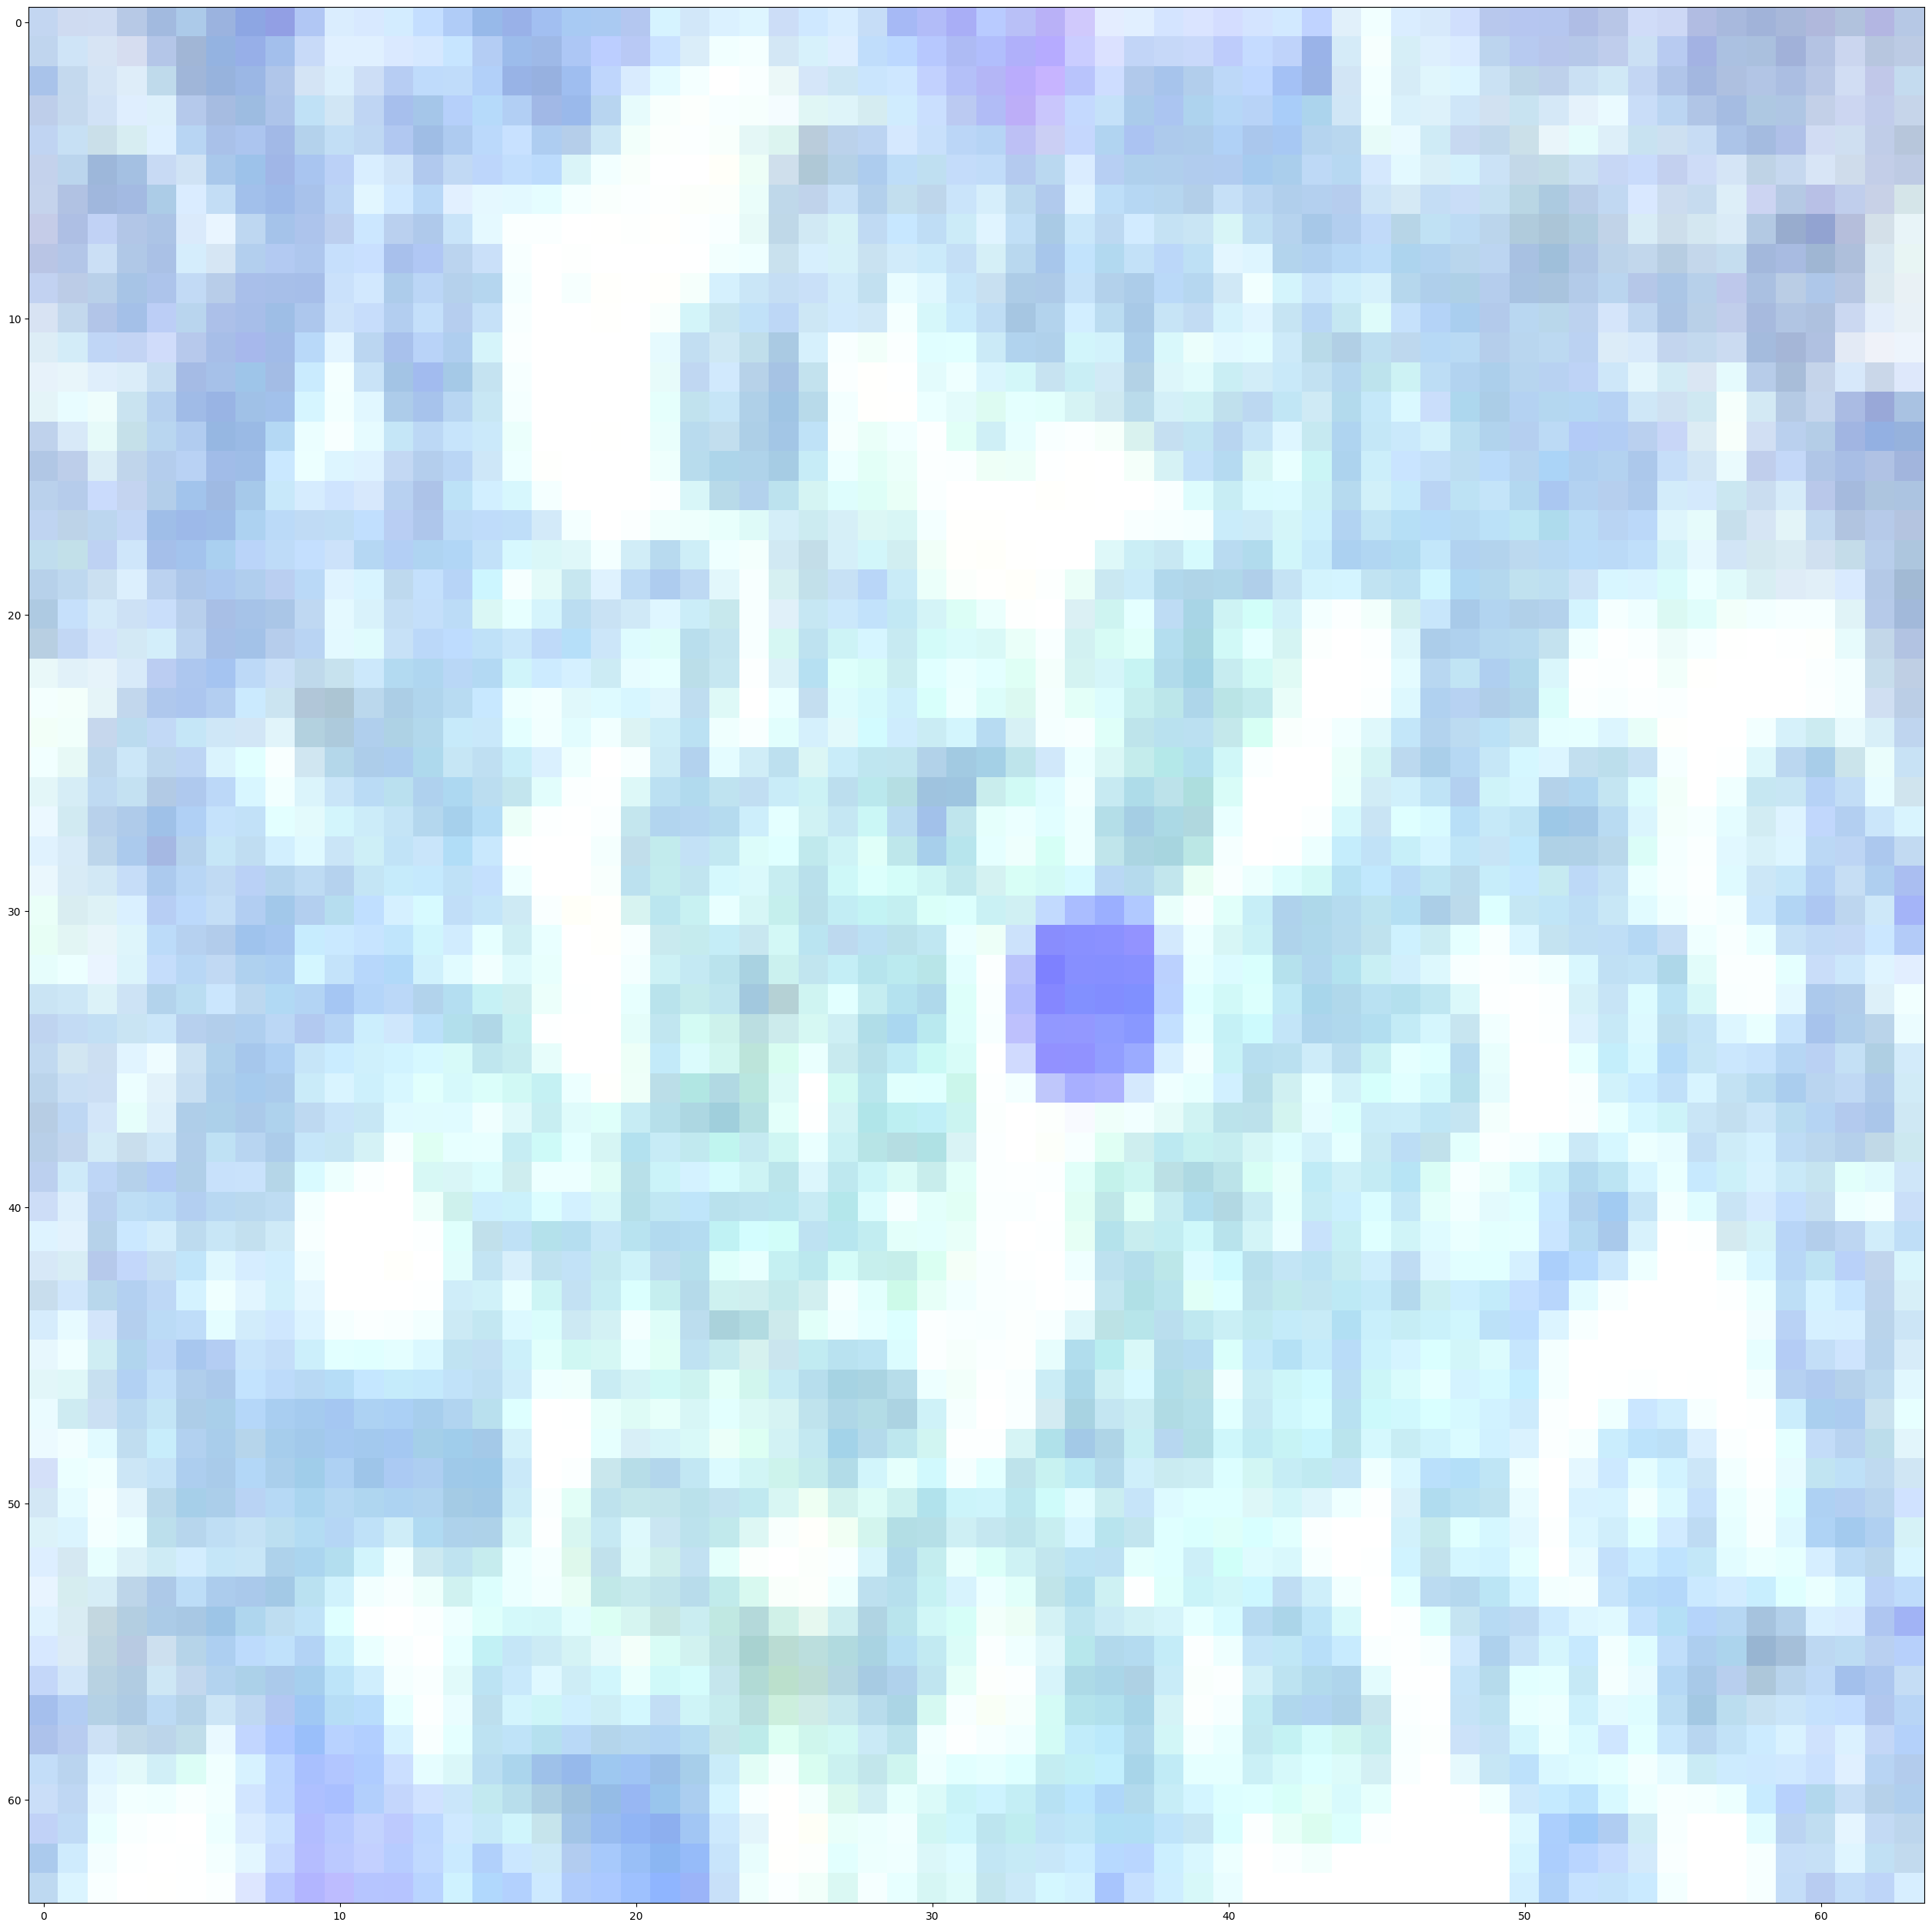

10:05:19 - INFO: Sampling 1 new images....
999it [00:19, 52.22it/s]


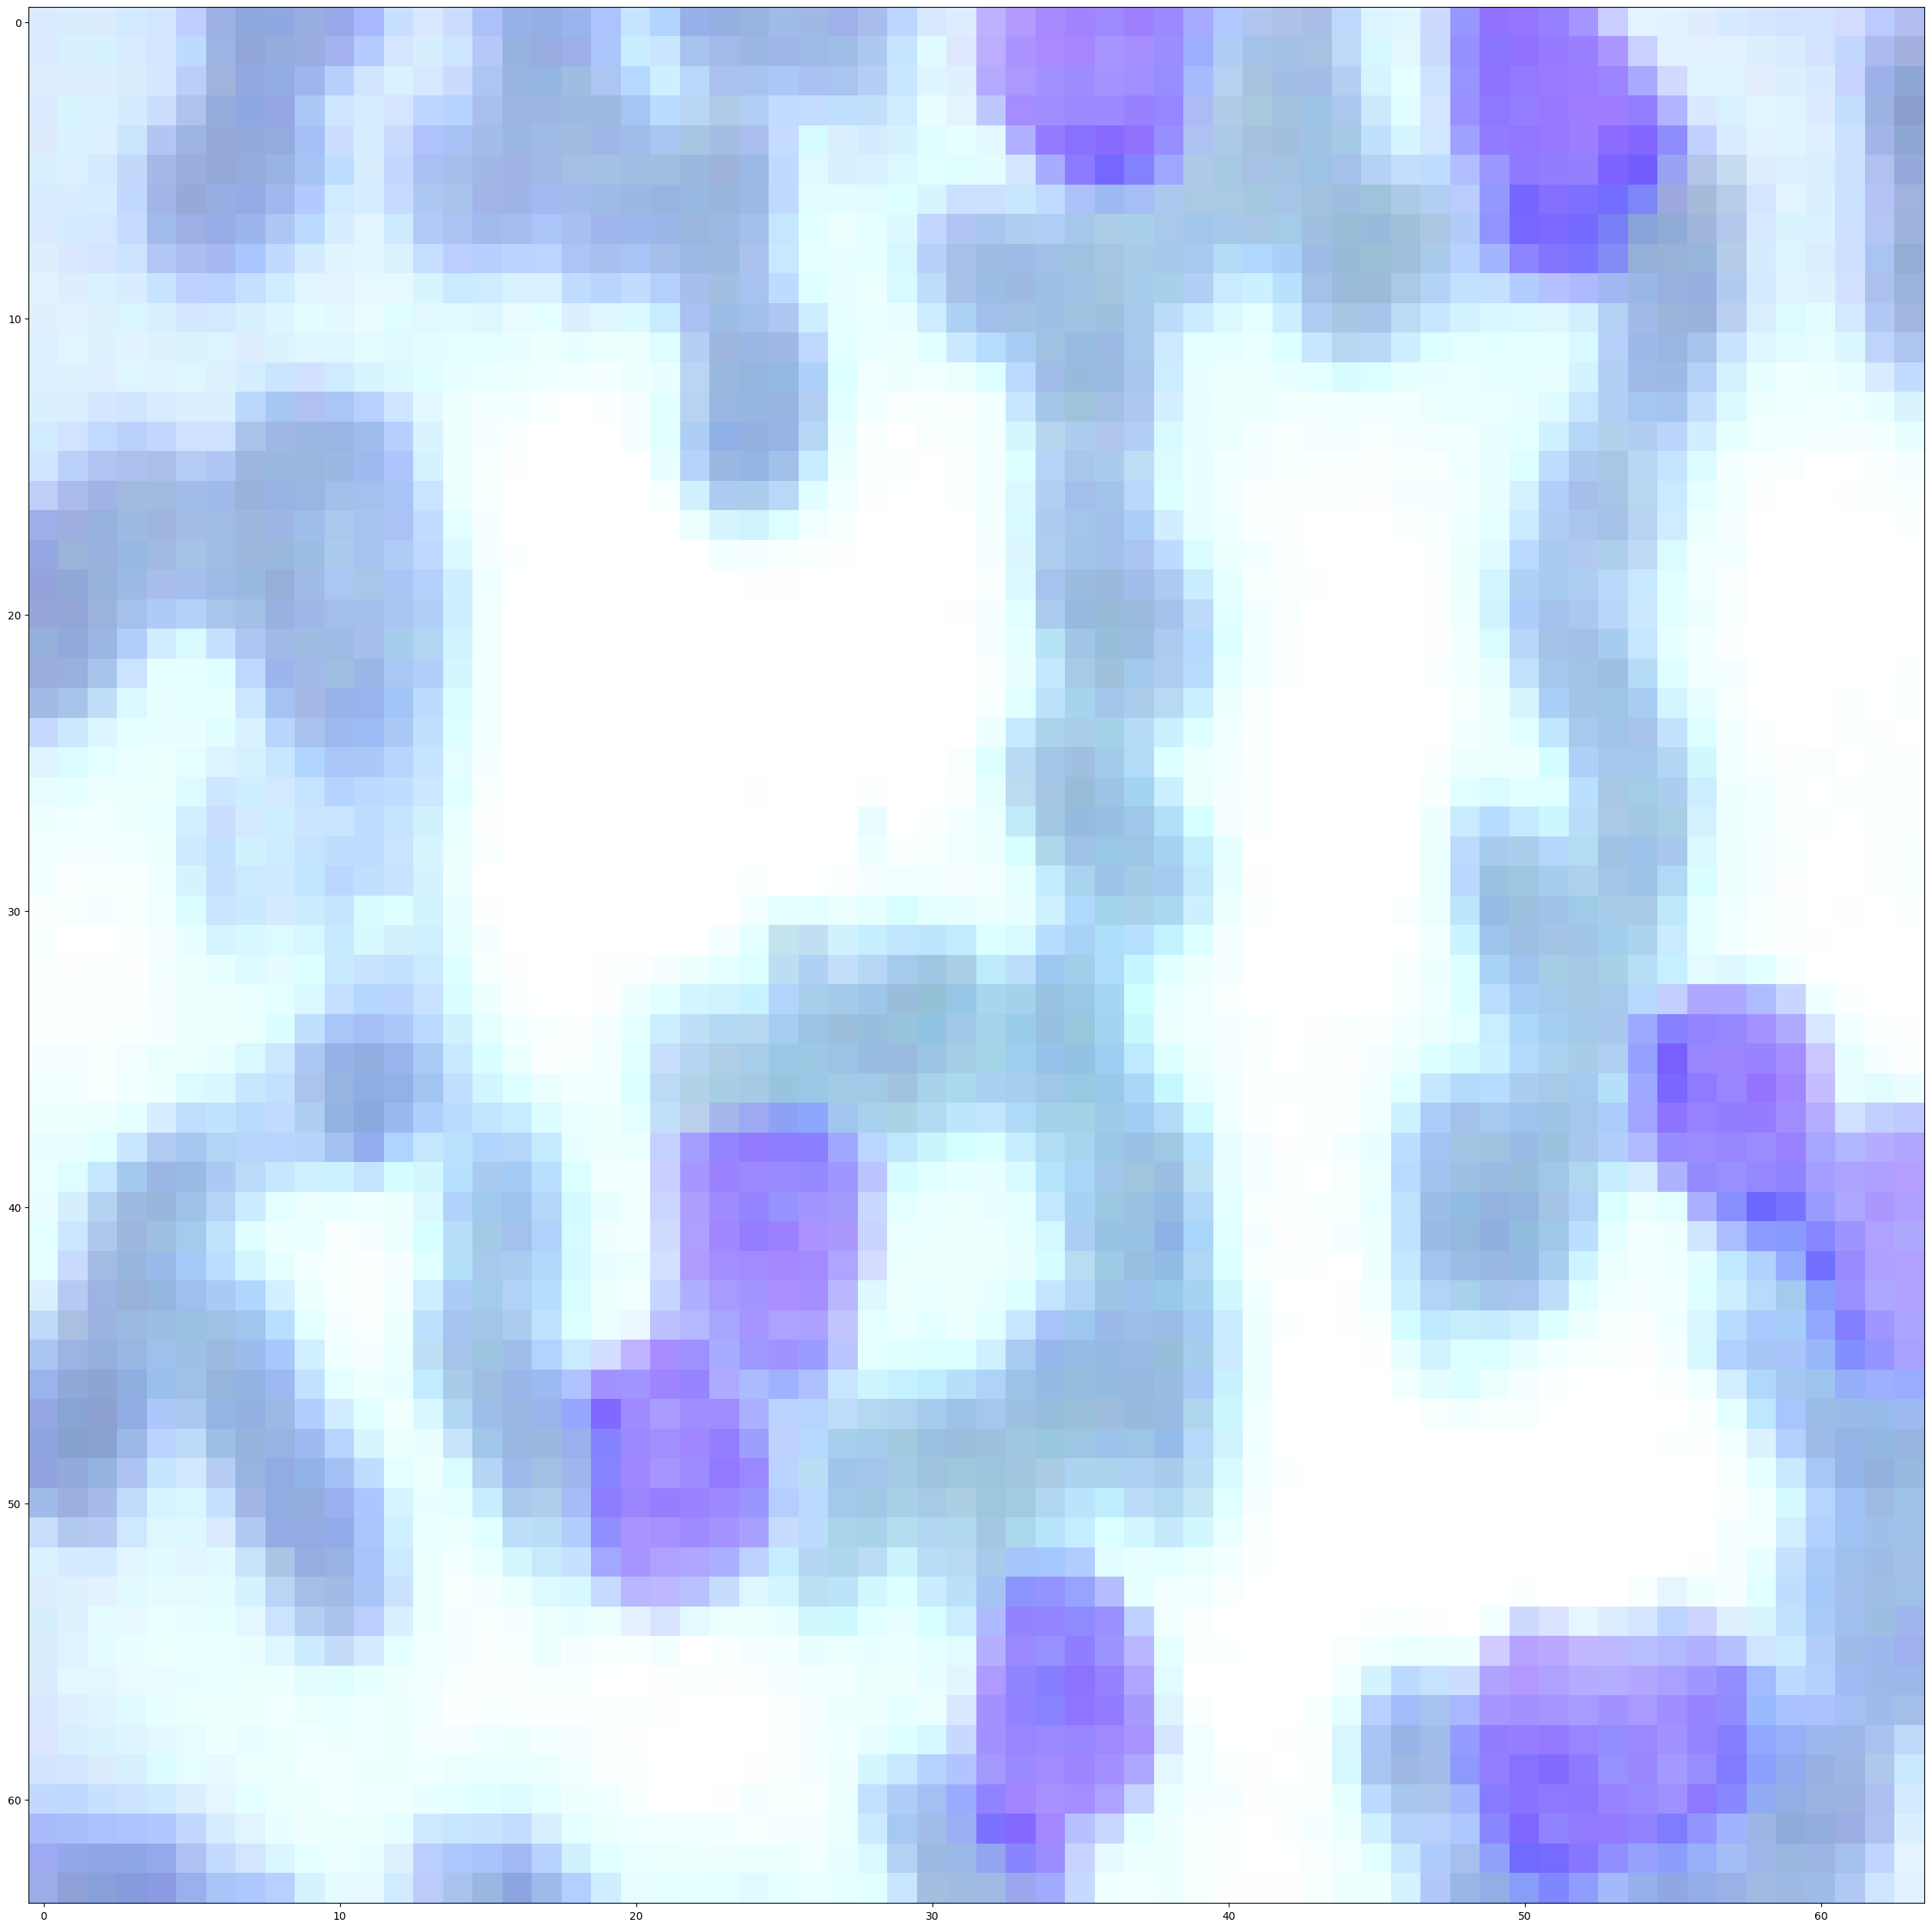

10:05:38 - INFO: Sampling 1 new images....
999it [00:19, 51.87it/s]


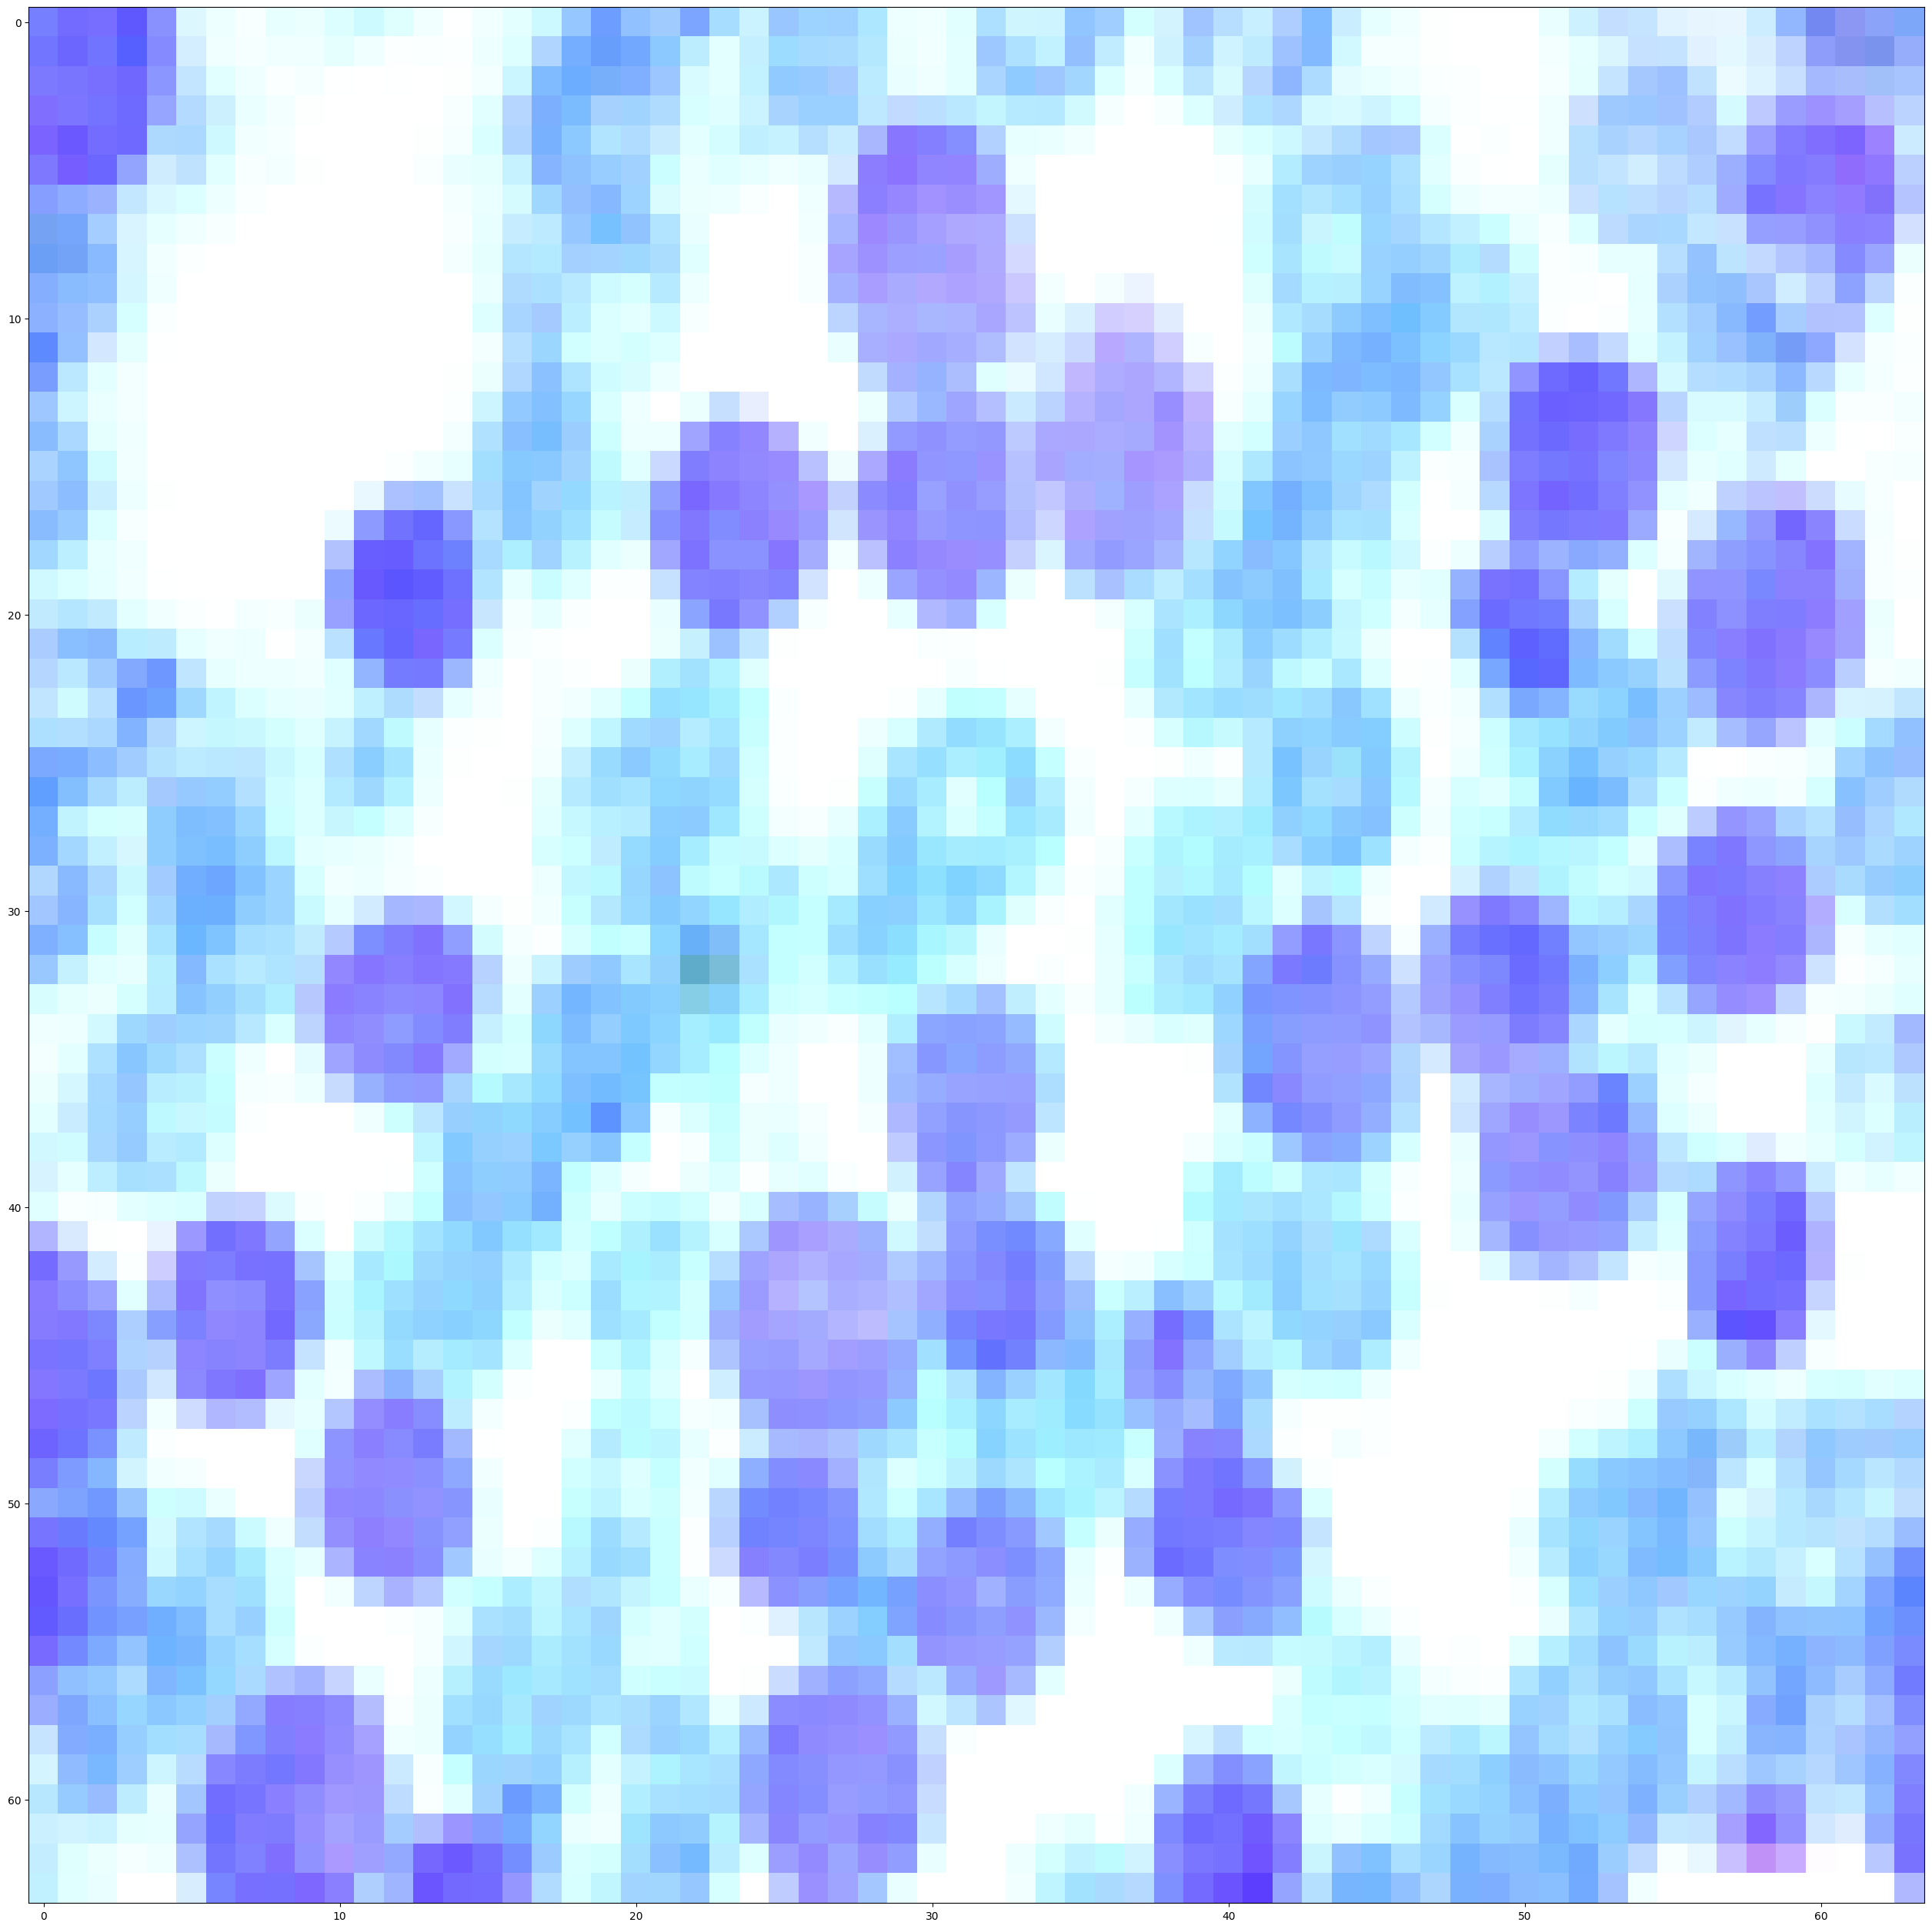

10:05:58 - INFO: Sampling 1 new images....
999it [00:19, 52.37it/s]


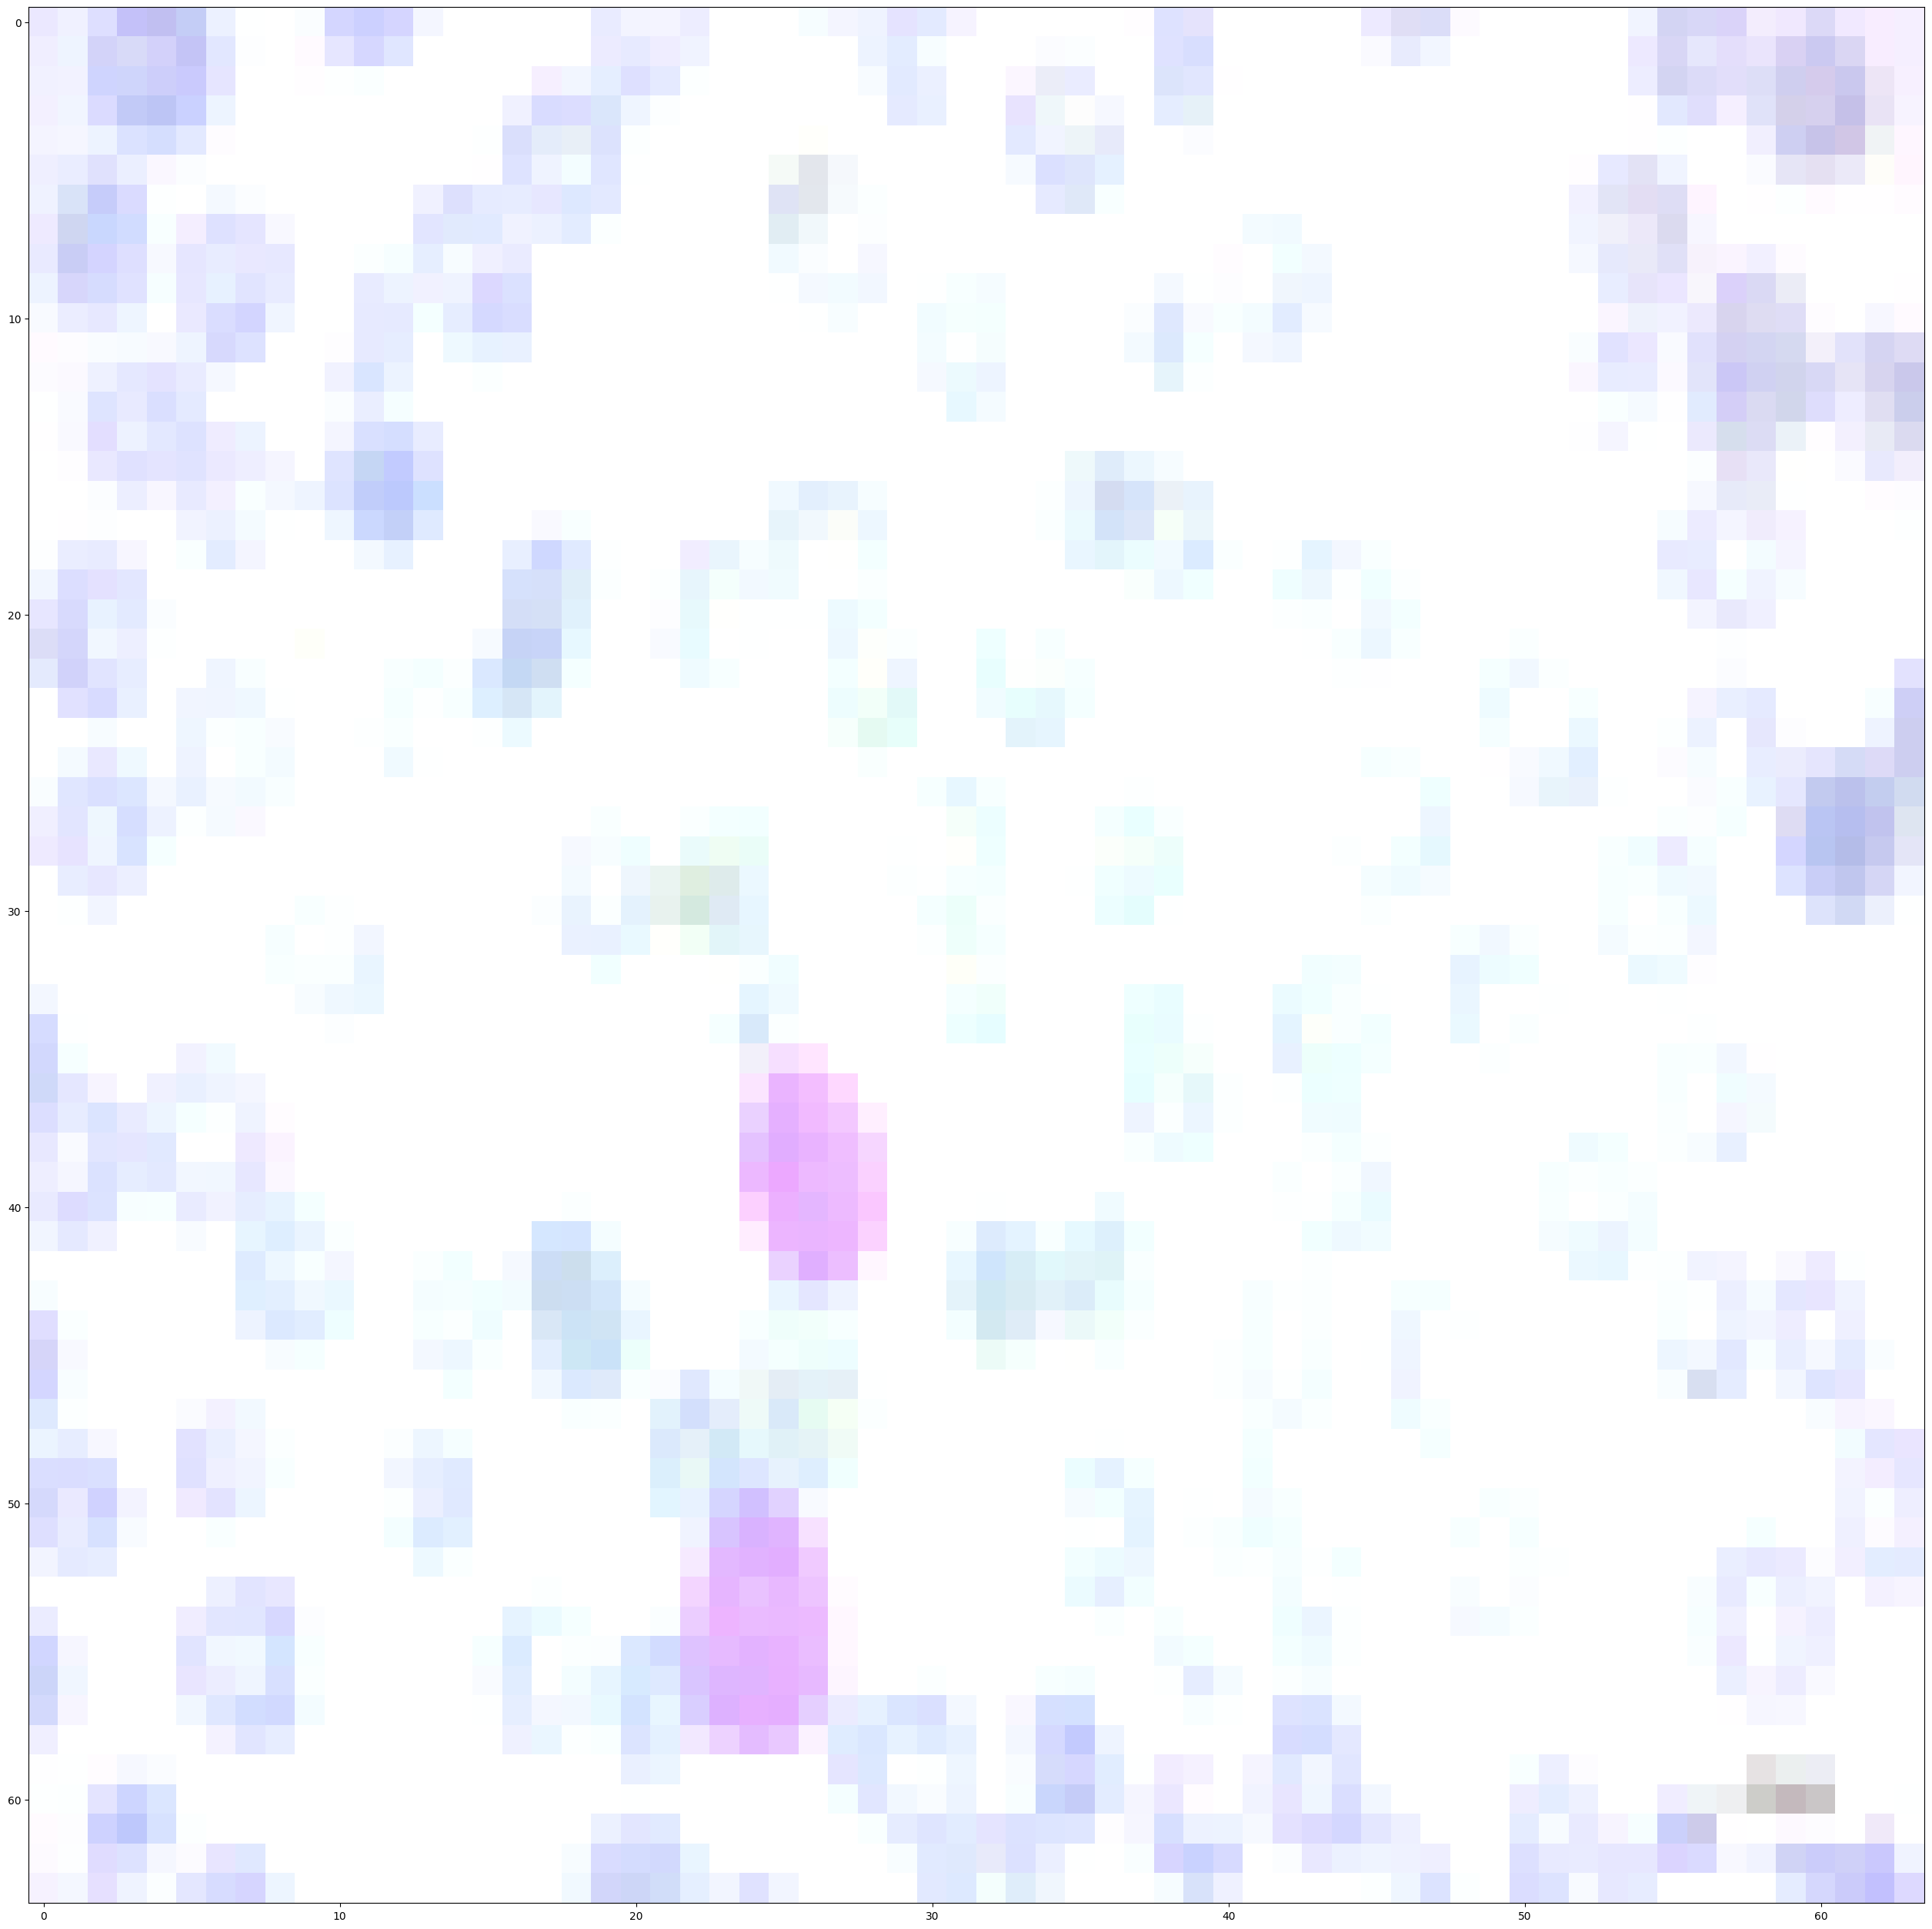

10:06:18 - INFO: Sampling 1 new images....
999it [00:19, 52.35it/s]


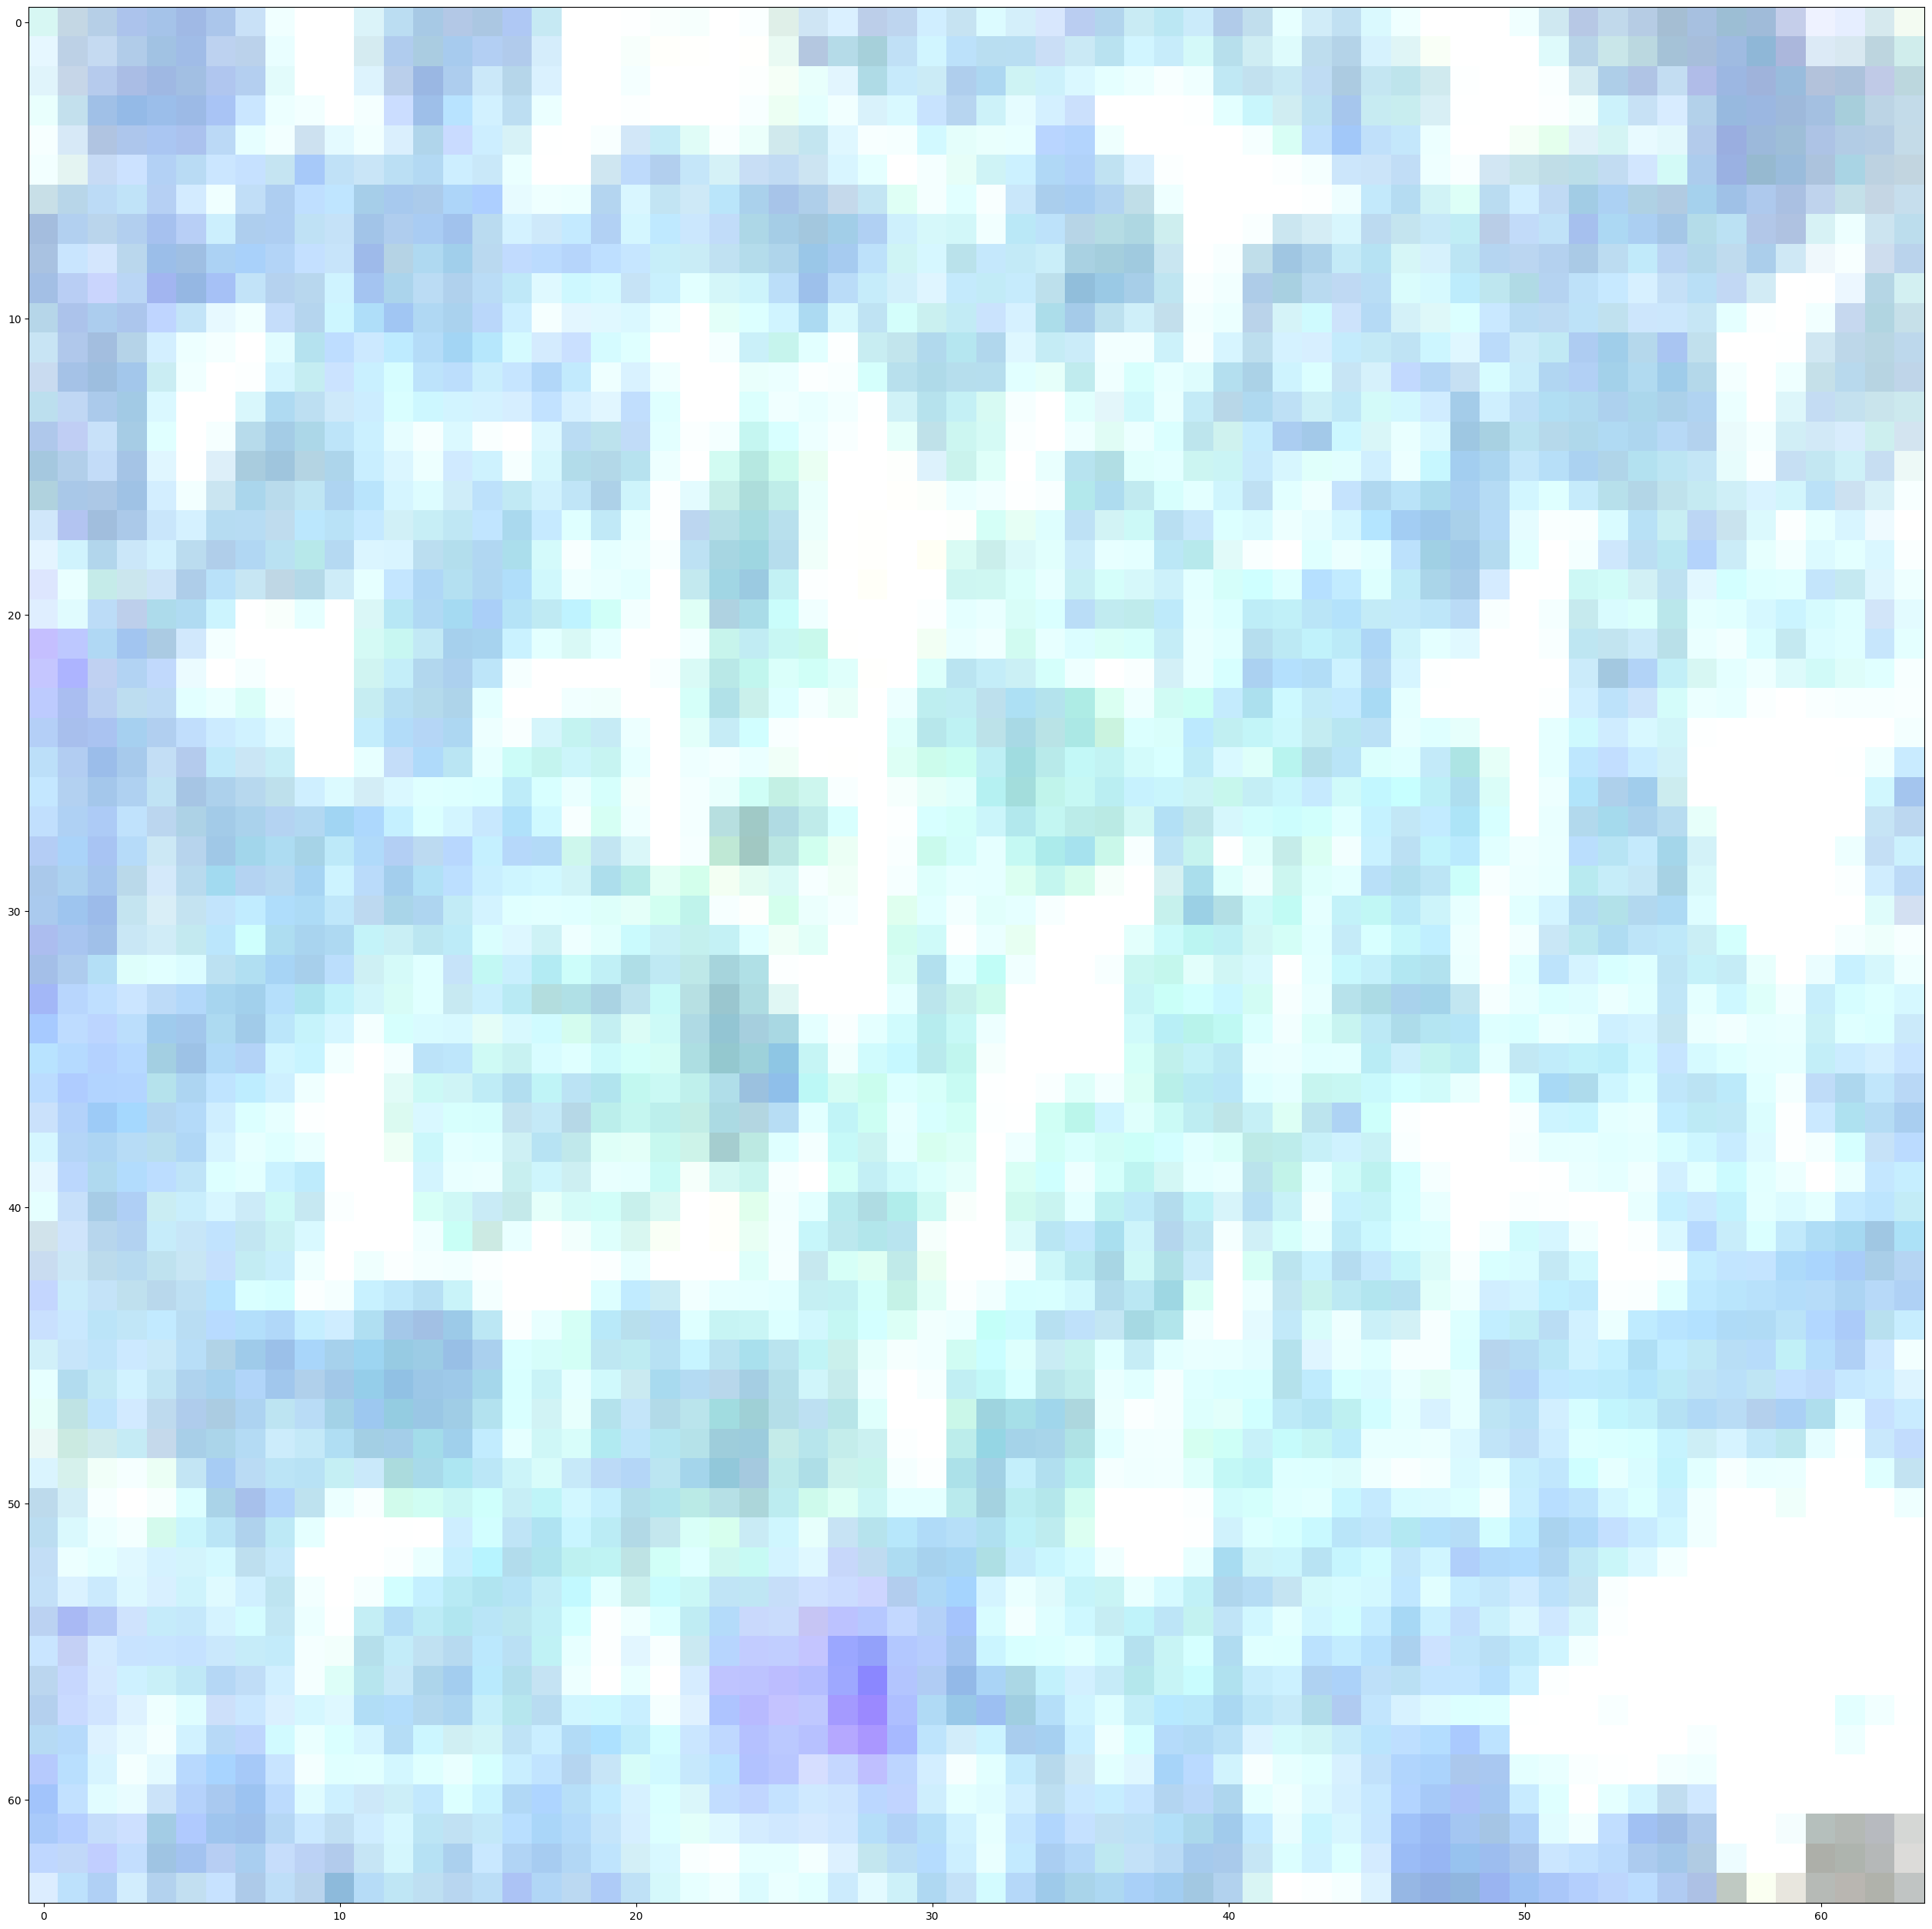

10:06:38 - INFO: Sampling 1 new images....
999it [00:19, 50.00it/s]


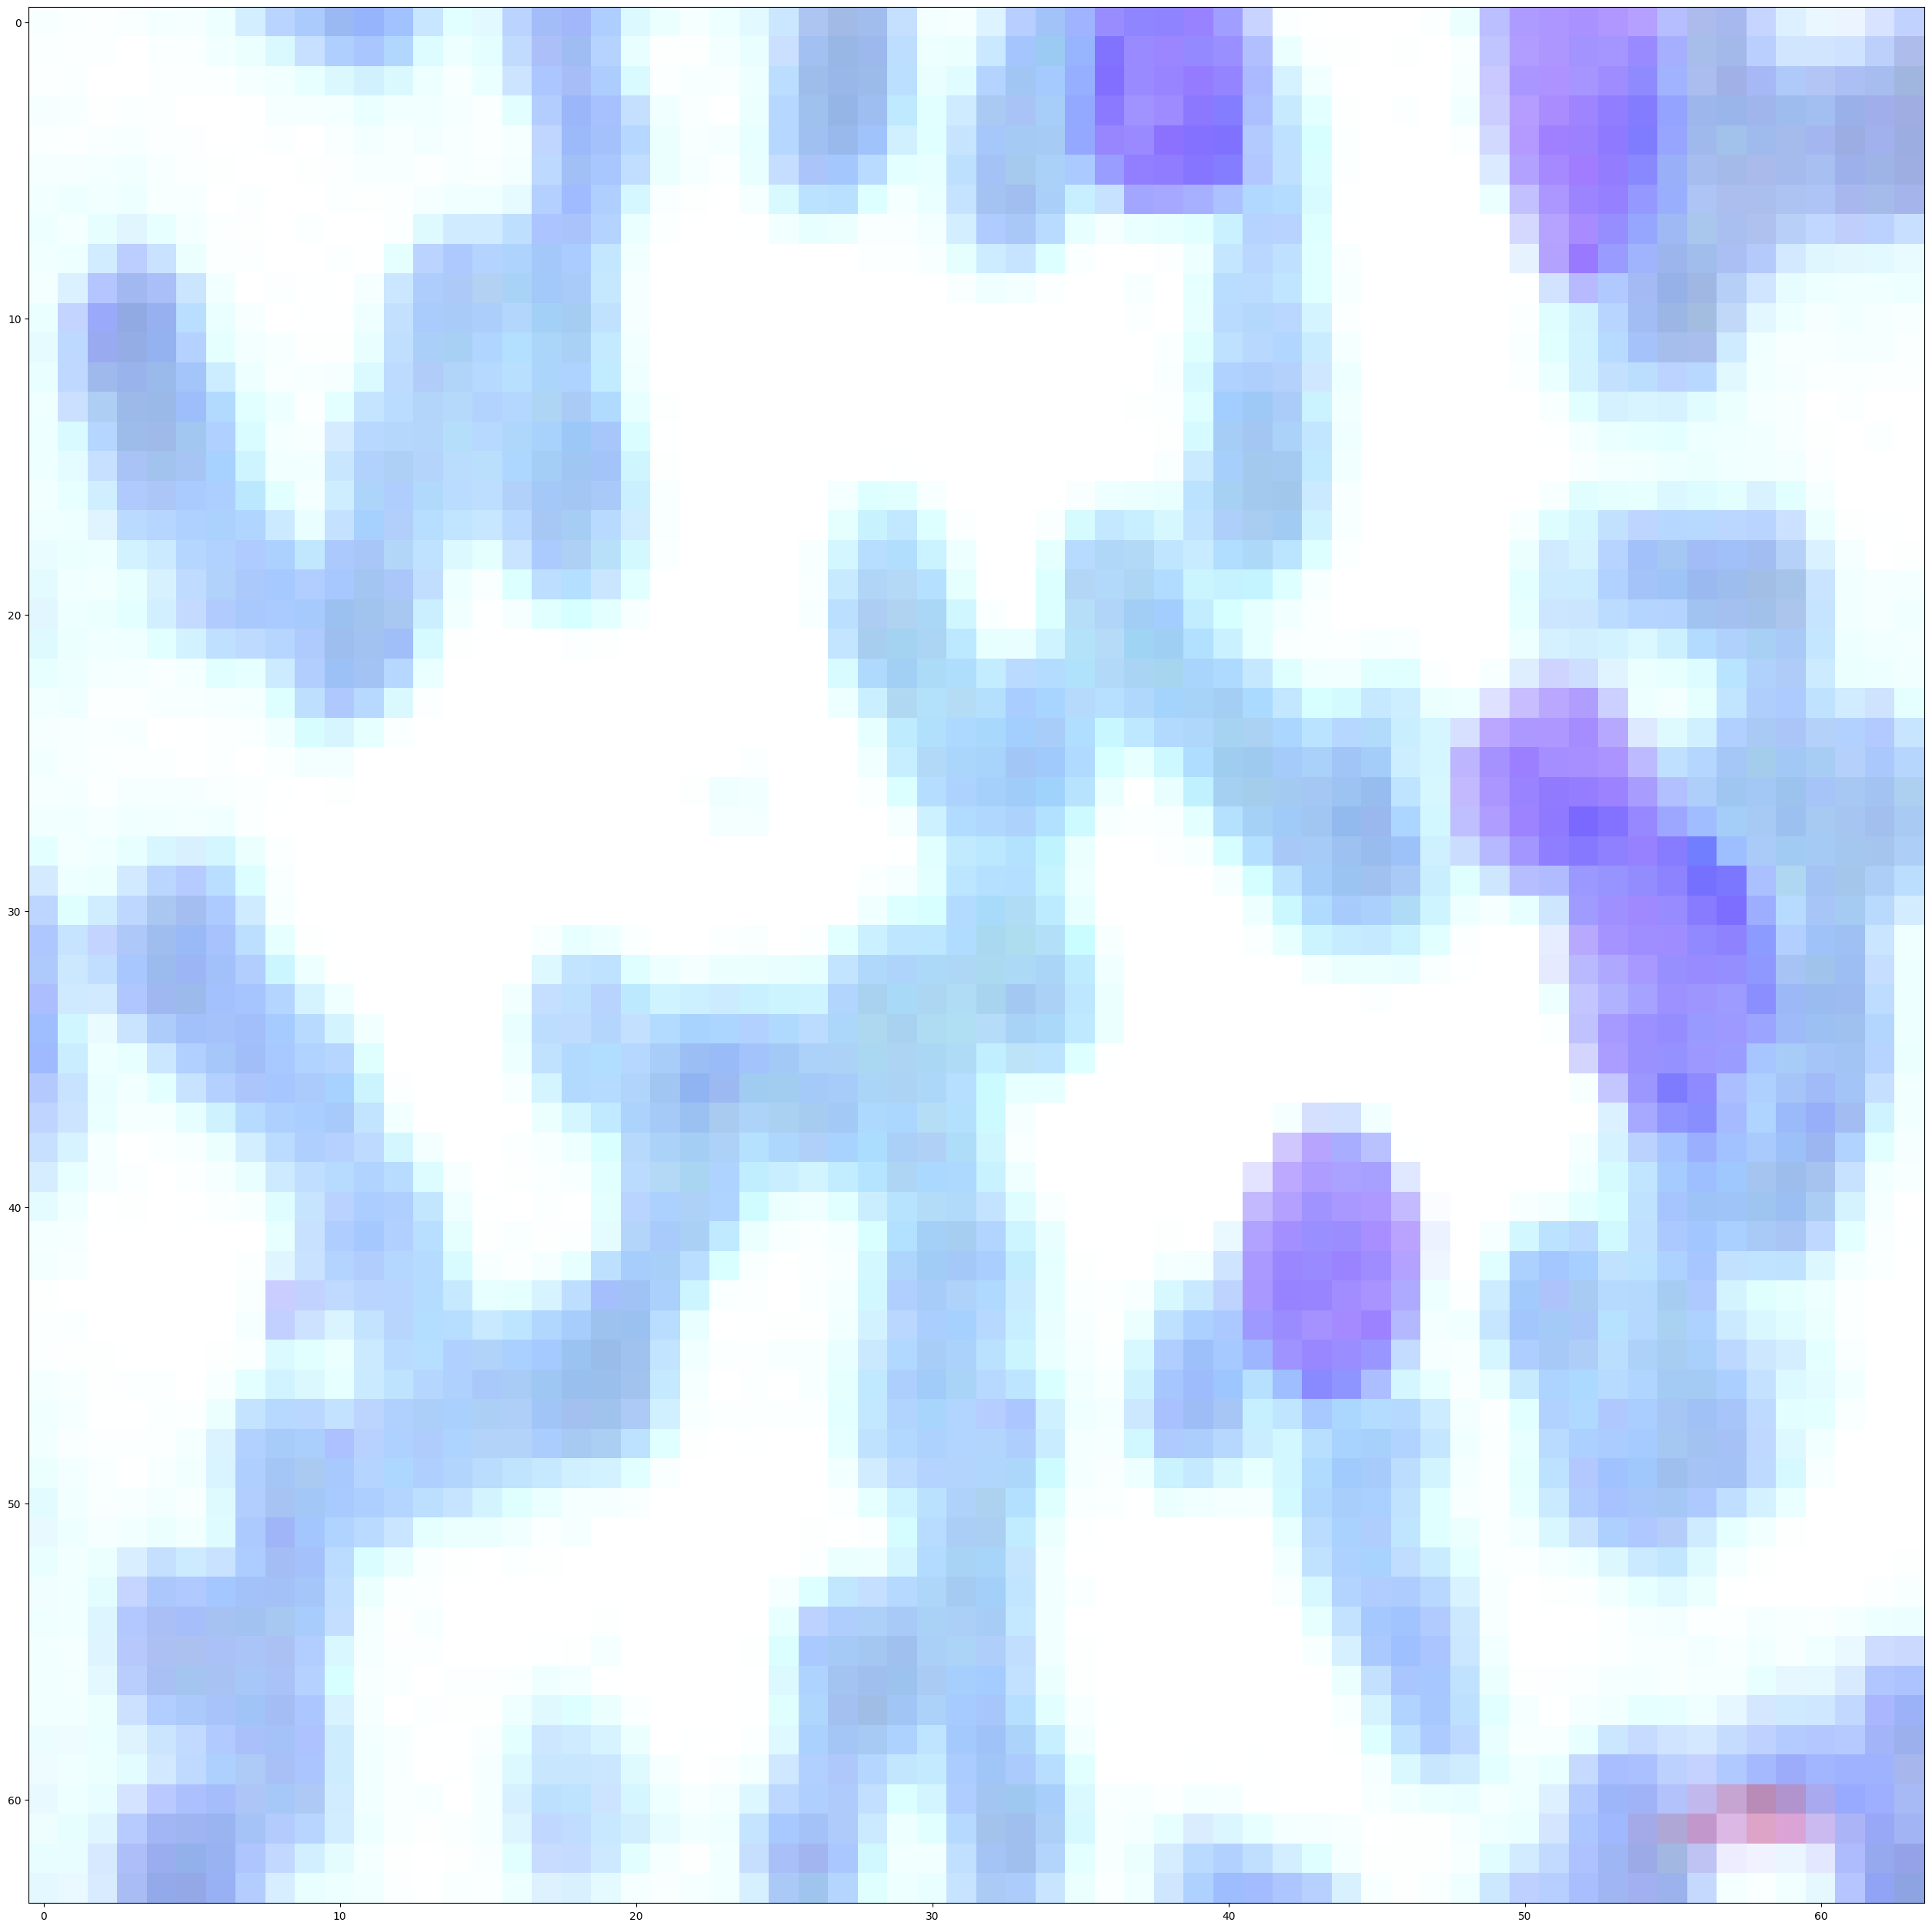

10:06:58 - INFO: Sampling 1 new images....
999it [00:19, 52.29it/s]


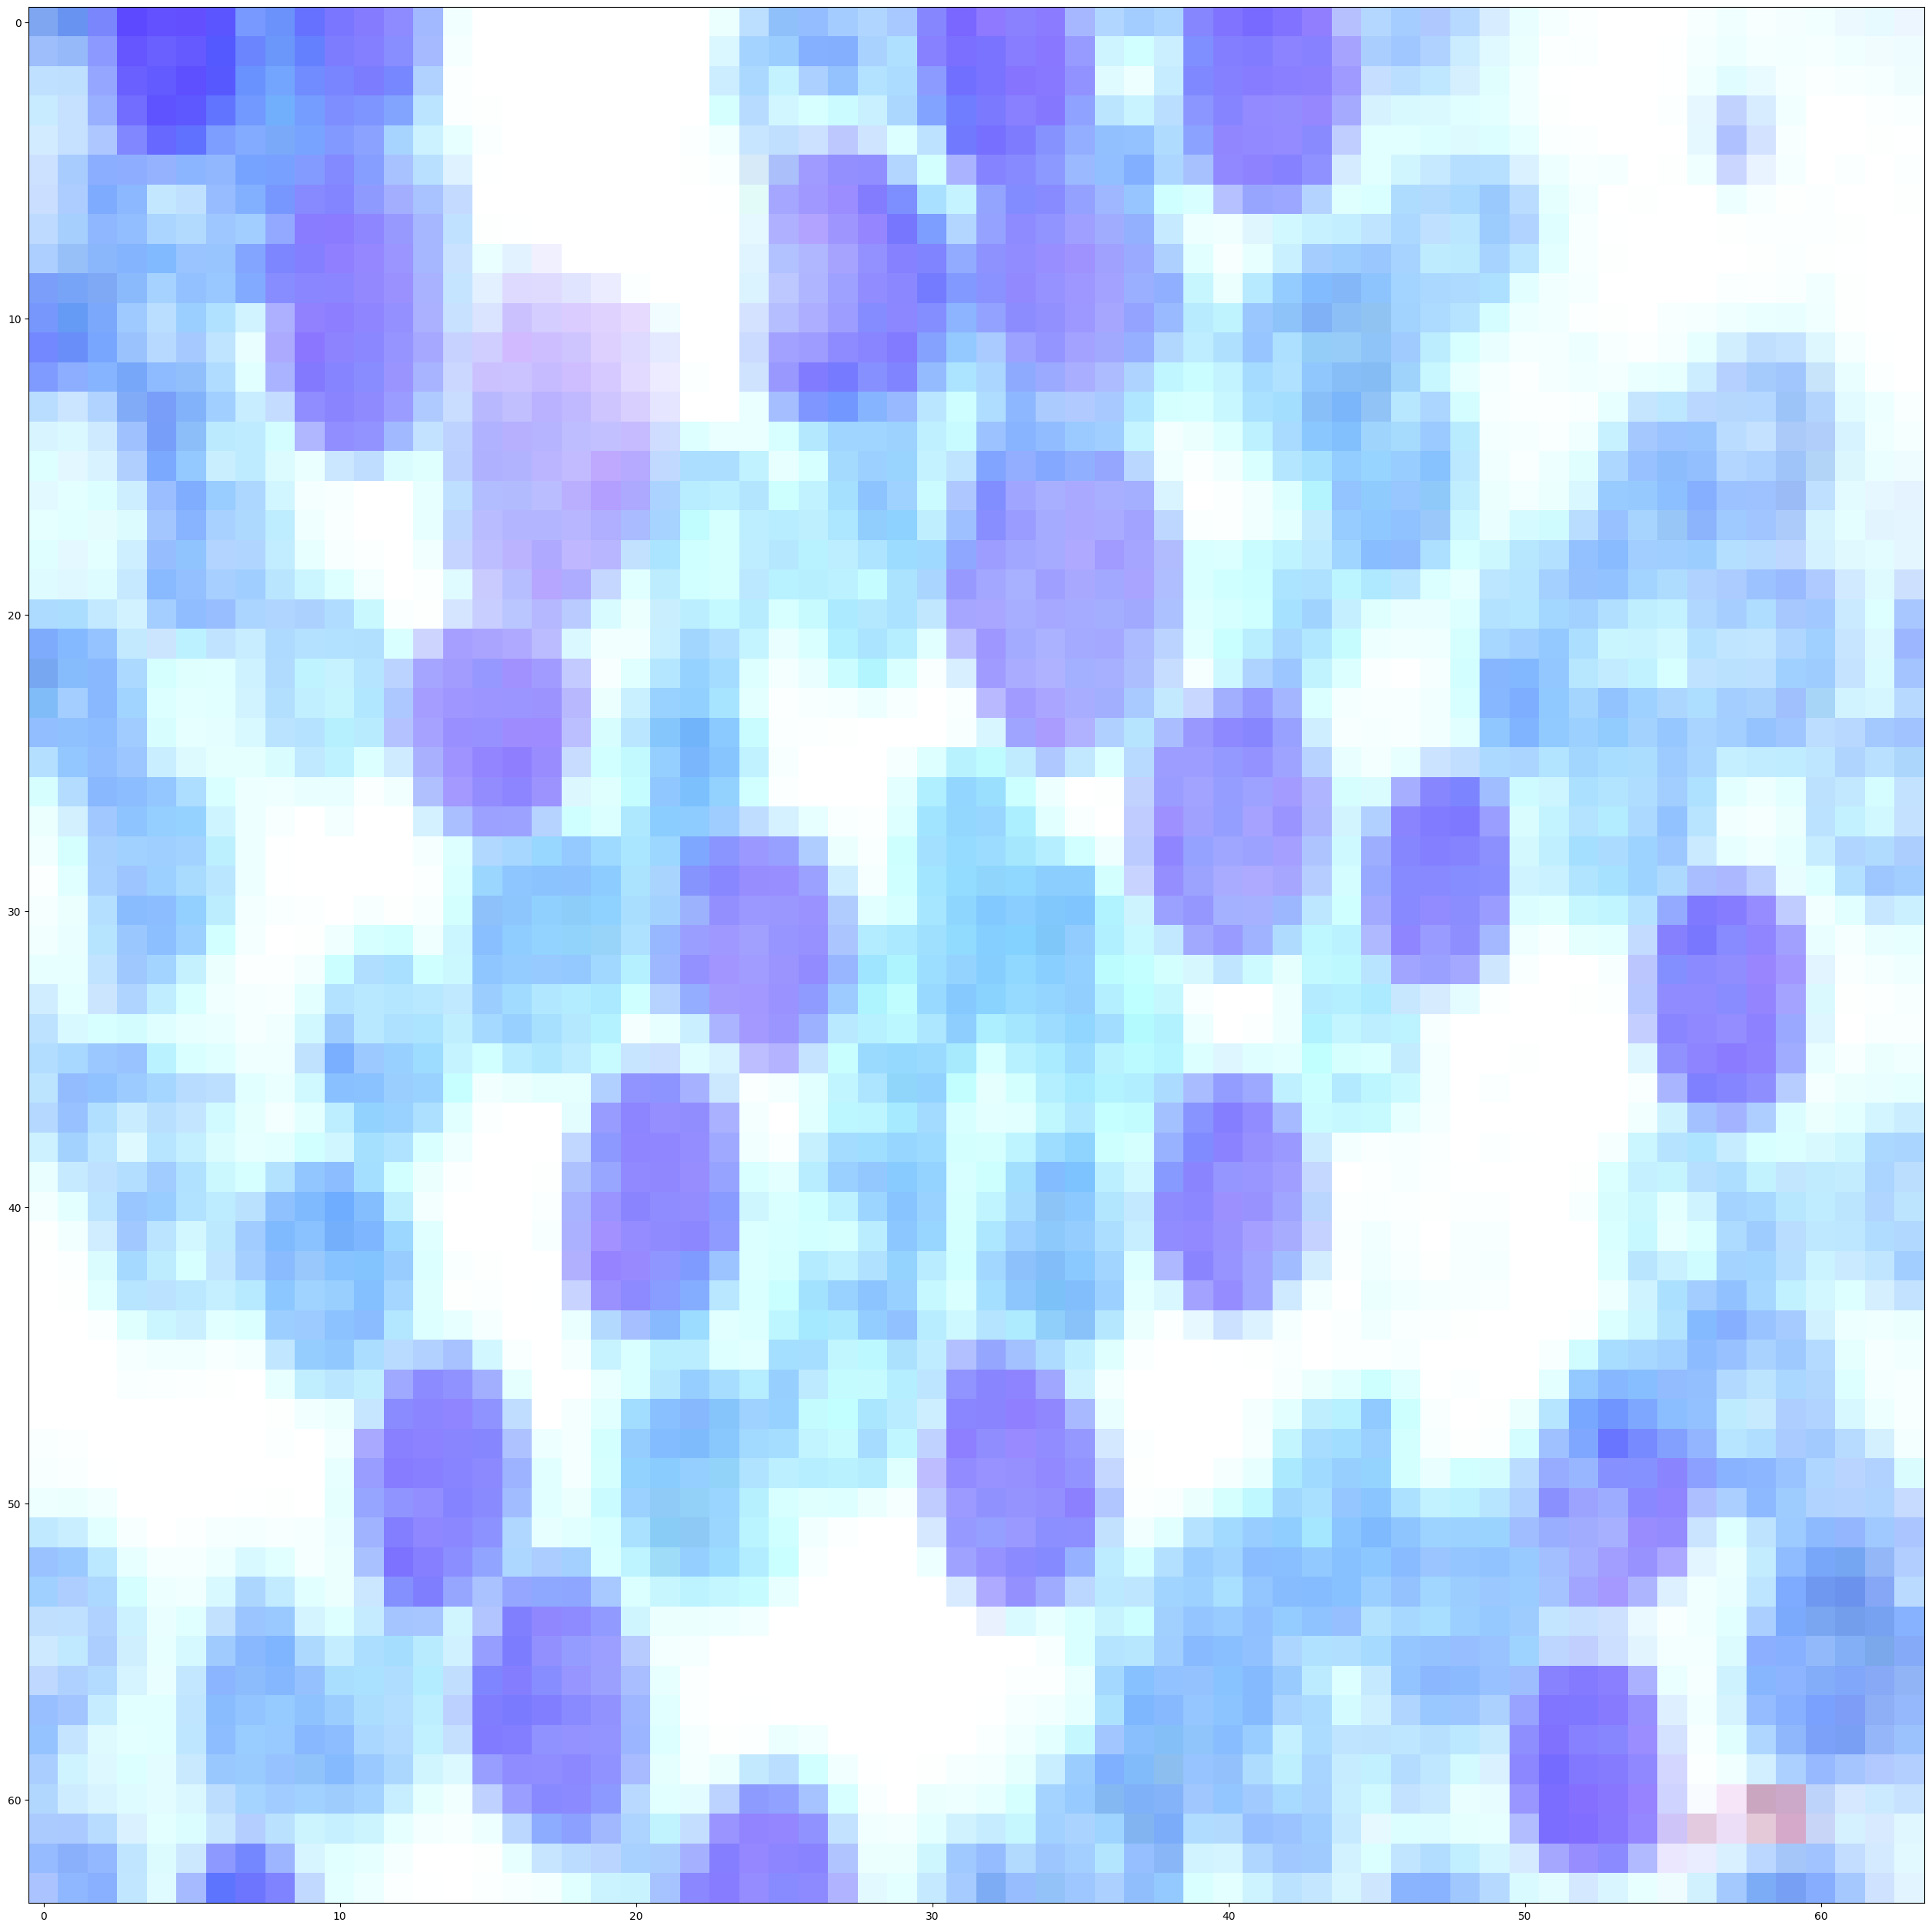

10:07:18 - INFO: Sampling 1 new images....
999it [00:19, 50.49it/s]


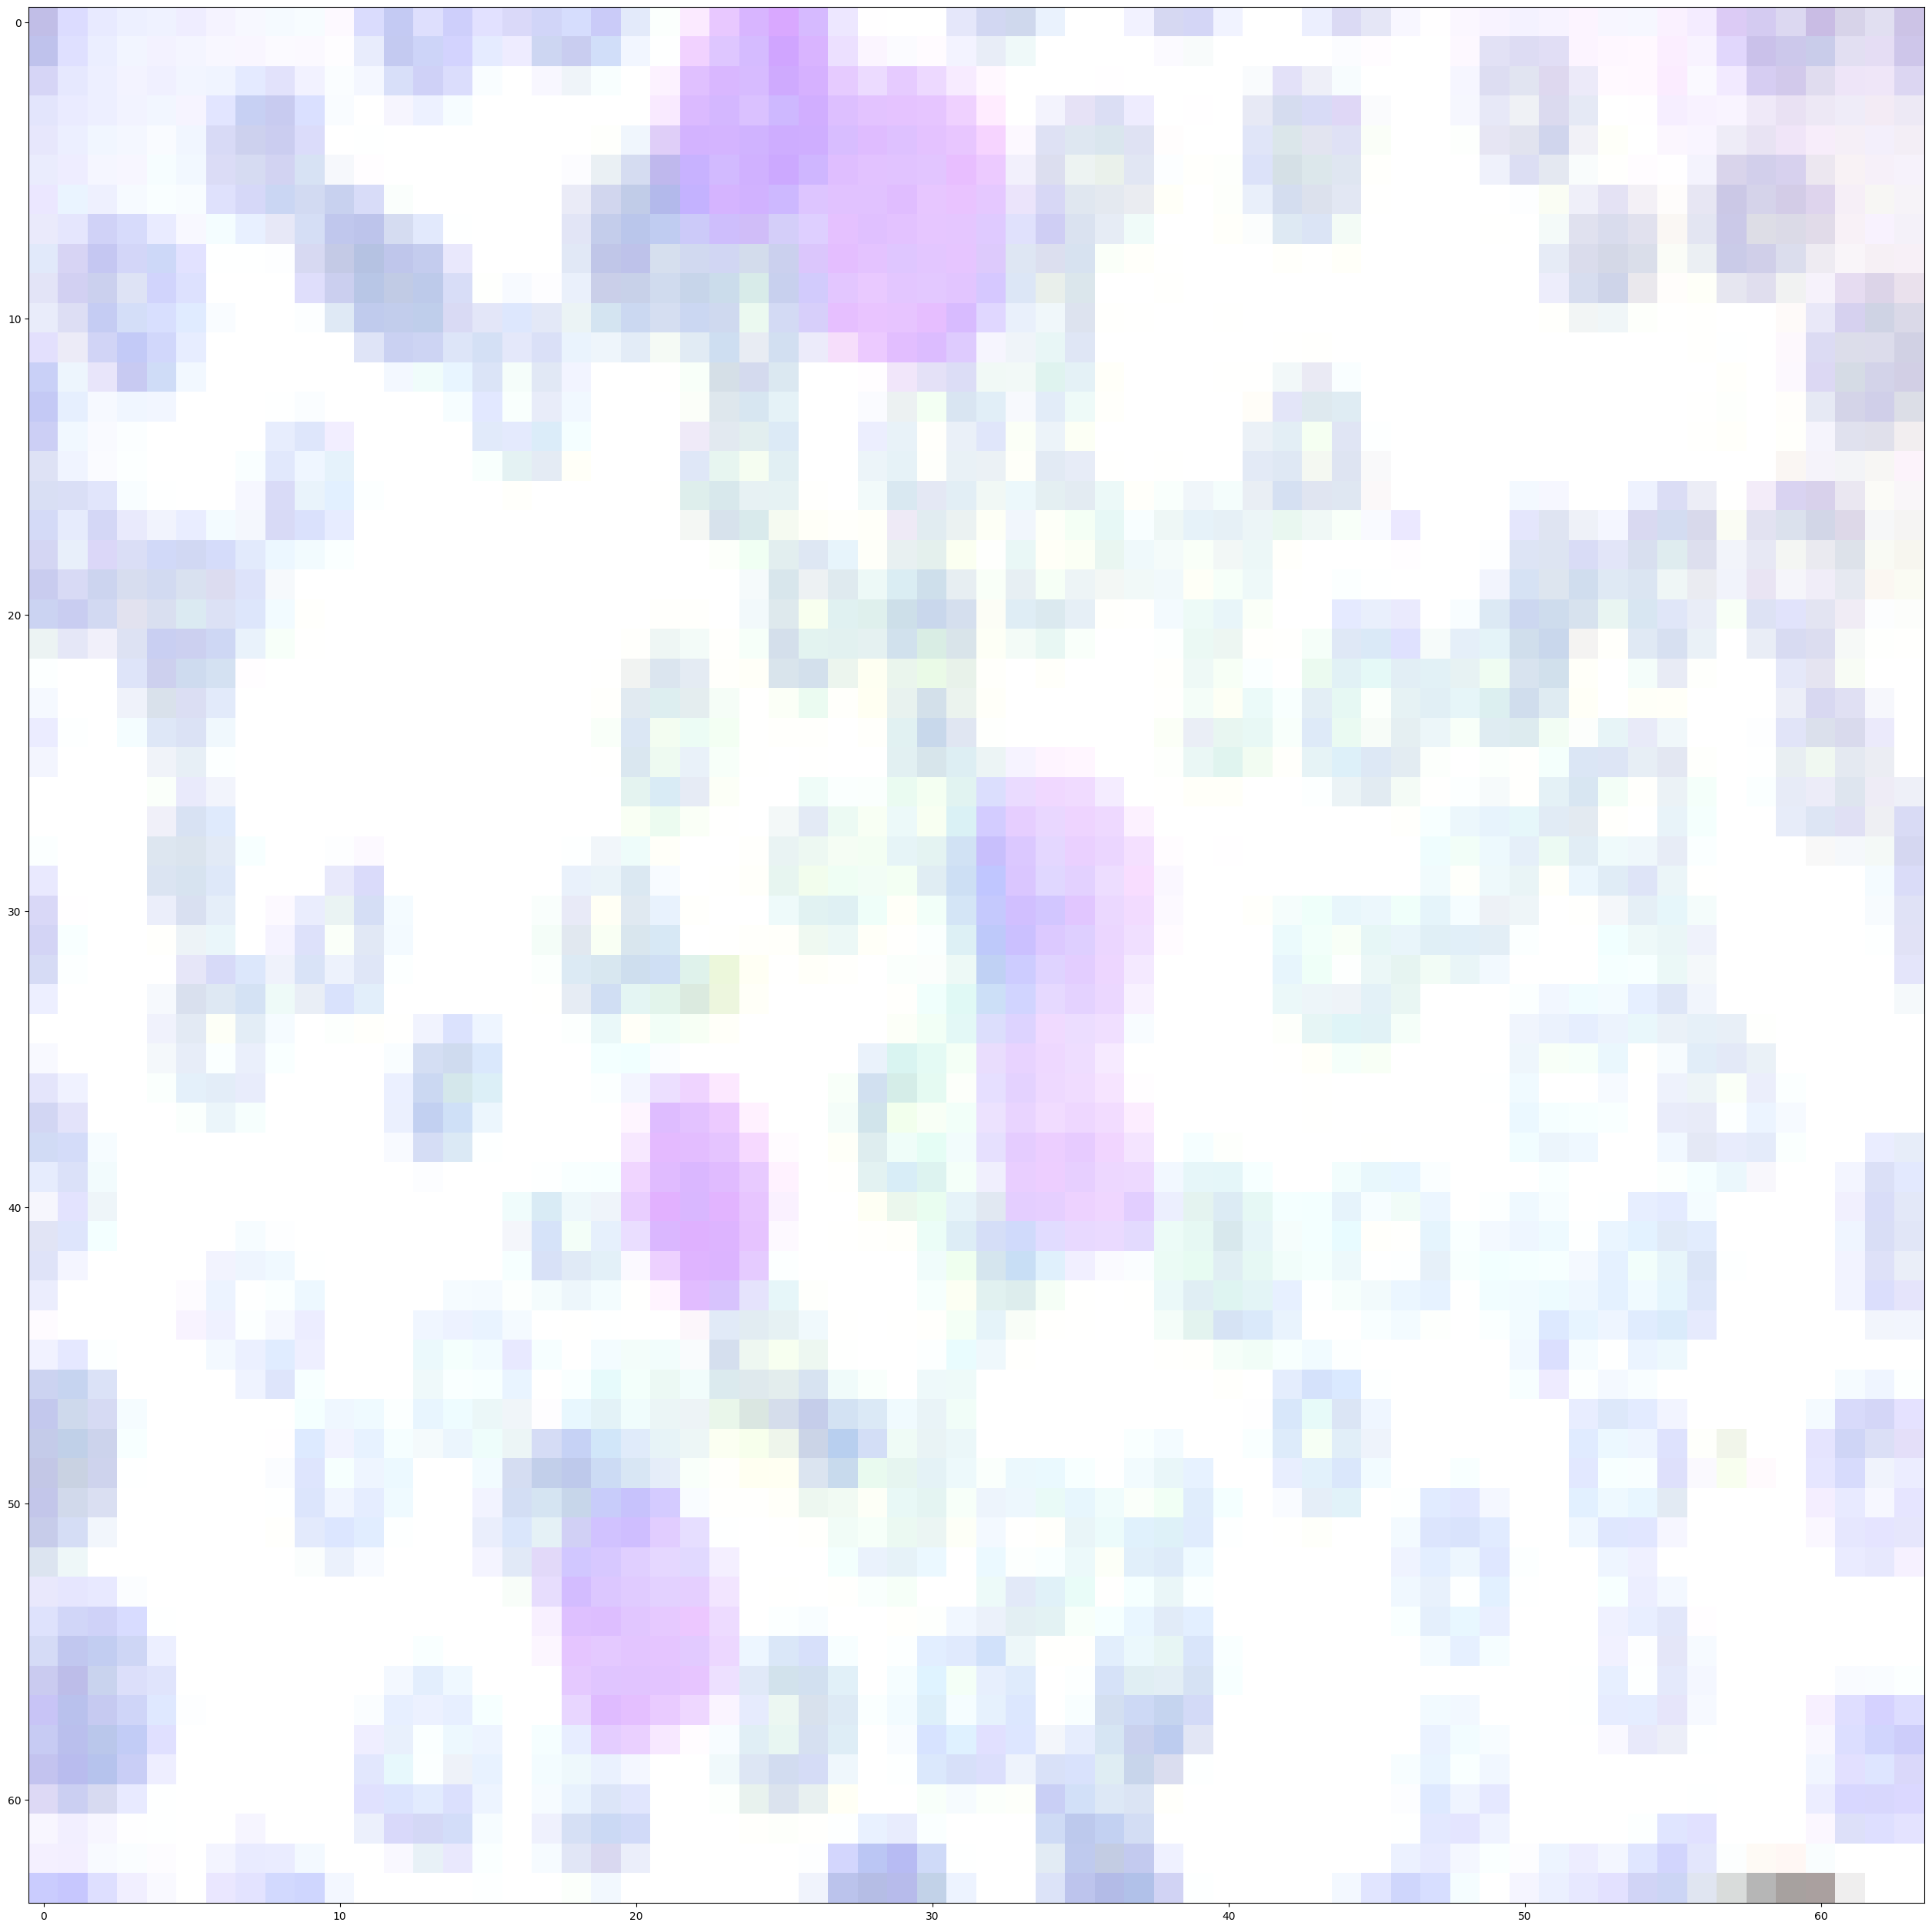

10:07:38 - INFO: Sampling 1 new images....
999it [00:18, 52.80it/s]


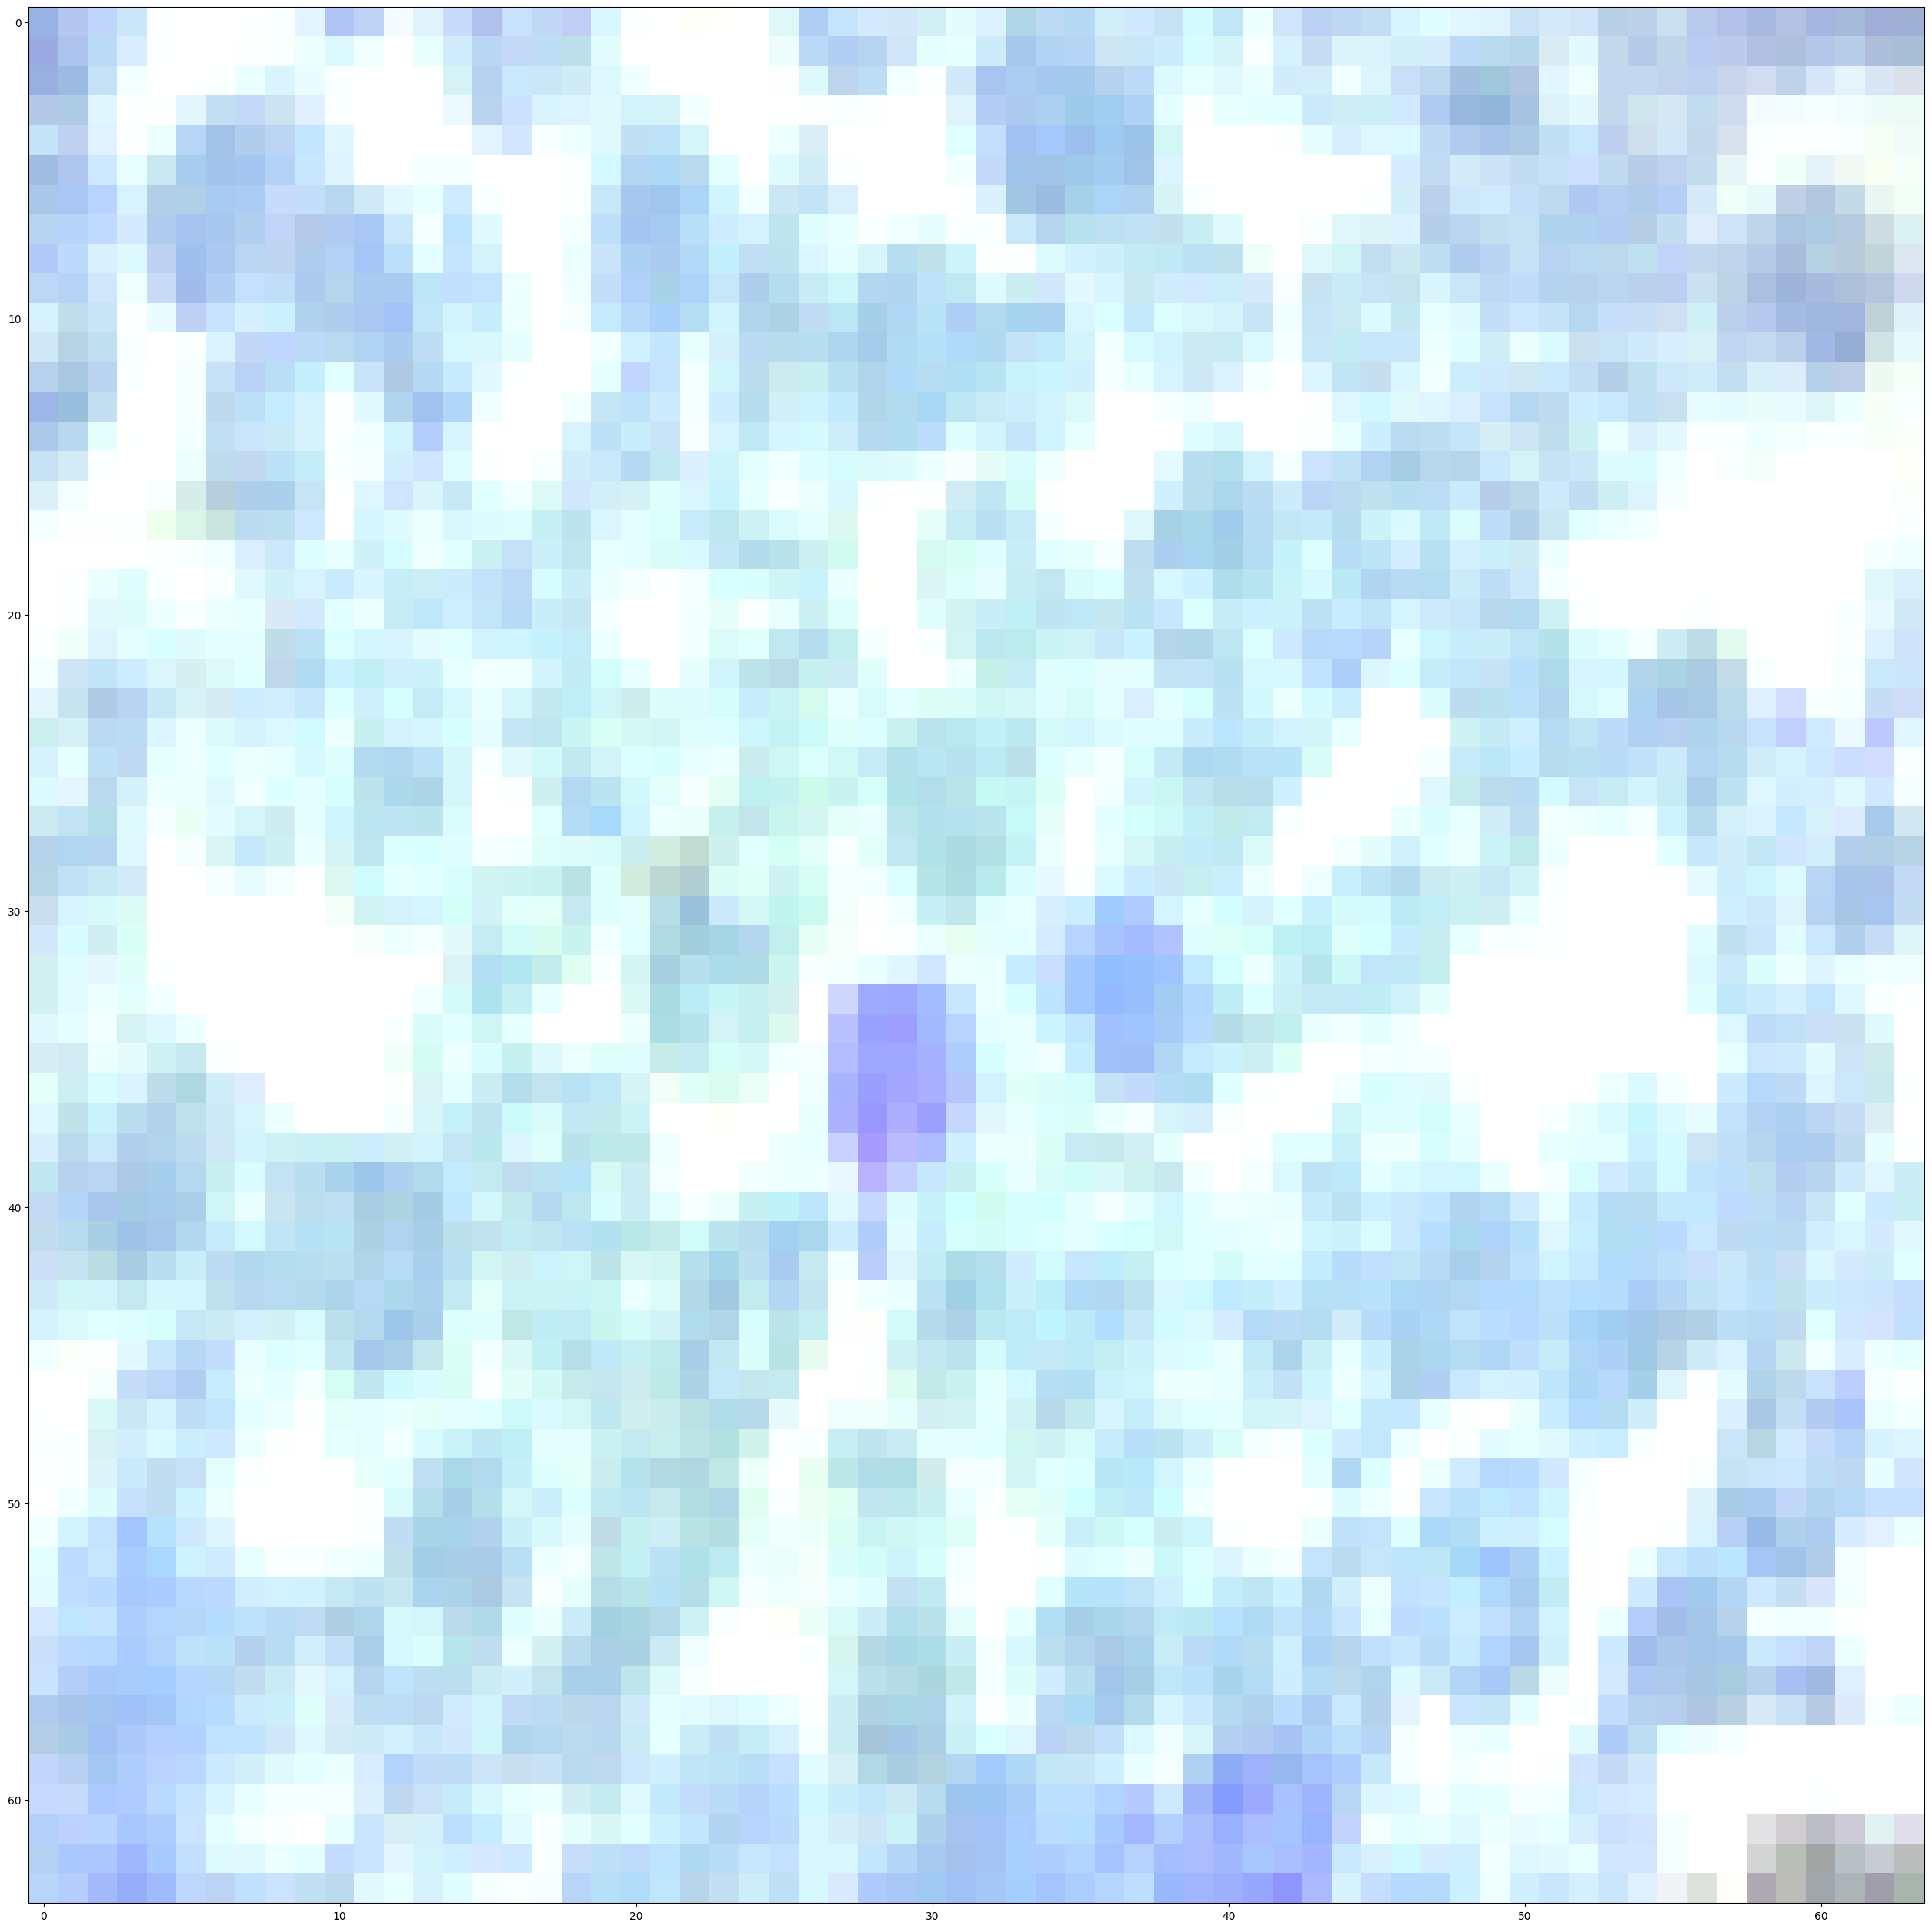

10:07:58 - INFO: Sampling 1 new images....
999it [00:20, 48.72it/s]


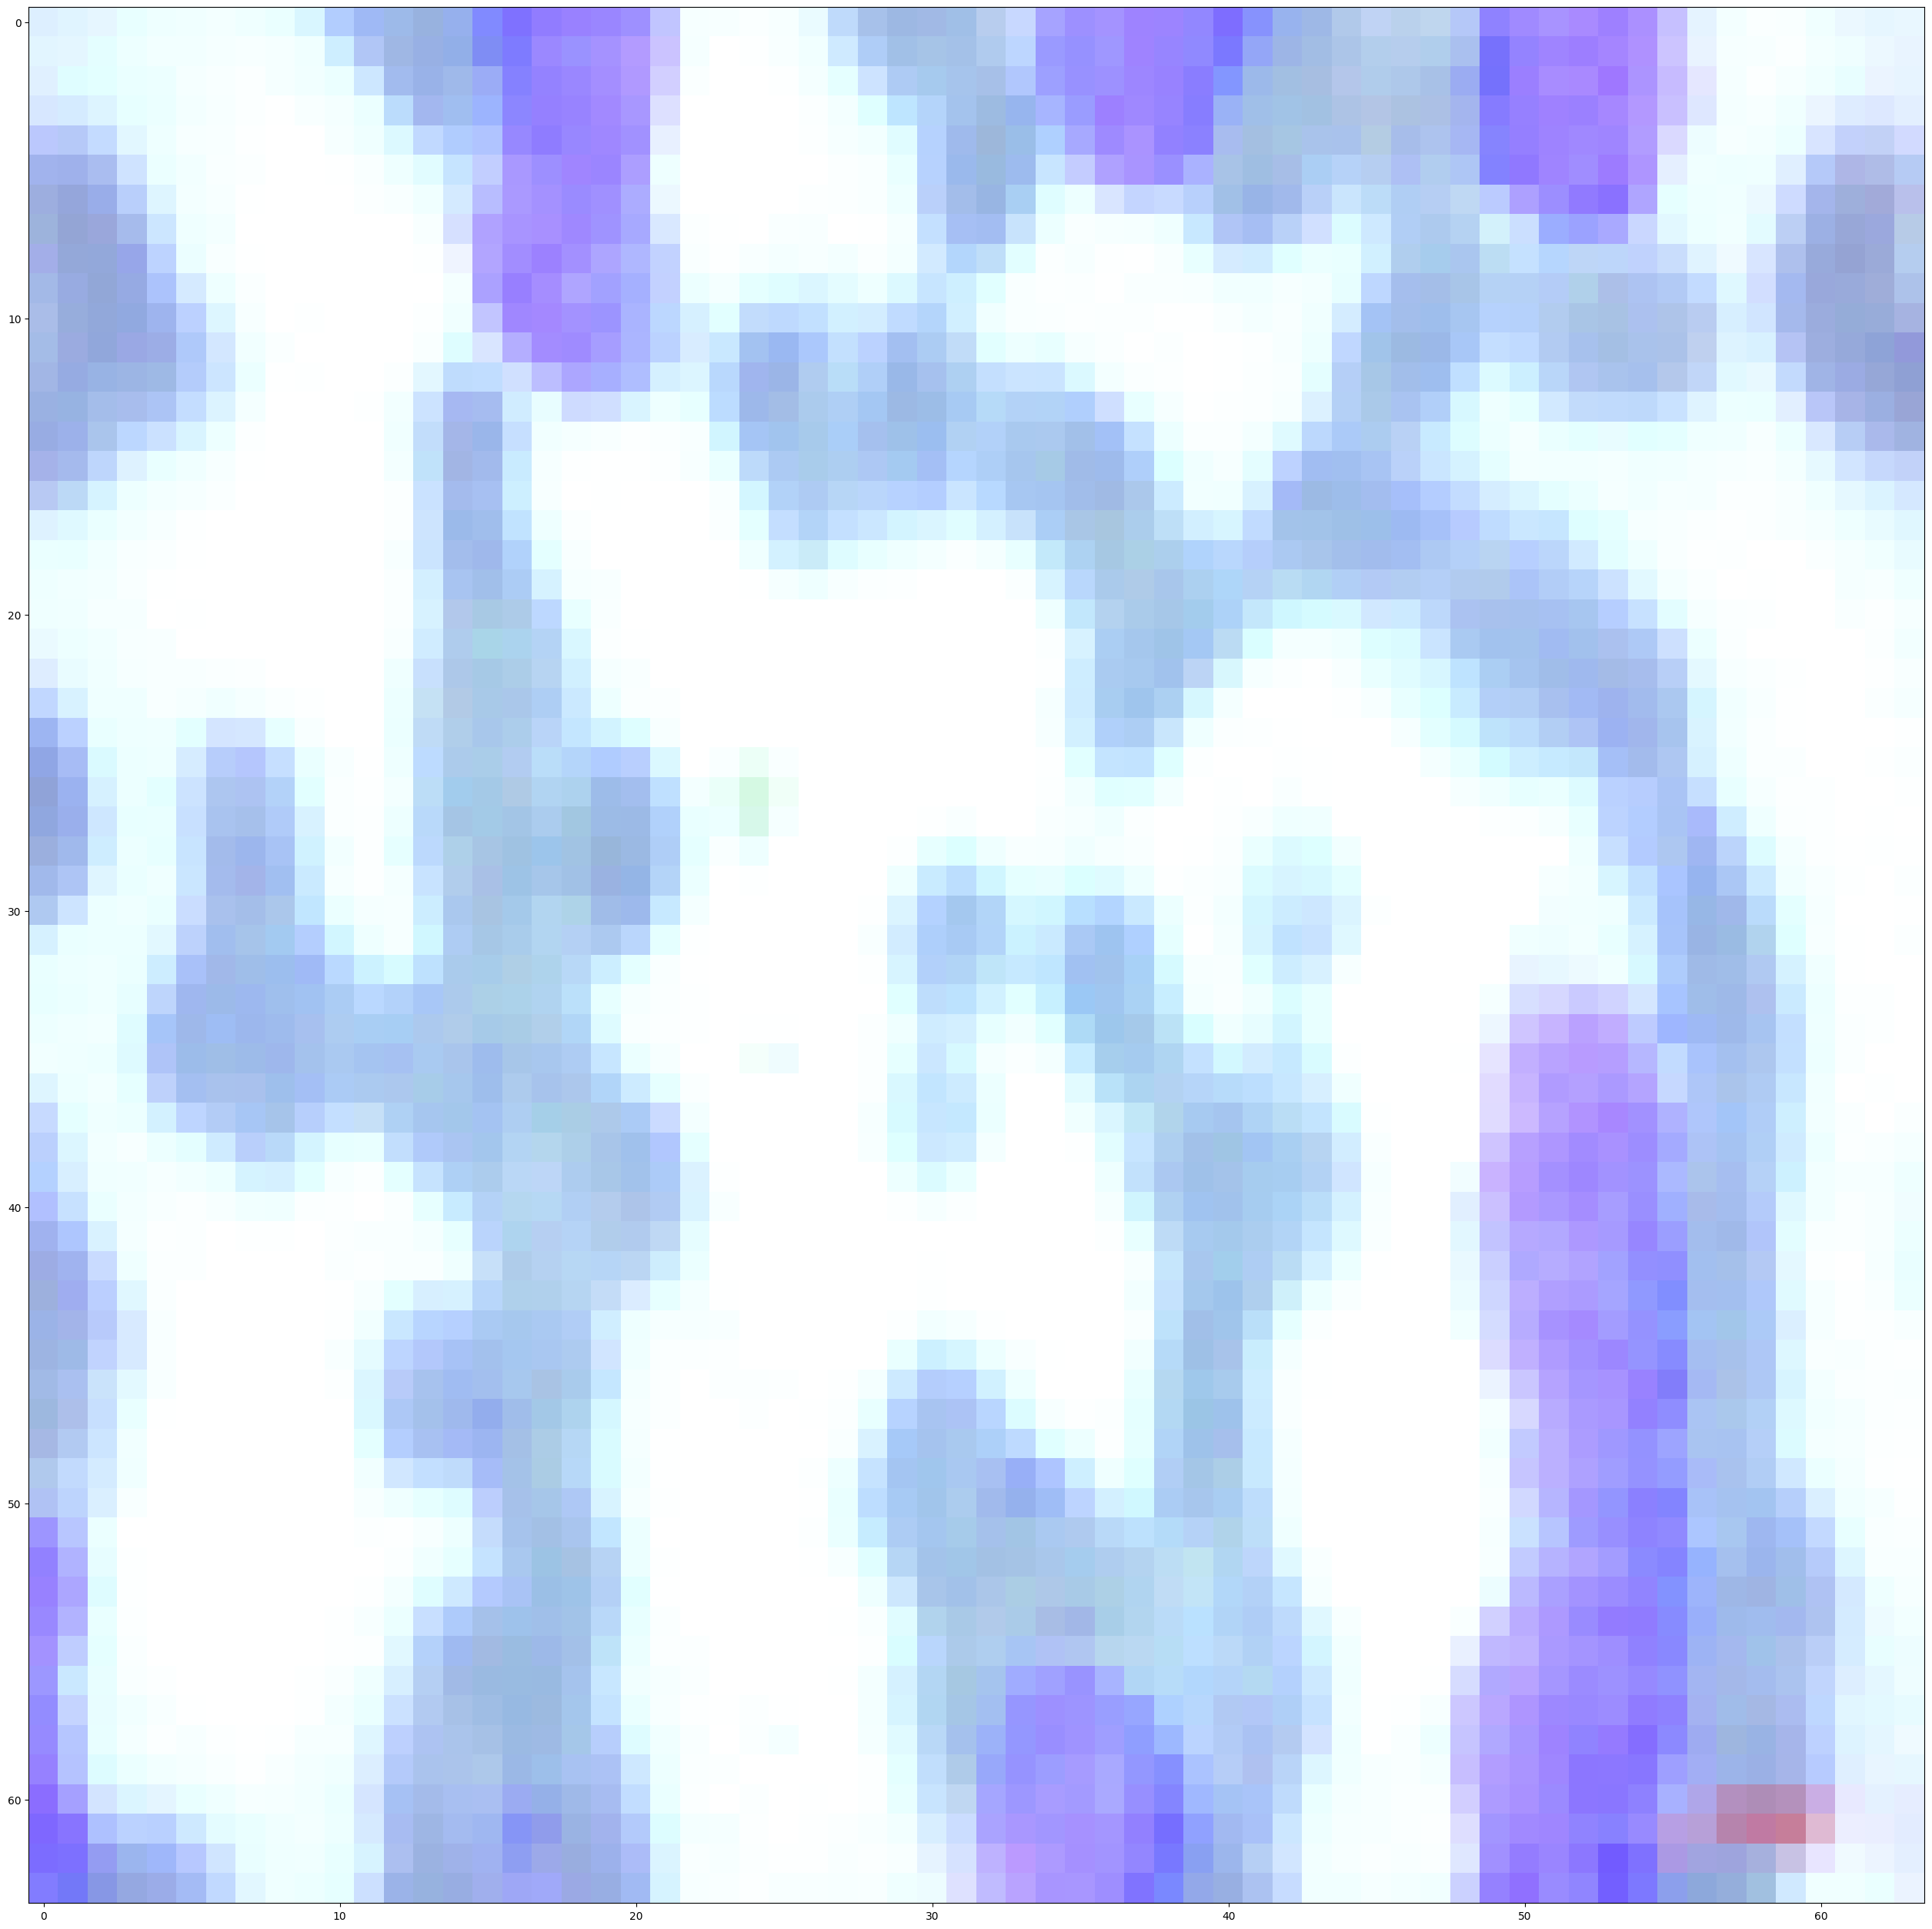

10:08:19 - INFO: Sampling 1 new images....
999it [00:19, 51.32it/s]


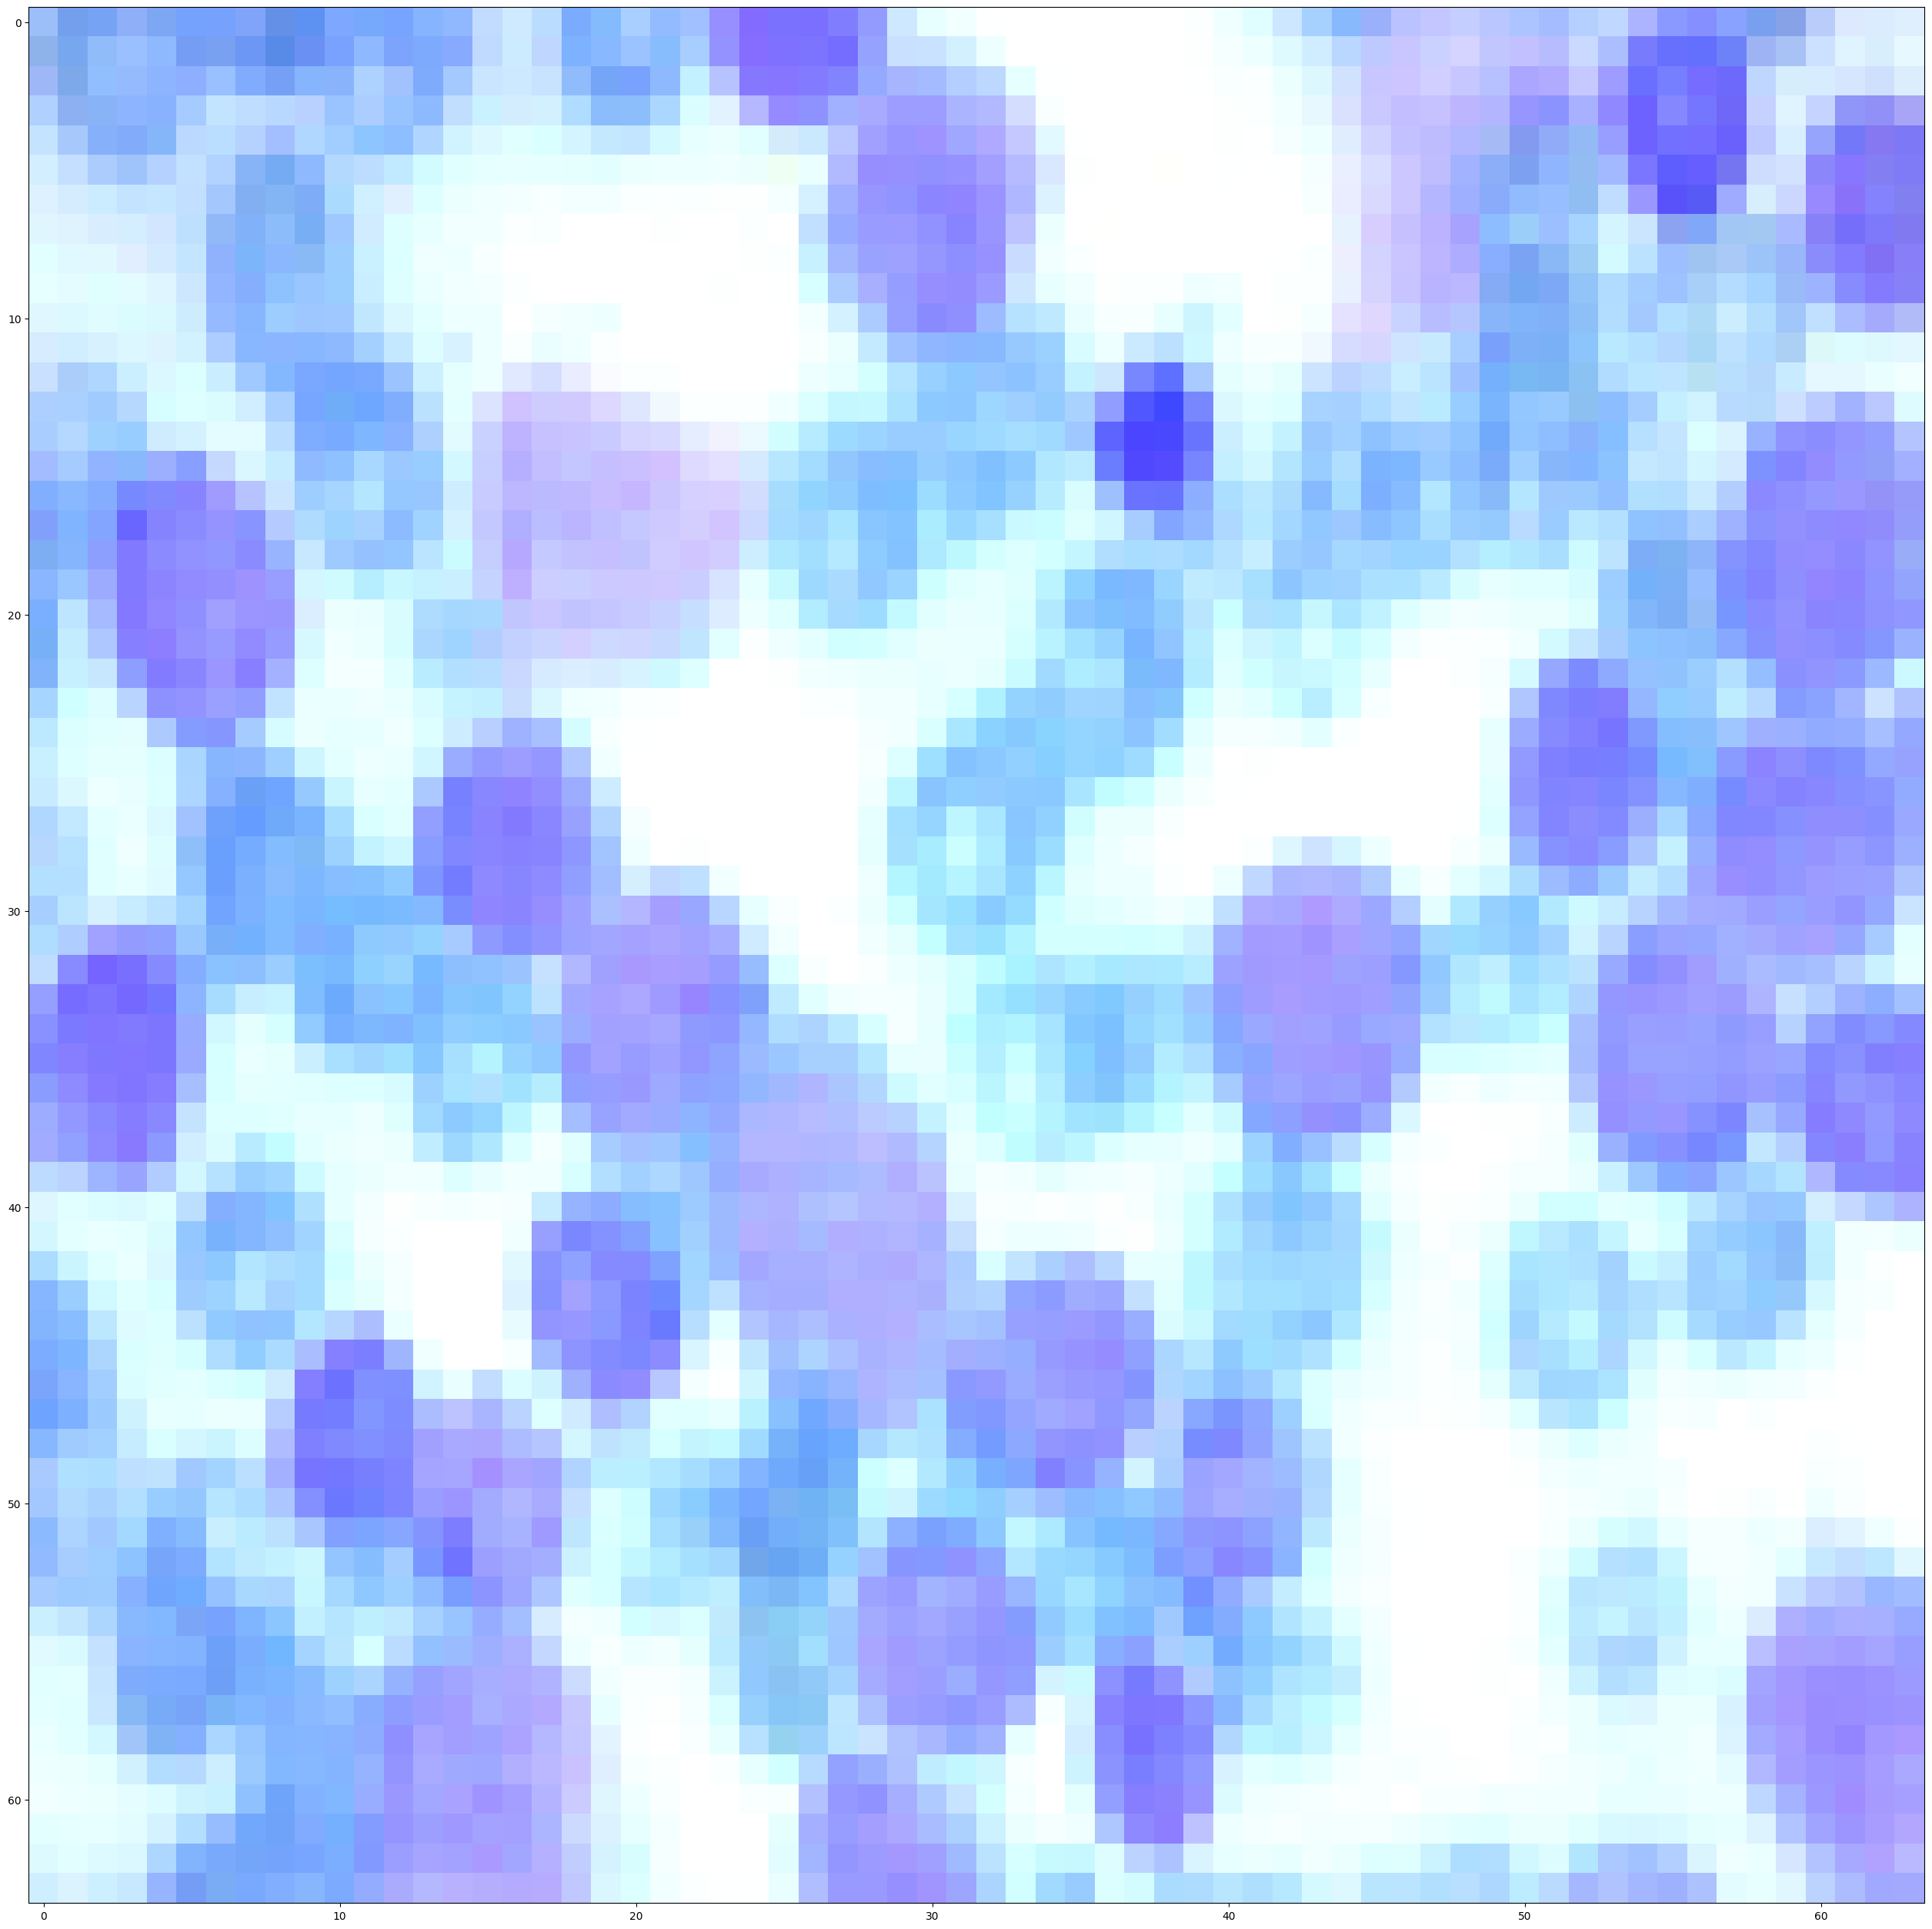

10:08:39 - INFO: Sampling 1 new images....
999it [00:20, 49.43it/s]


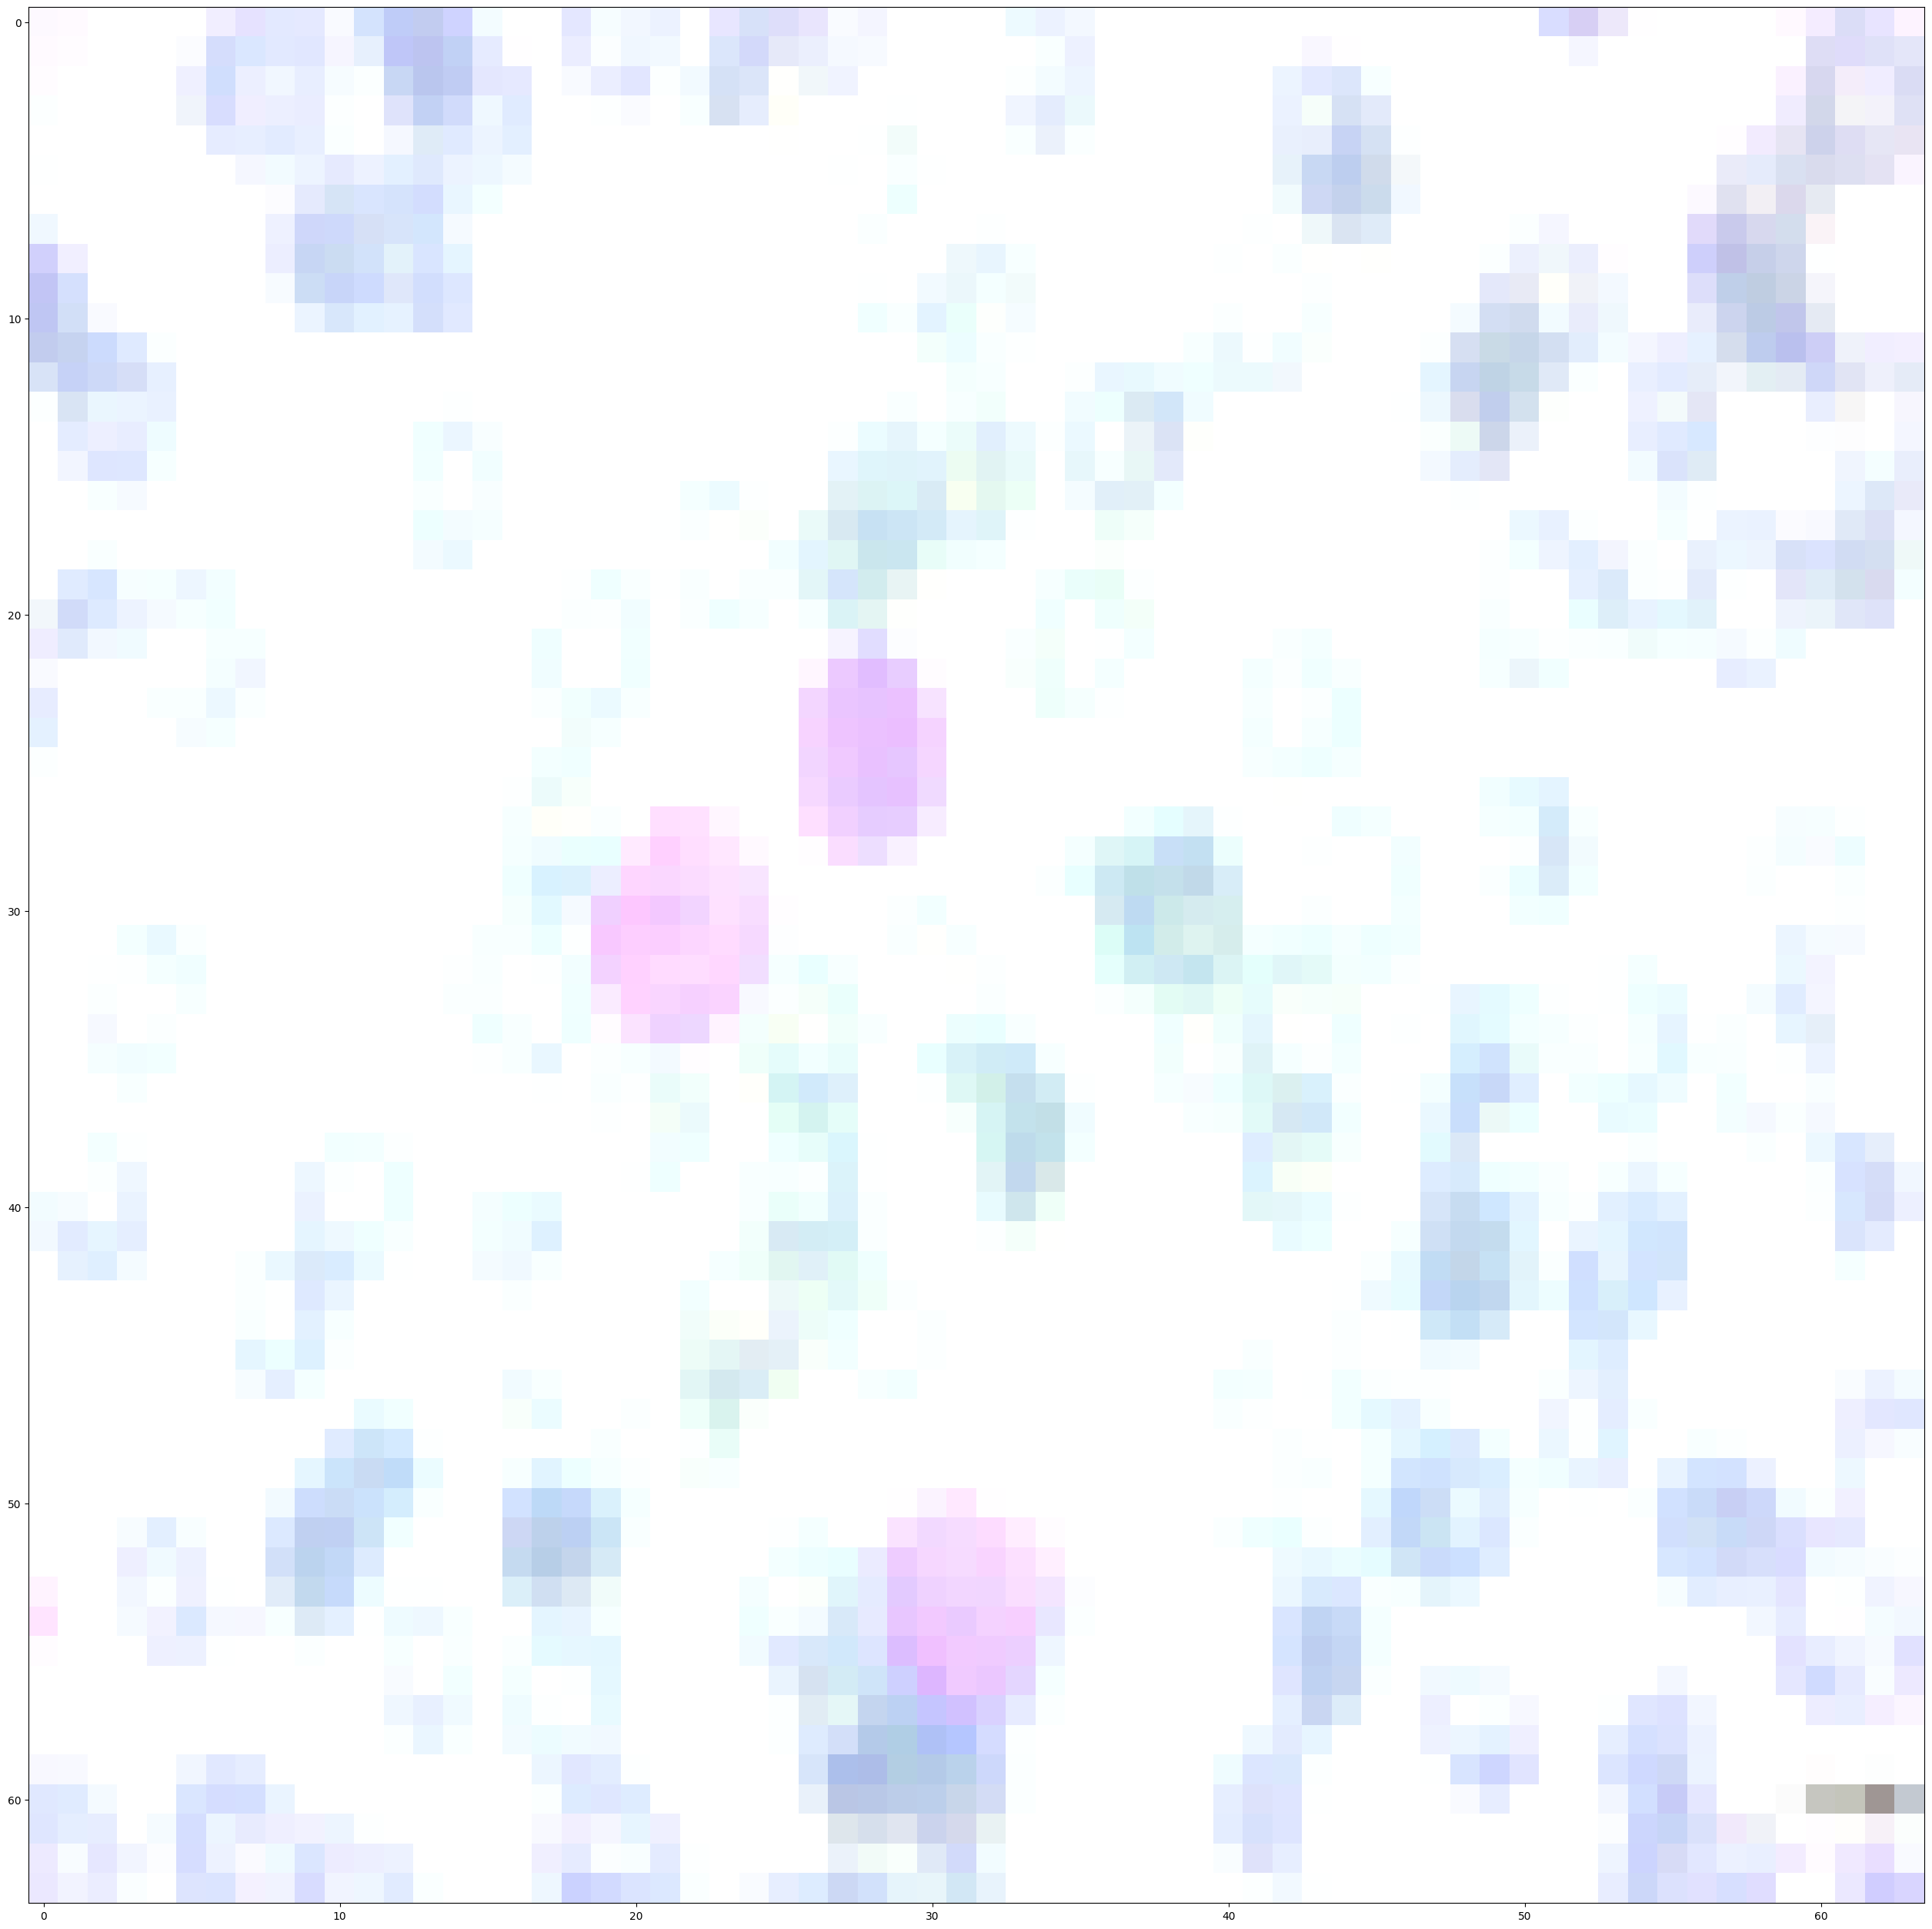

10:09:00 - INFO: Sampling 1 new images....
999it [00:21, 47.44it/s]


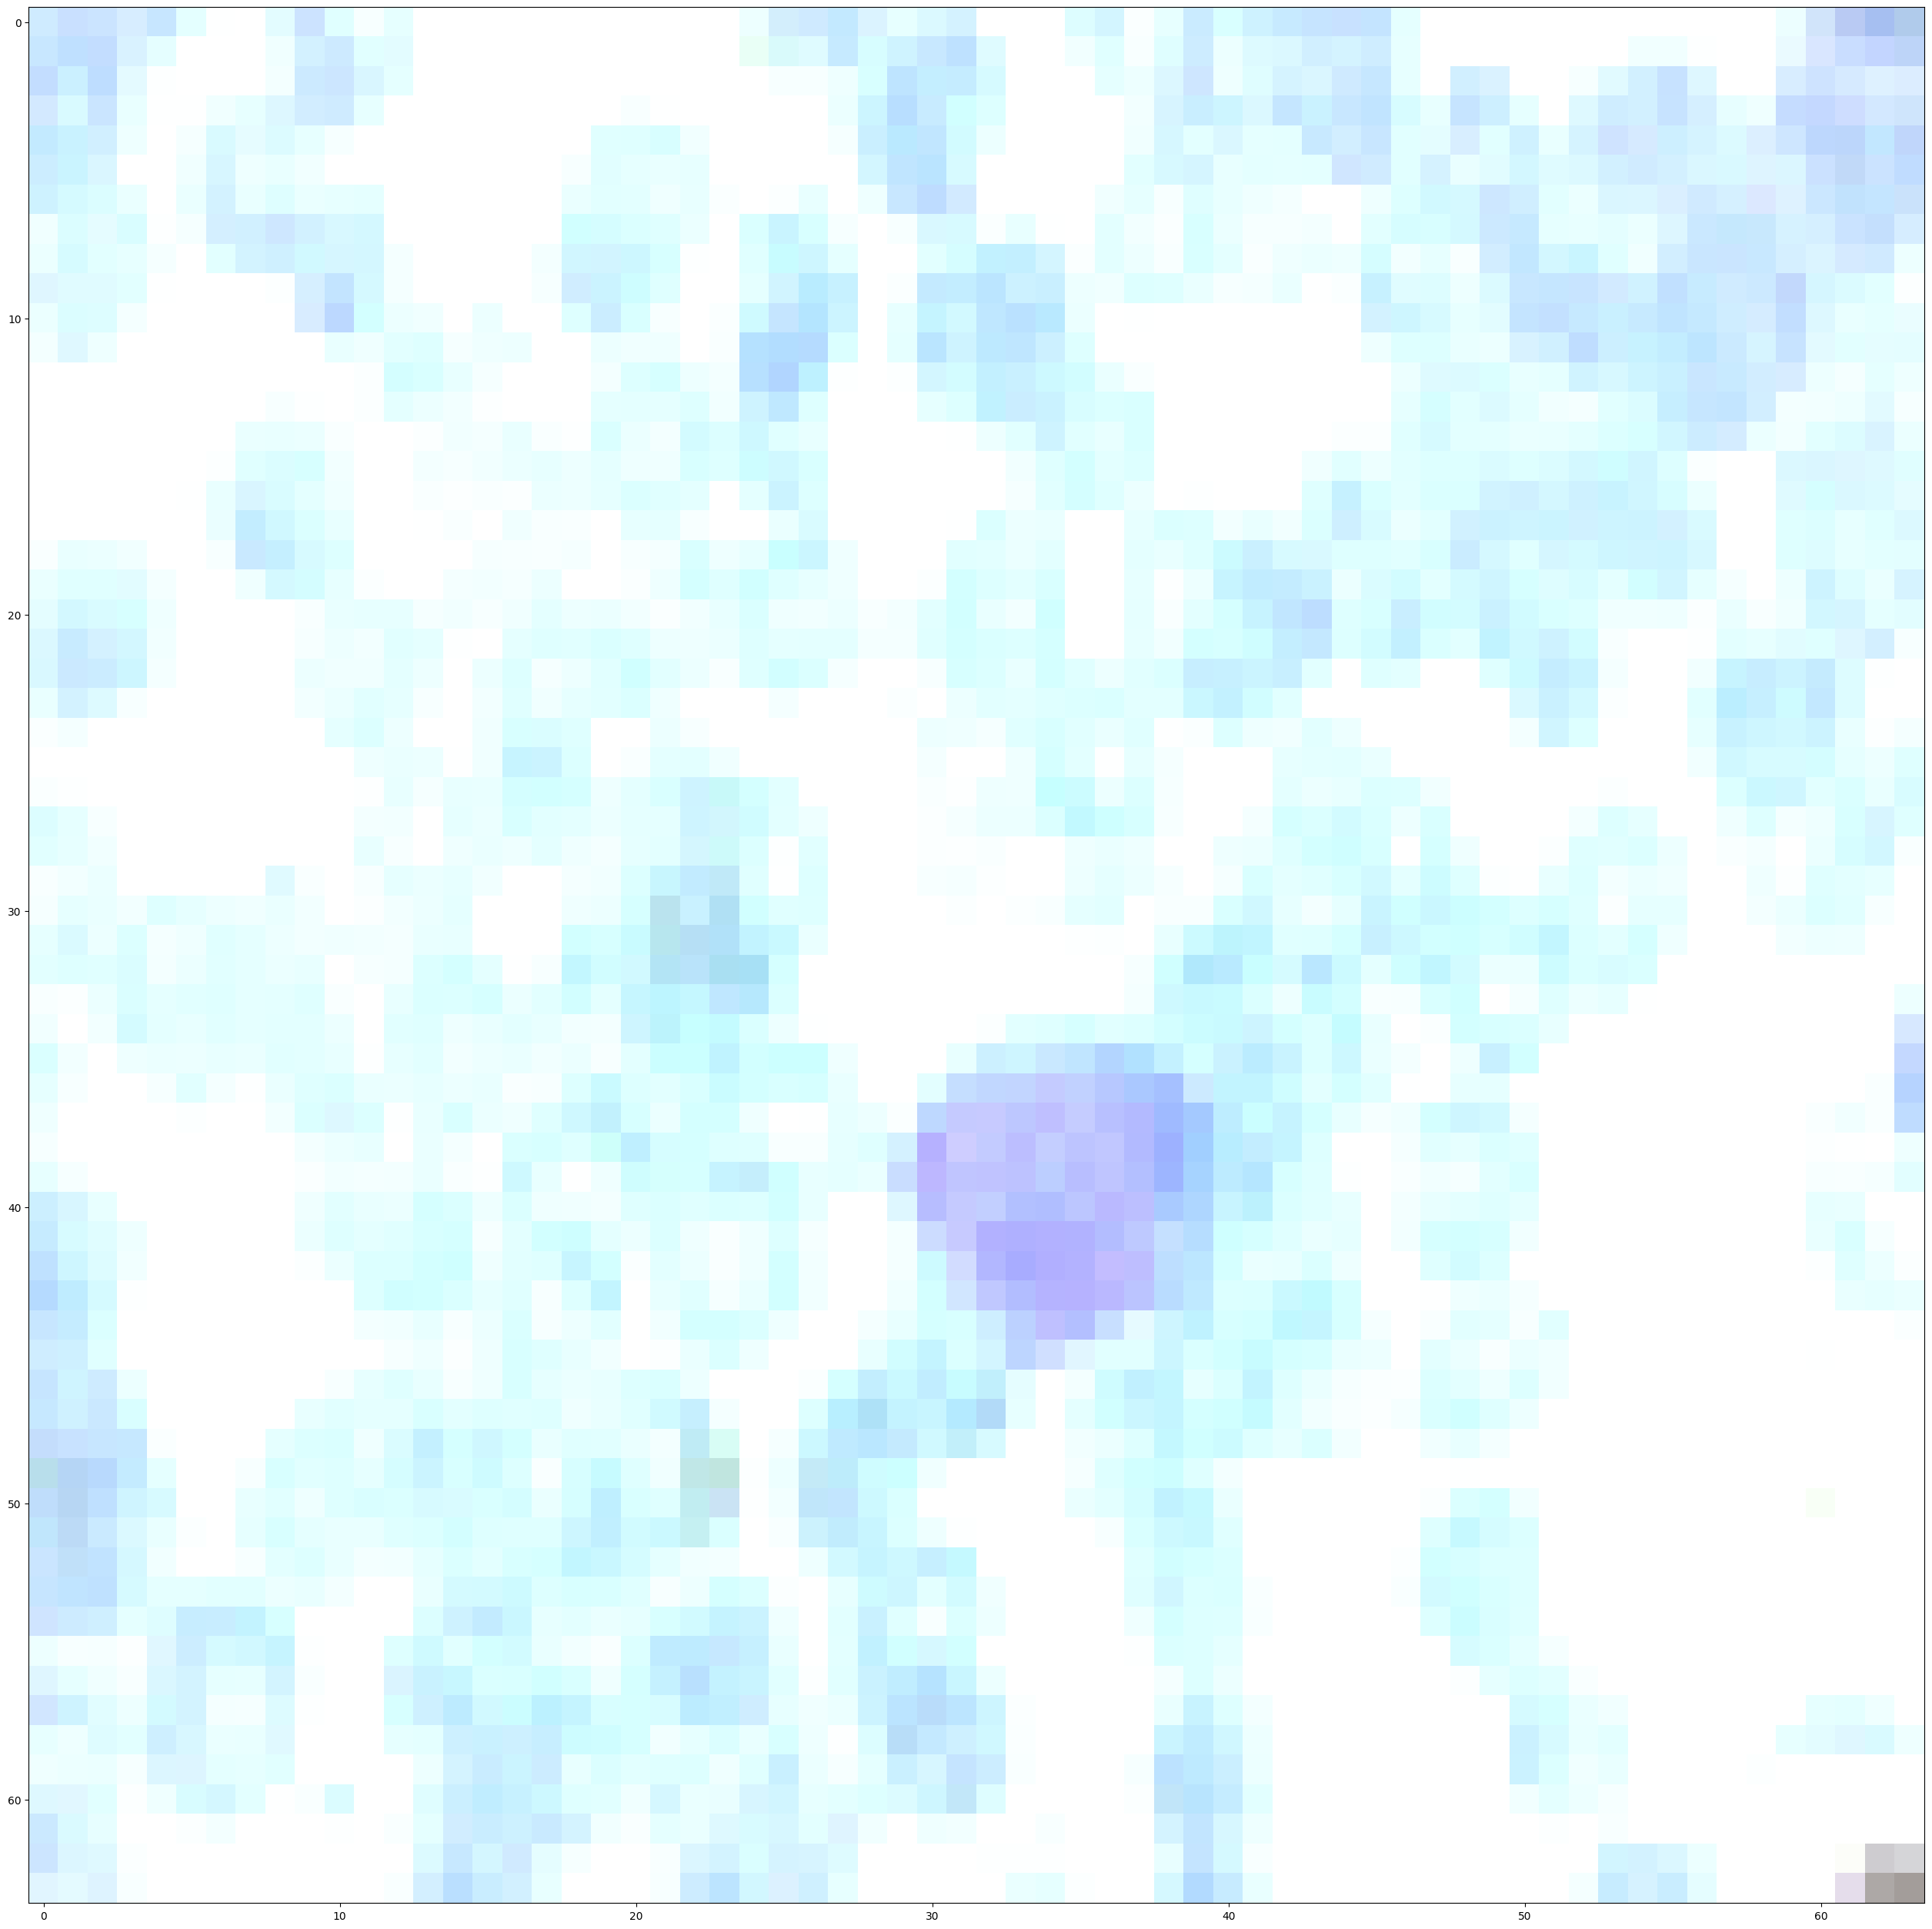

10:09:22 - INFO: Sampling 1 new images....
999it [00:21, 47.17it/s]


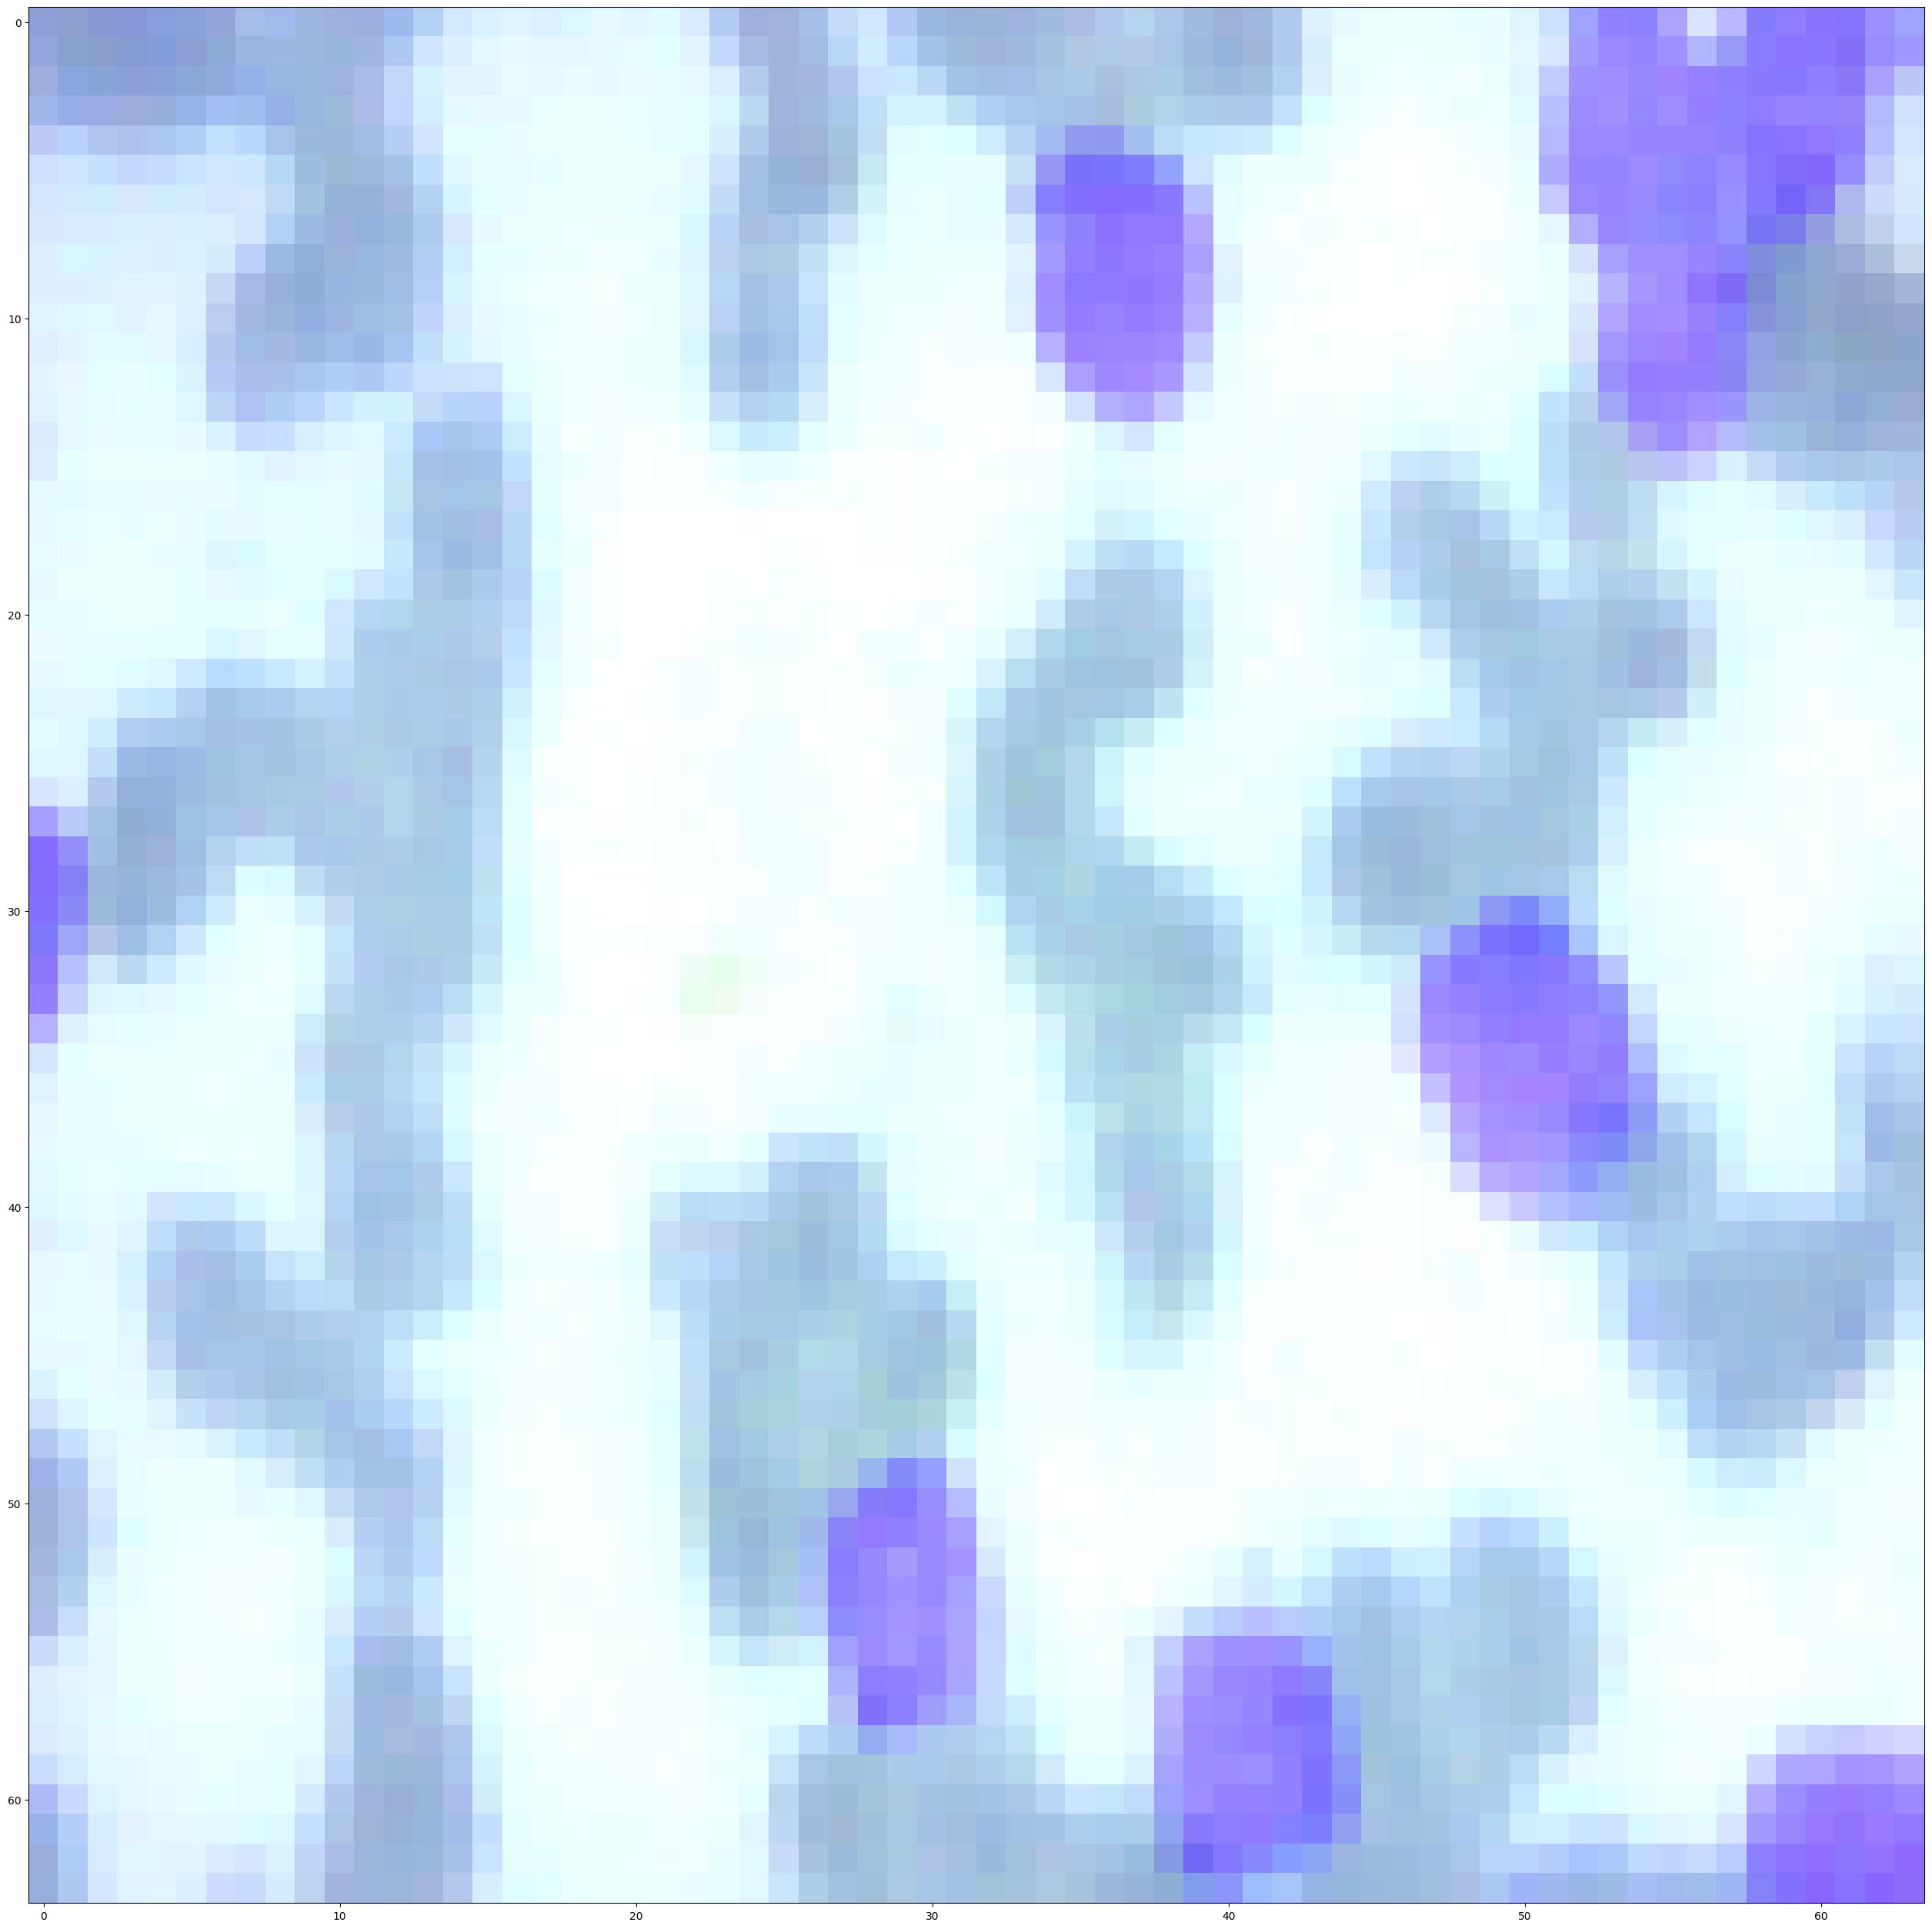

10:09:44 - INFO: Sampling 1 new images....
999it [00:20, 49.86it/s]


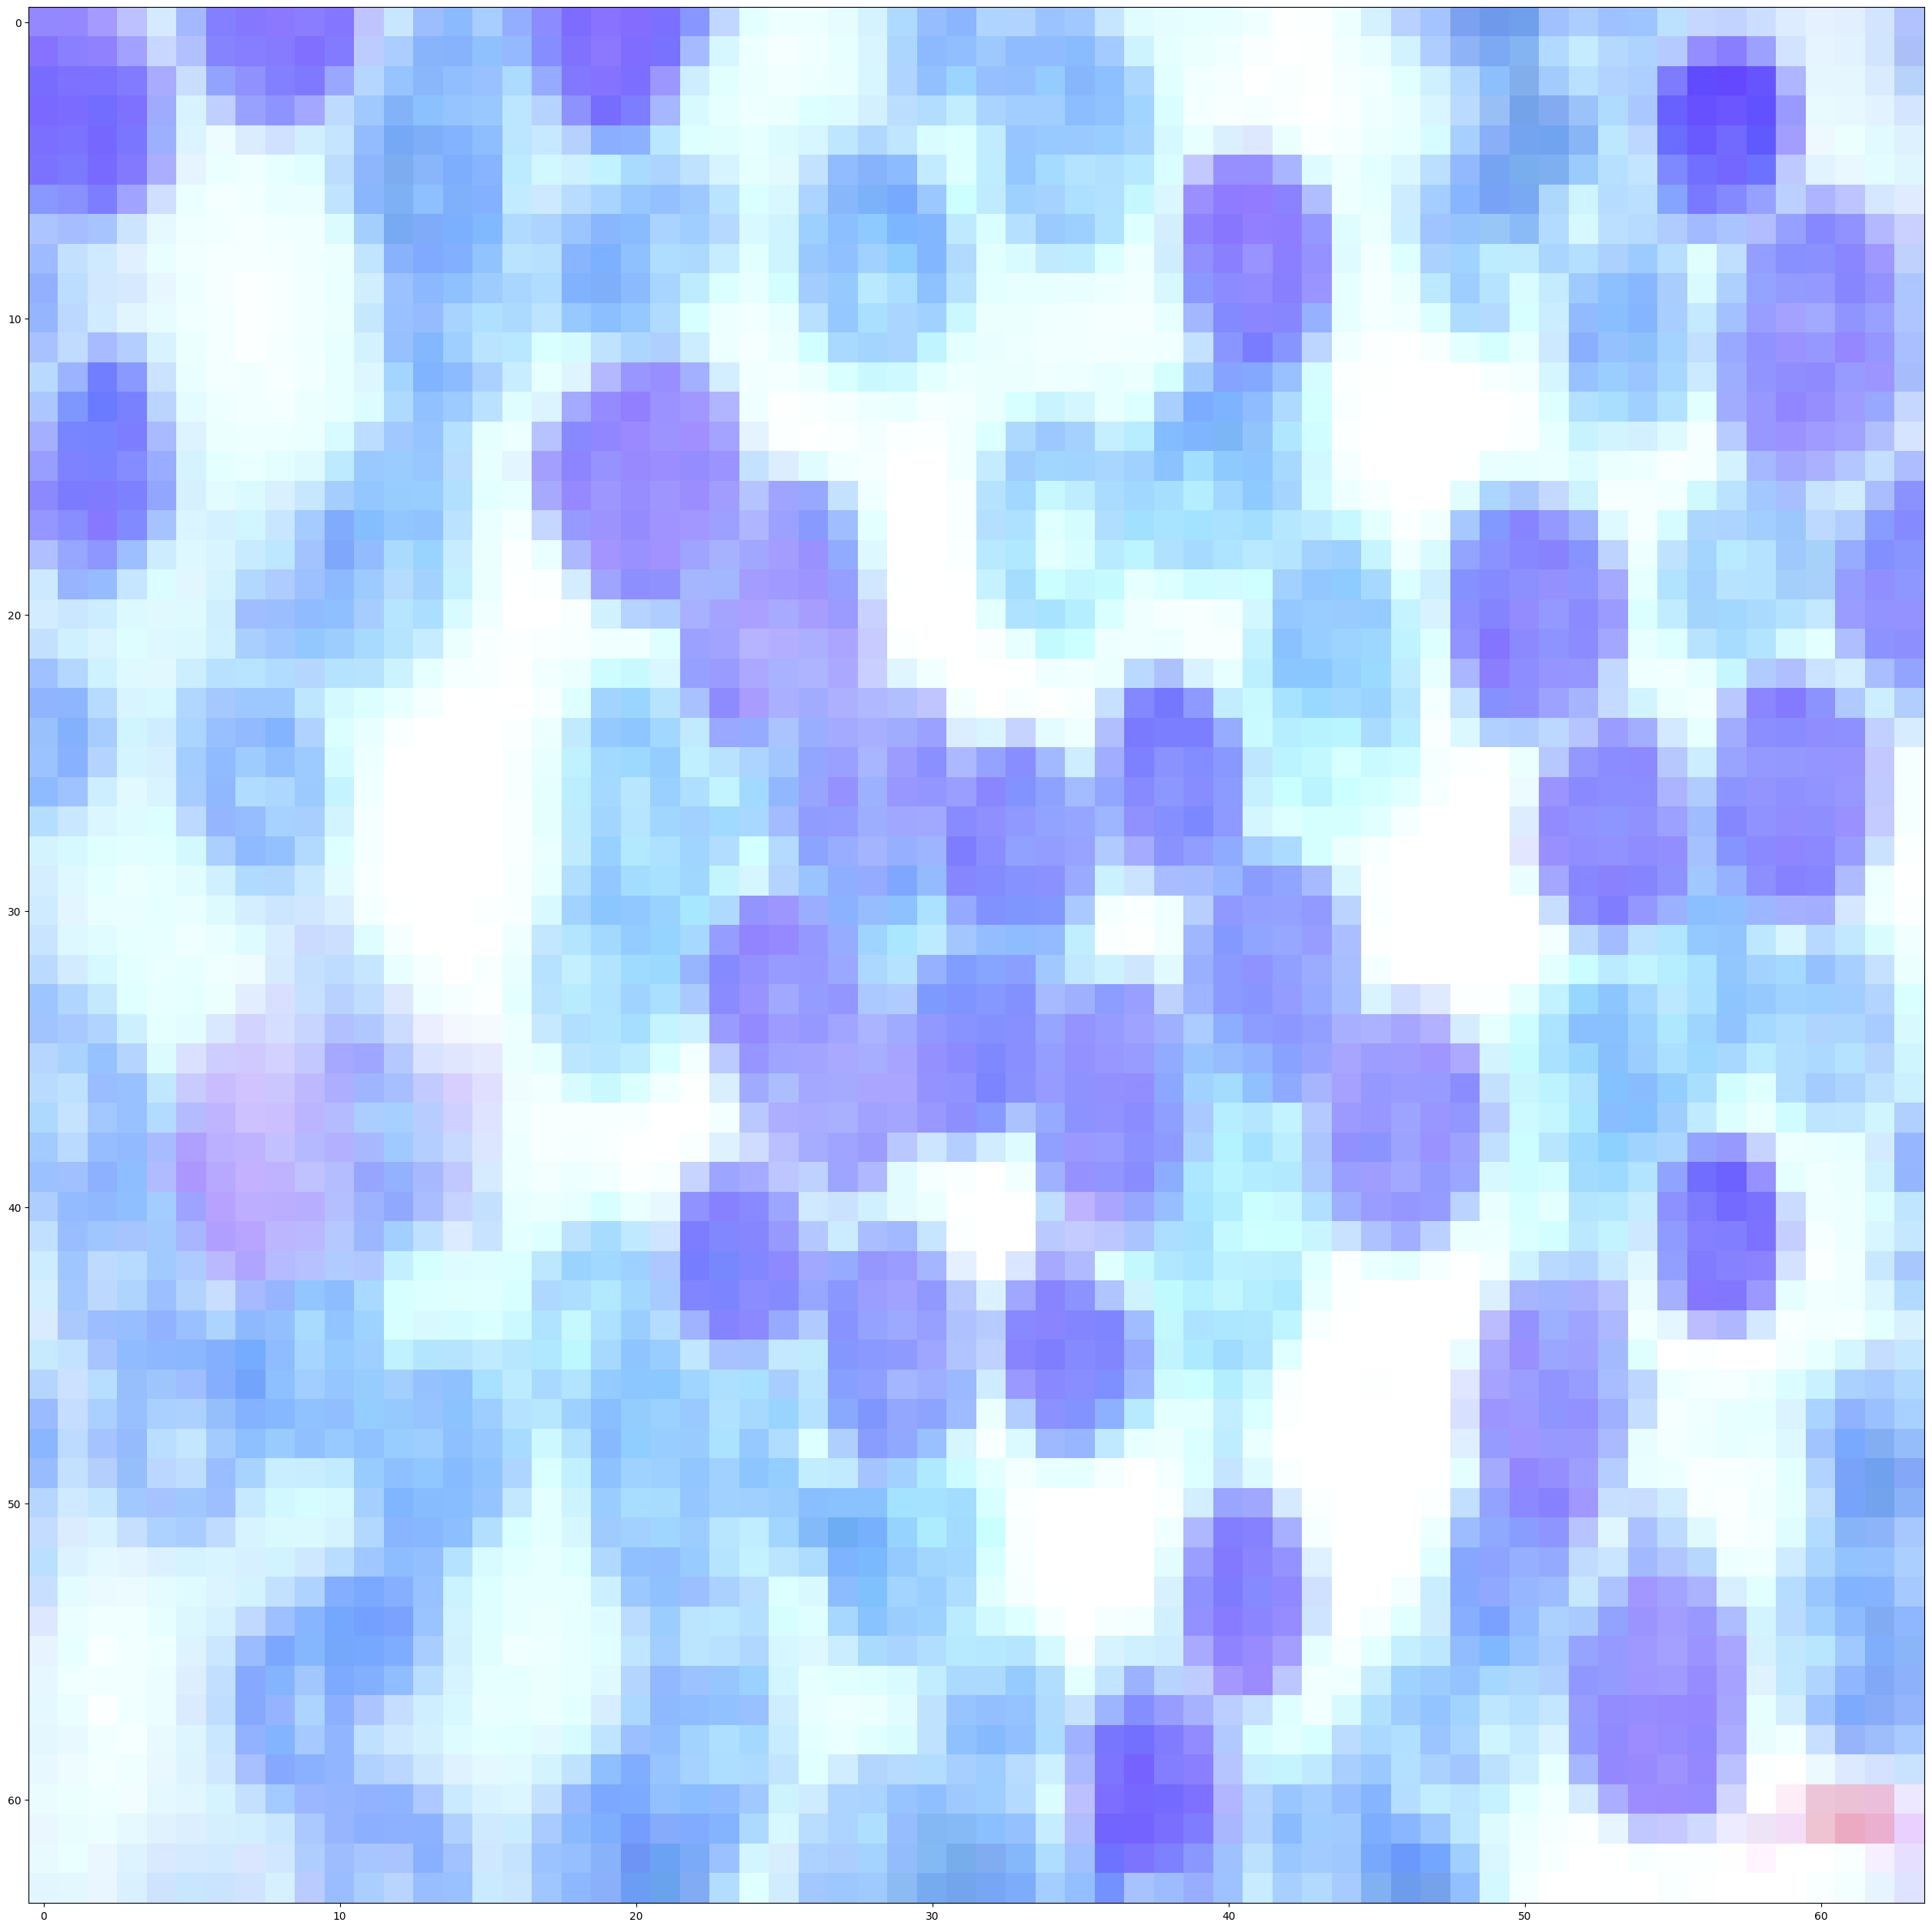

10:10:04 - INFO: Sampling 1 new images....
999it [00:18, 54.97it/s]


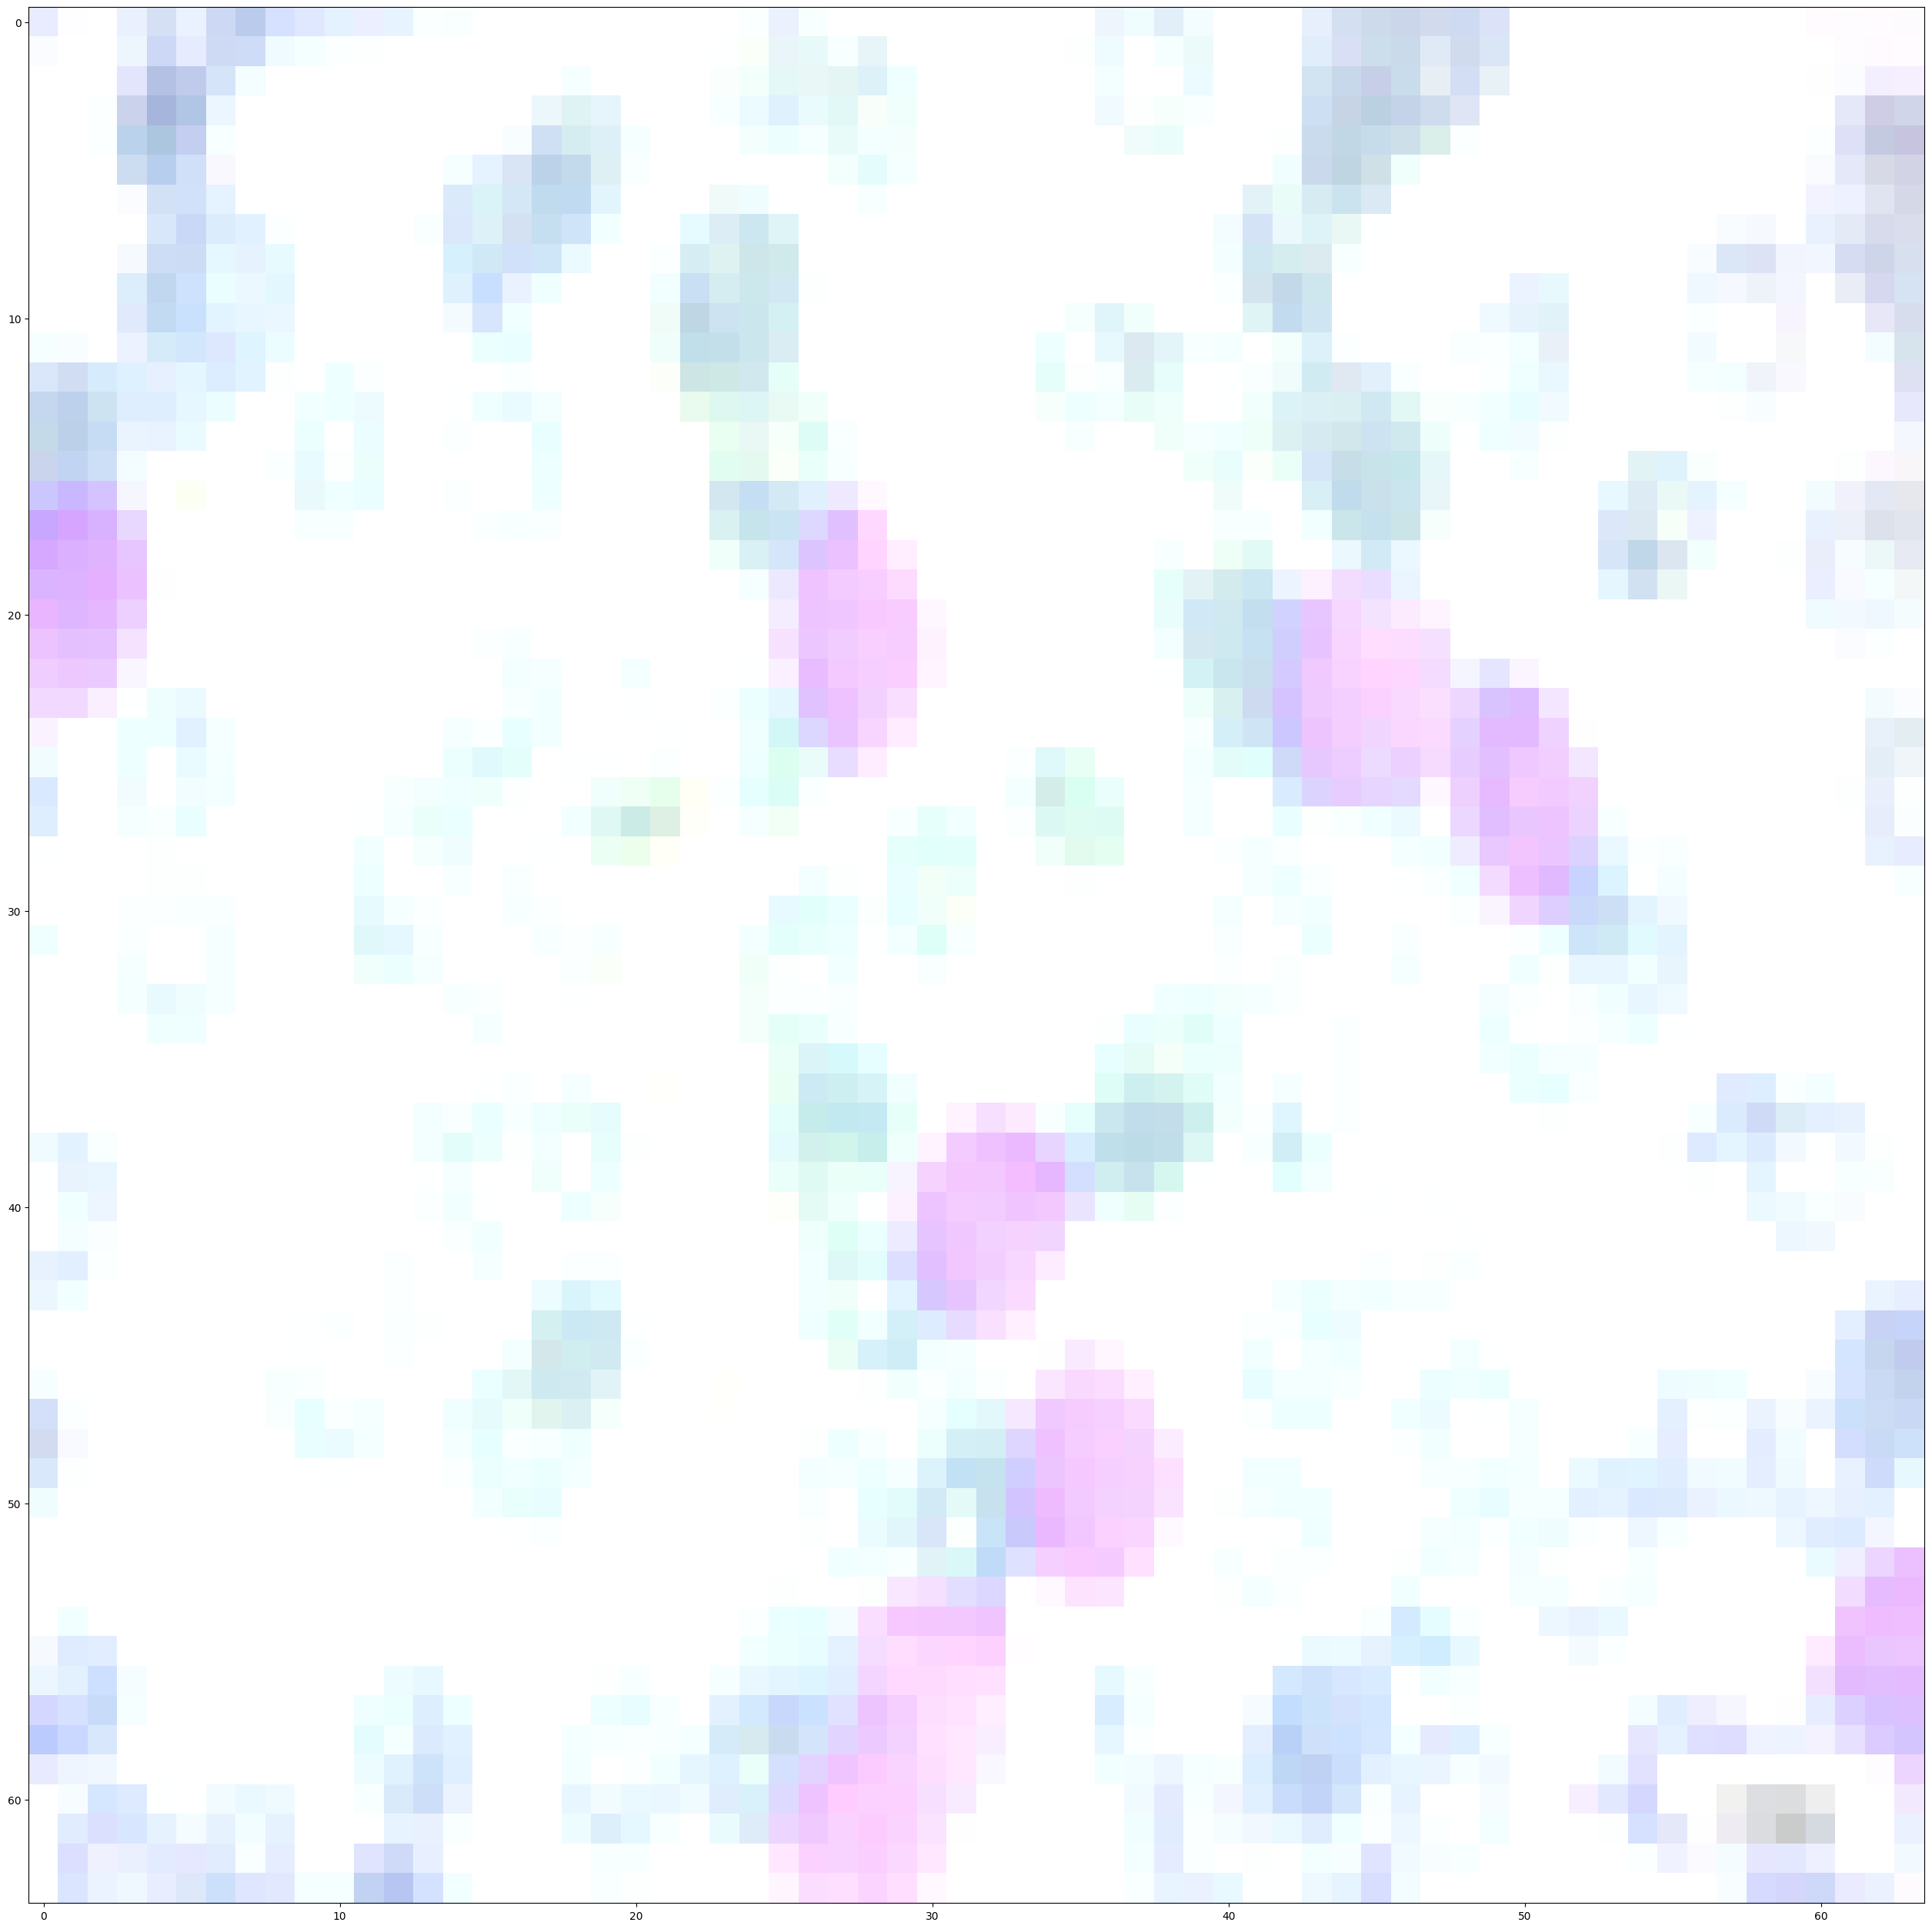

10:10:23 - INFO: Sampling 1 new images....
999it [00:20, 49.69it/s]


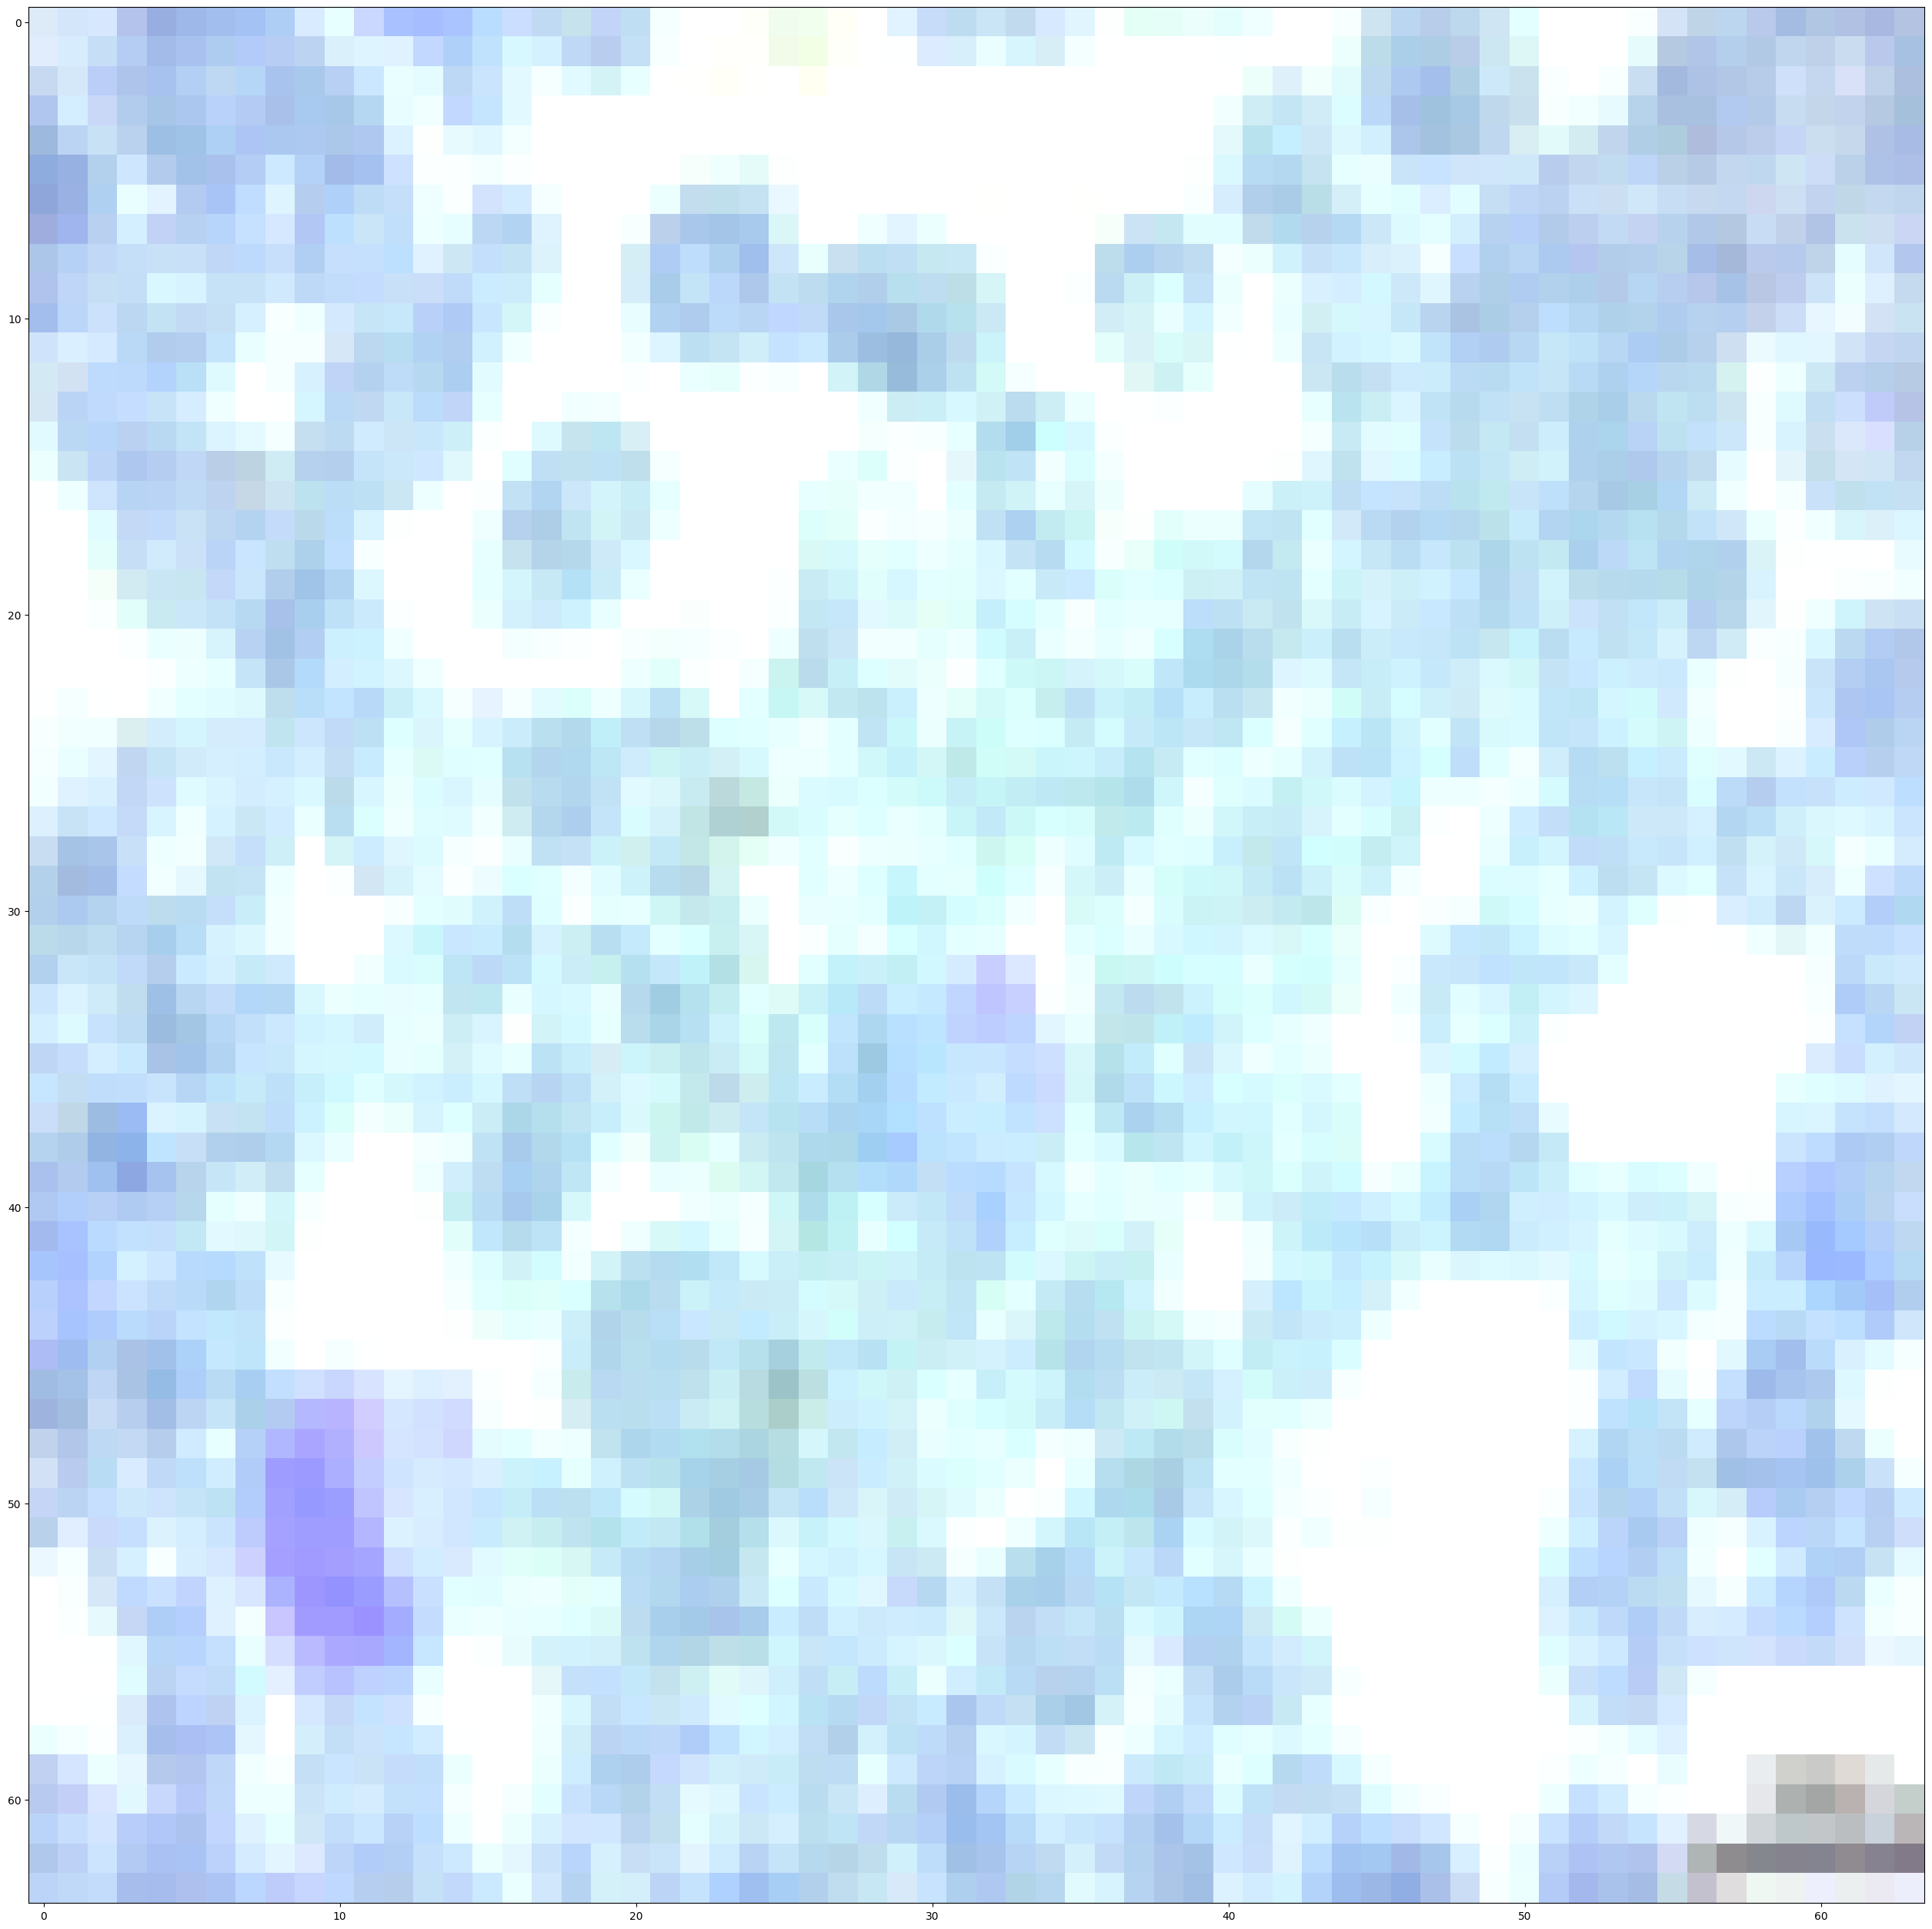

10:10:44 - INFO: Sampling 1 new images....
999it [00:18, 53.18it/s]


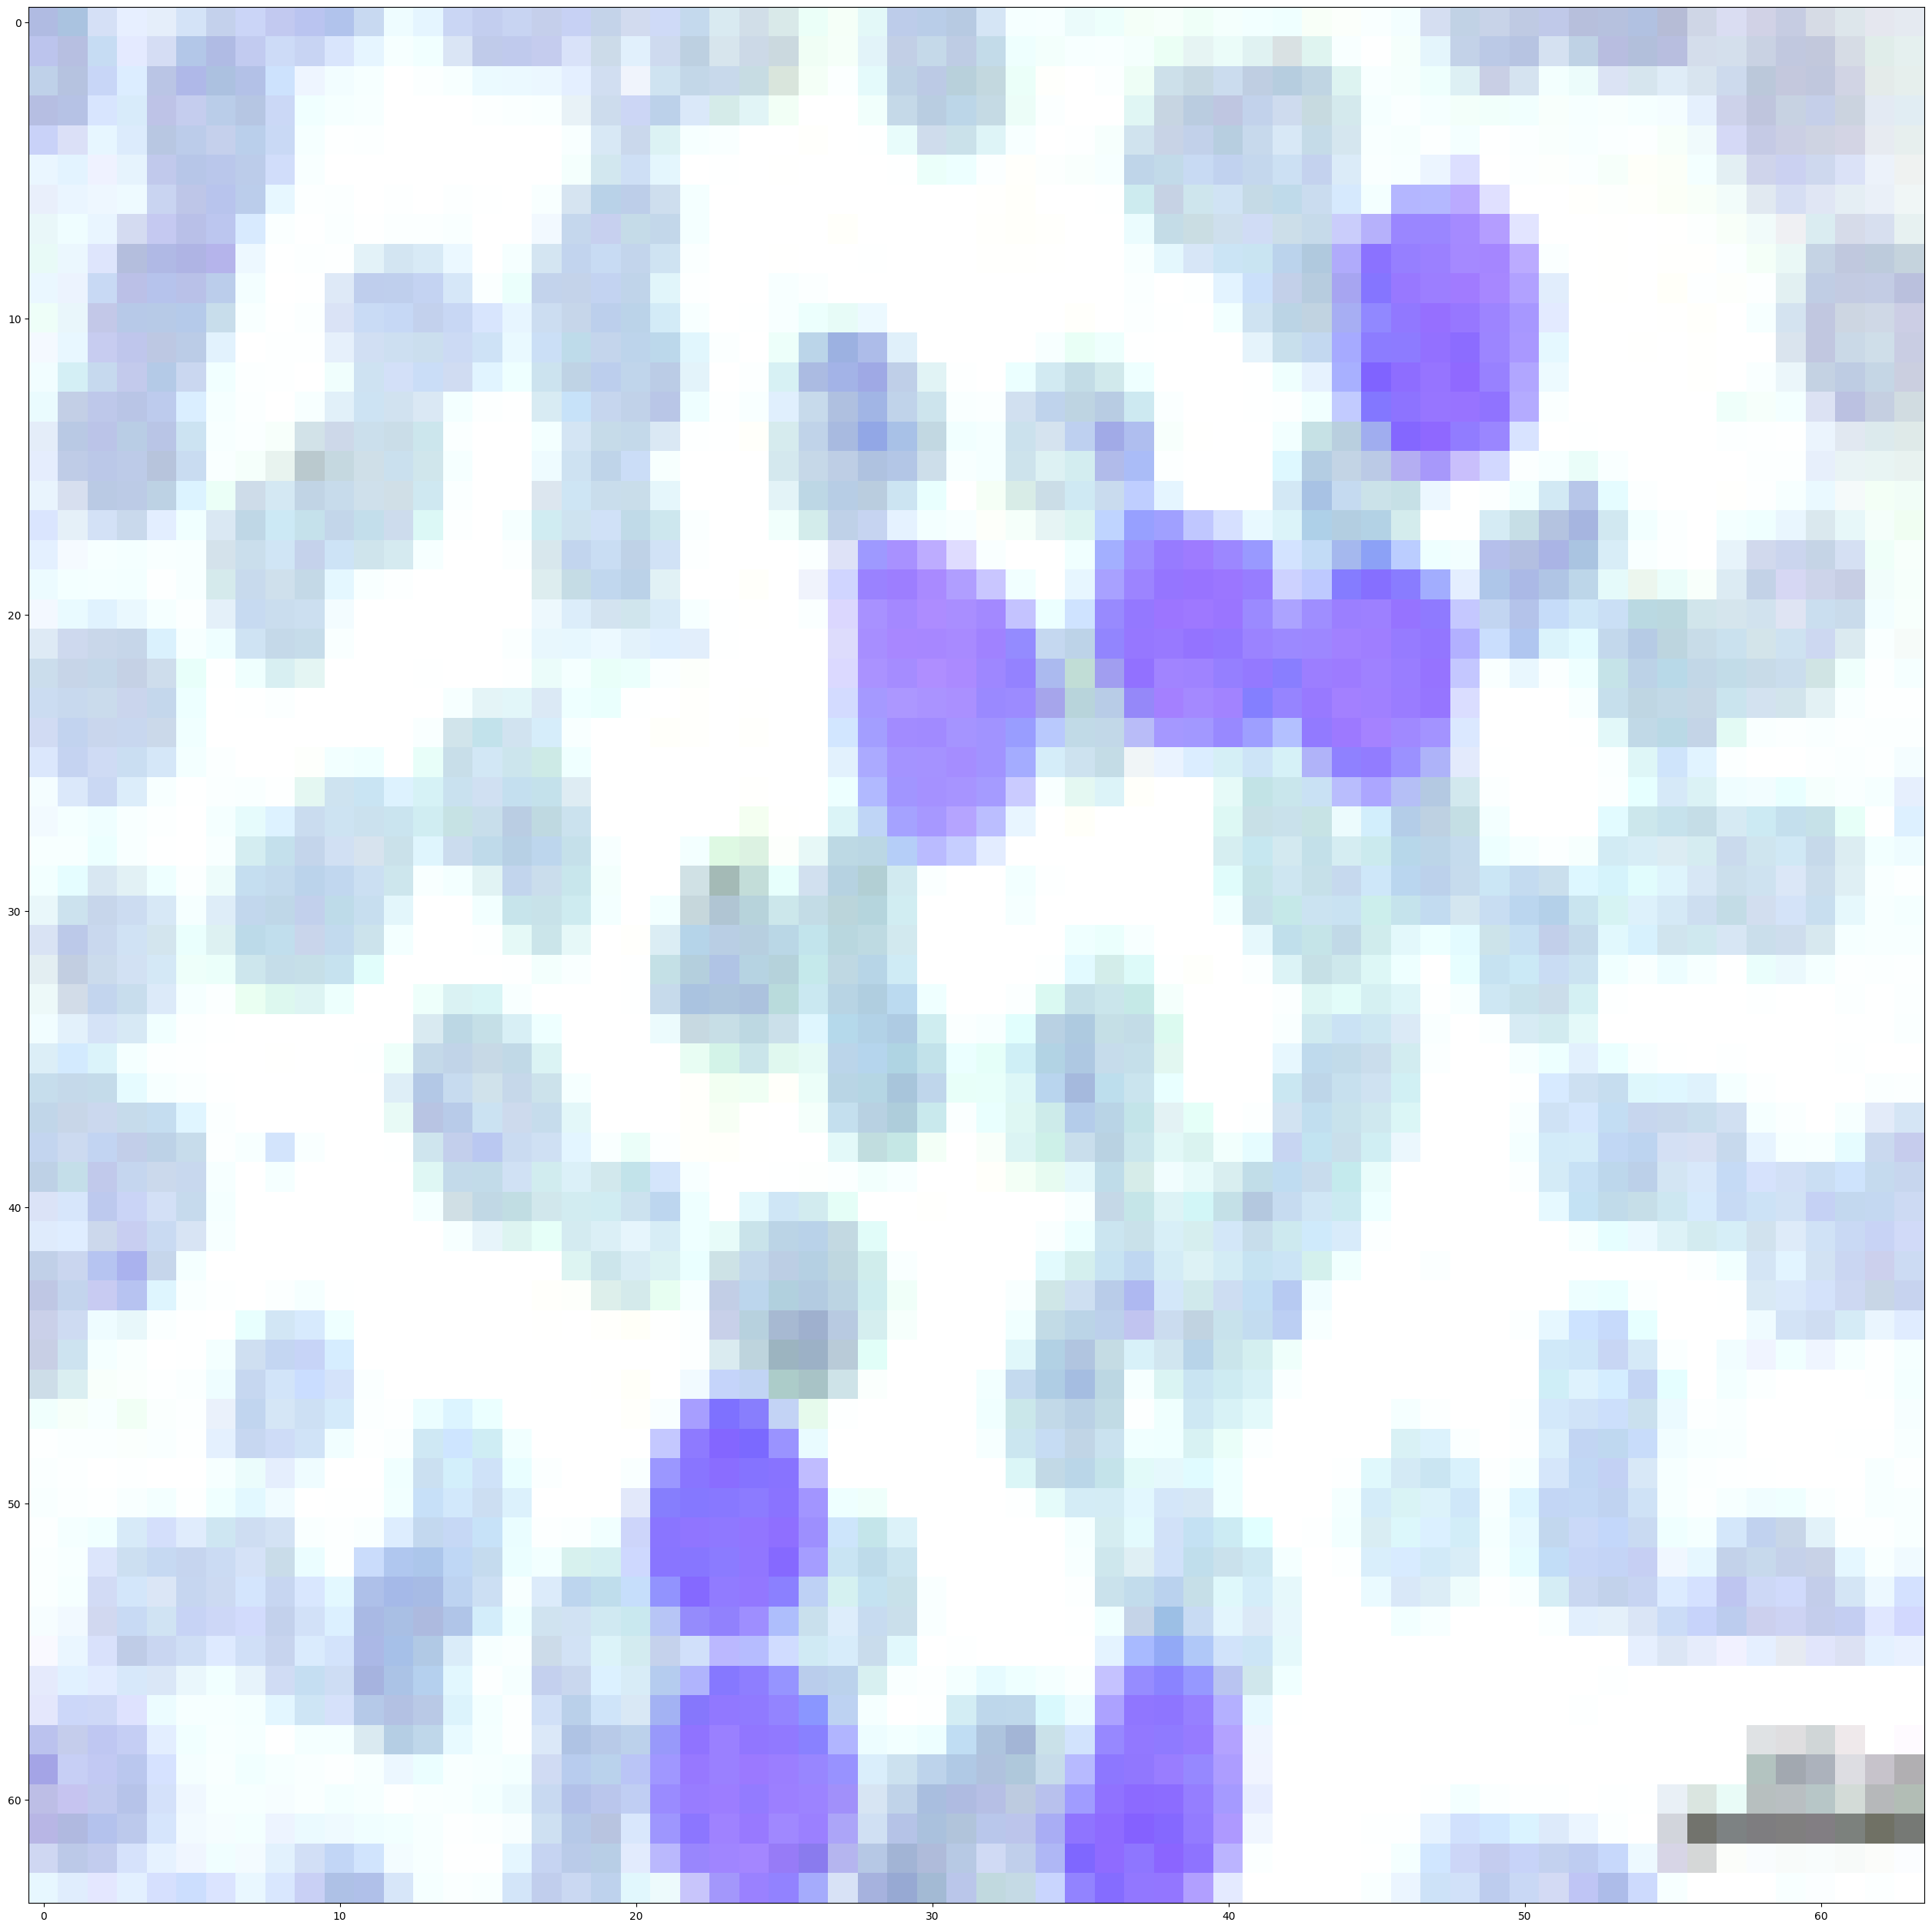

10:11:03 - INFO: Sampling 1 new images....
999it [00:18, 55.02it/s]


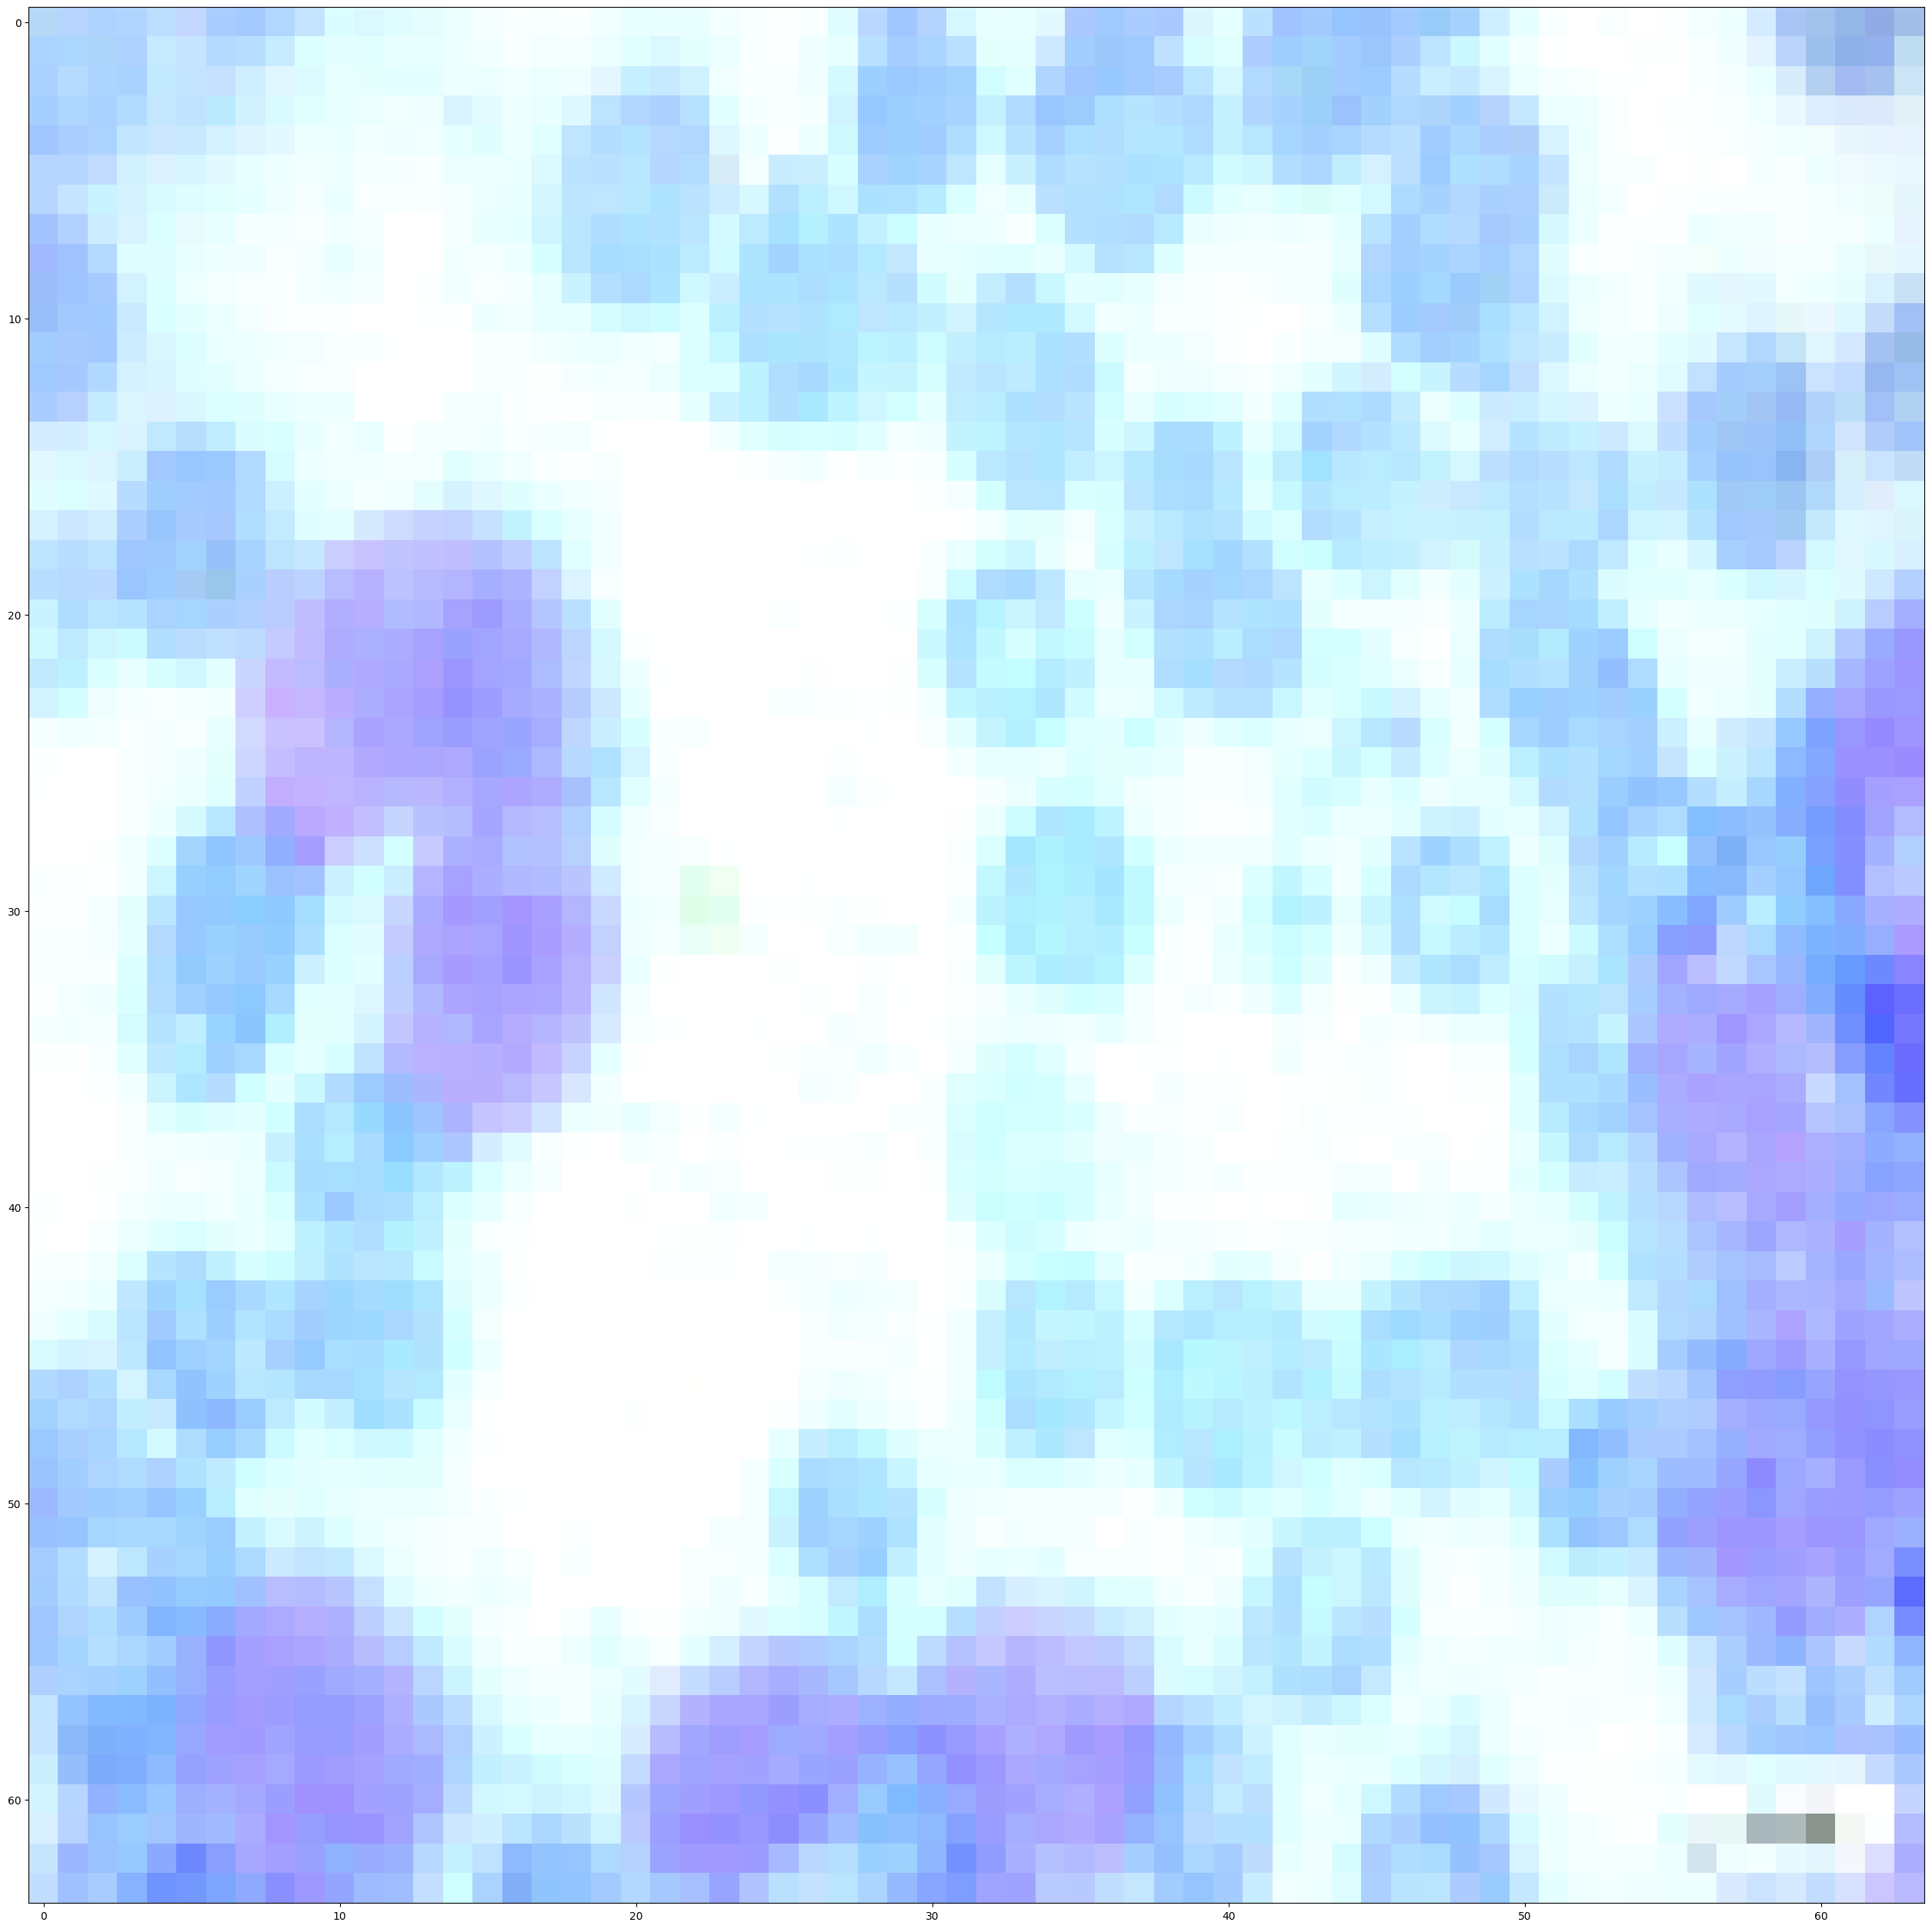

10:11:21 - INFO: Sampling 1 new images....
999it [00:19, 51.78it/s]


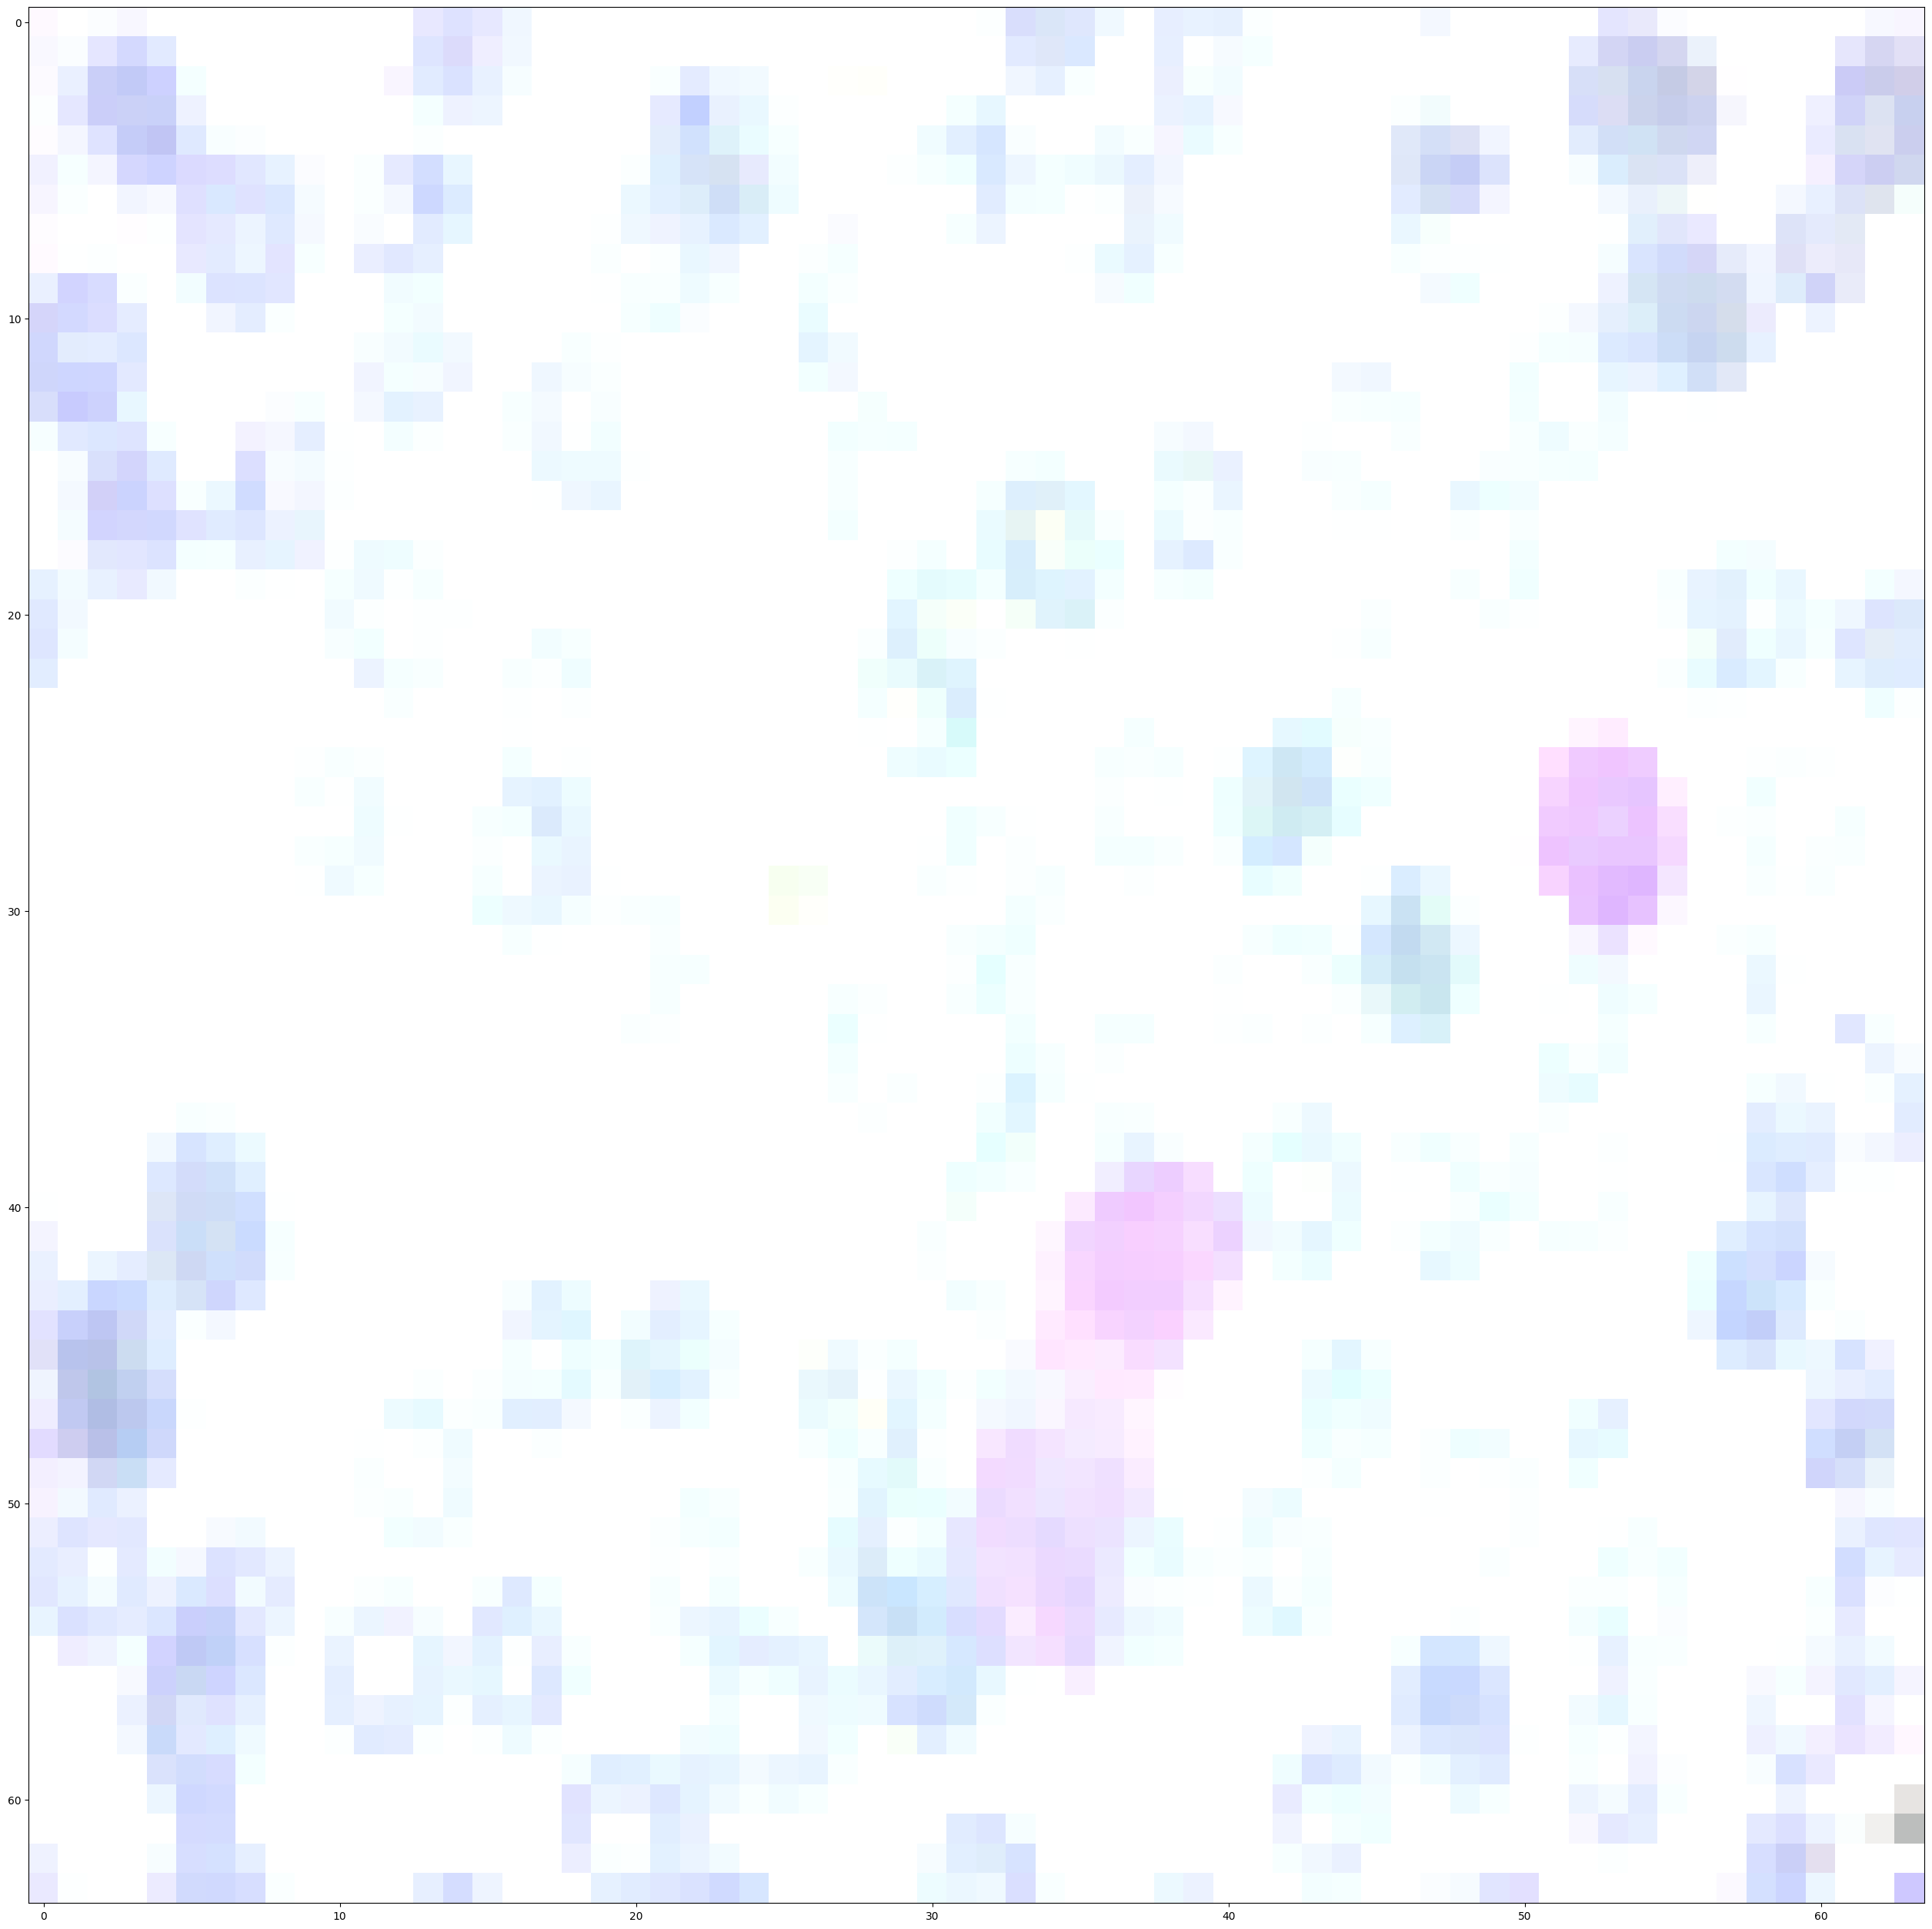

10:11:41 - INFO: Sampling 1 new images....
999it [00:18, 54.64it/s]


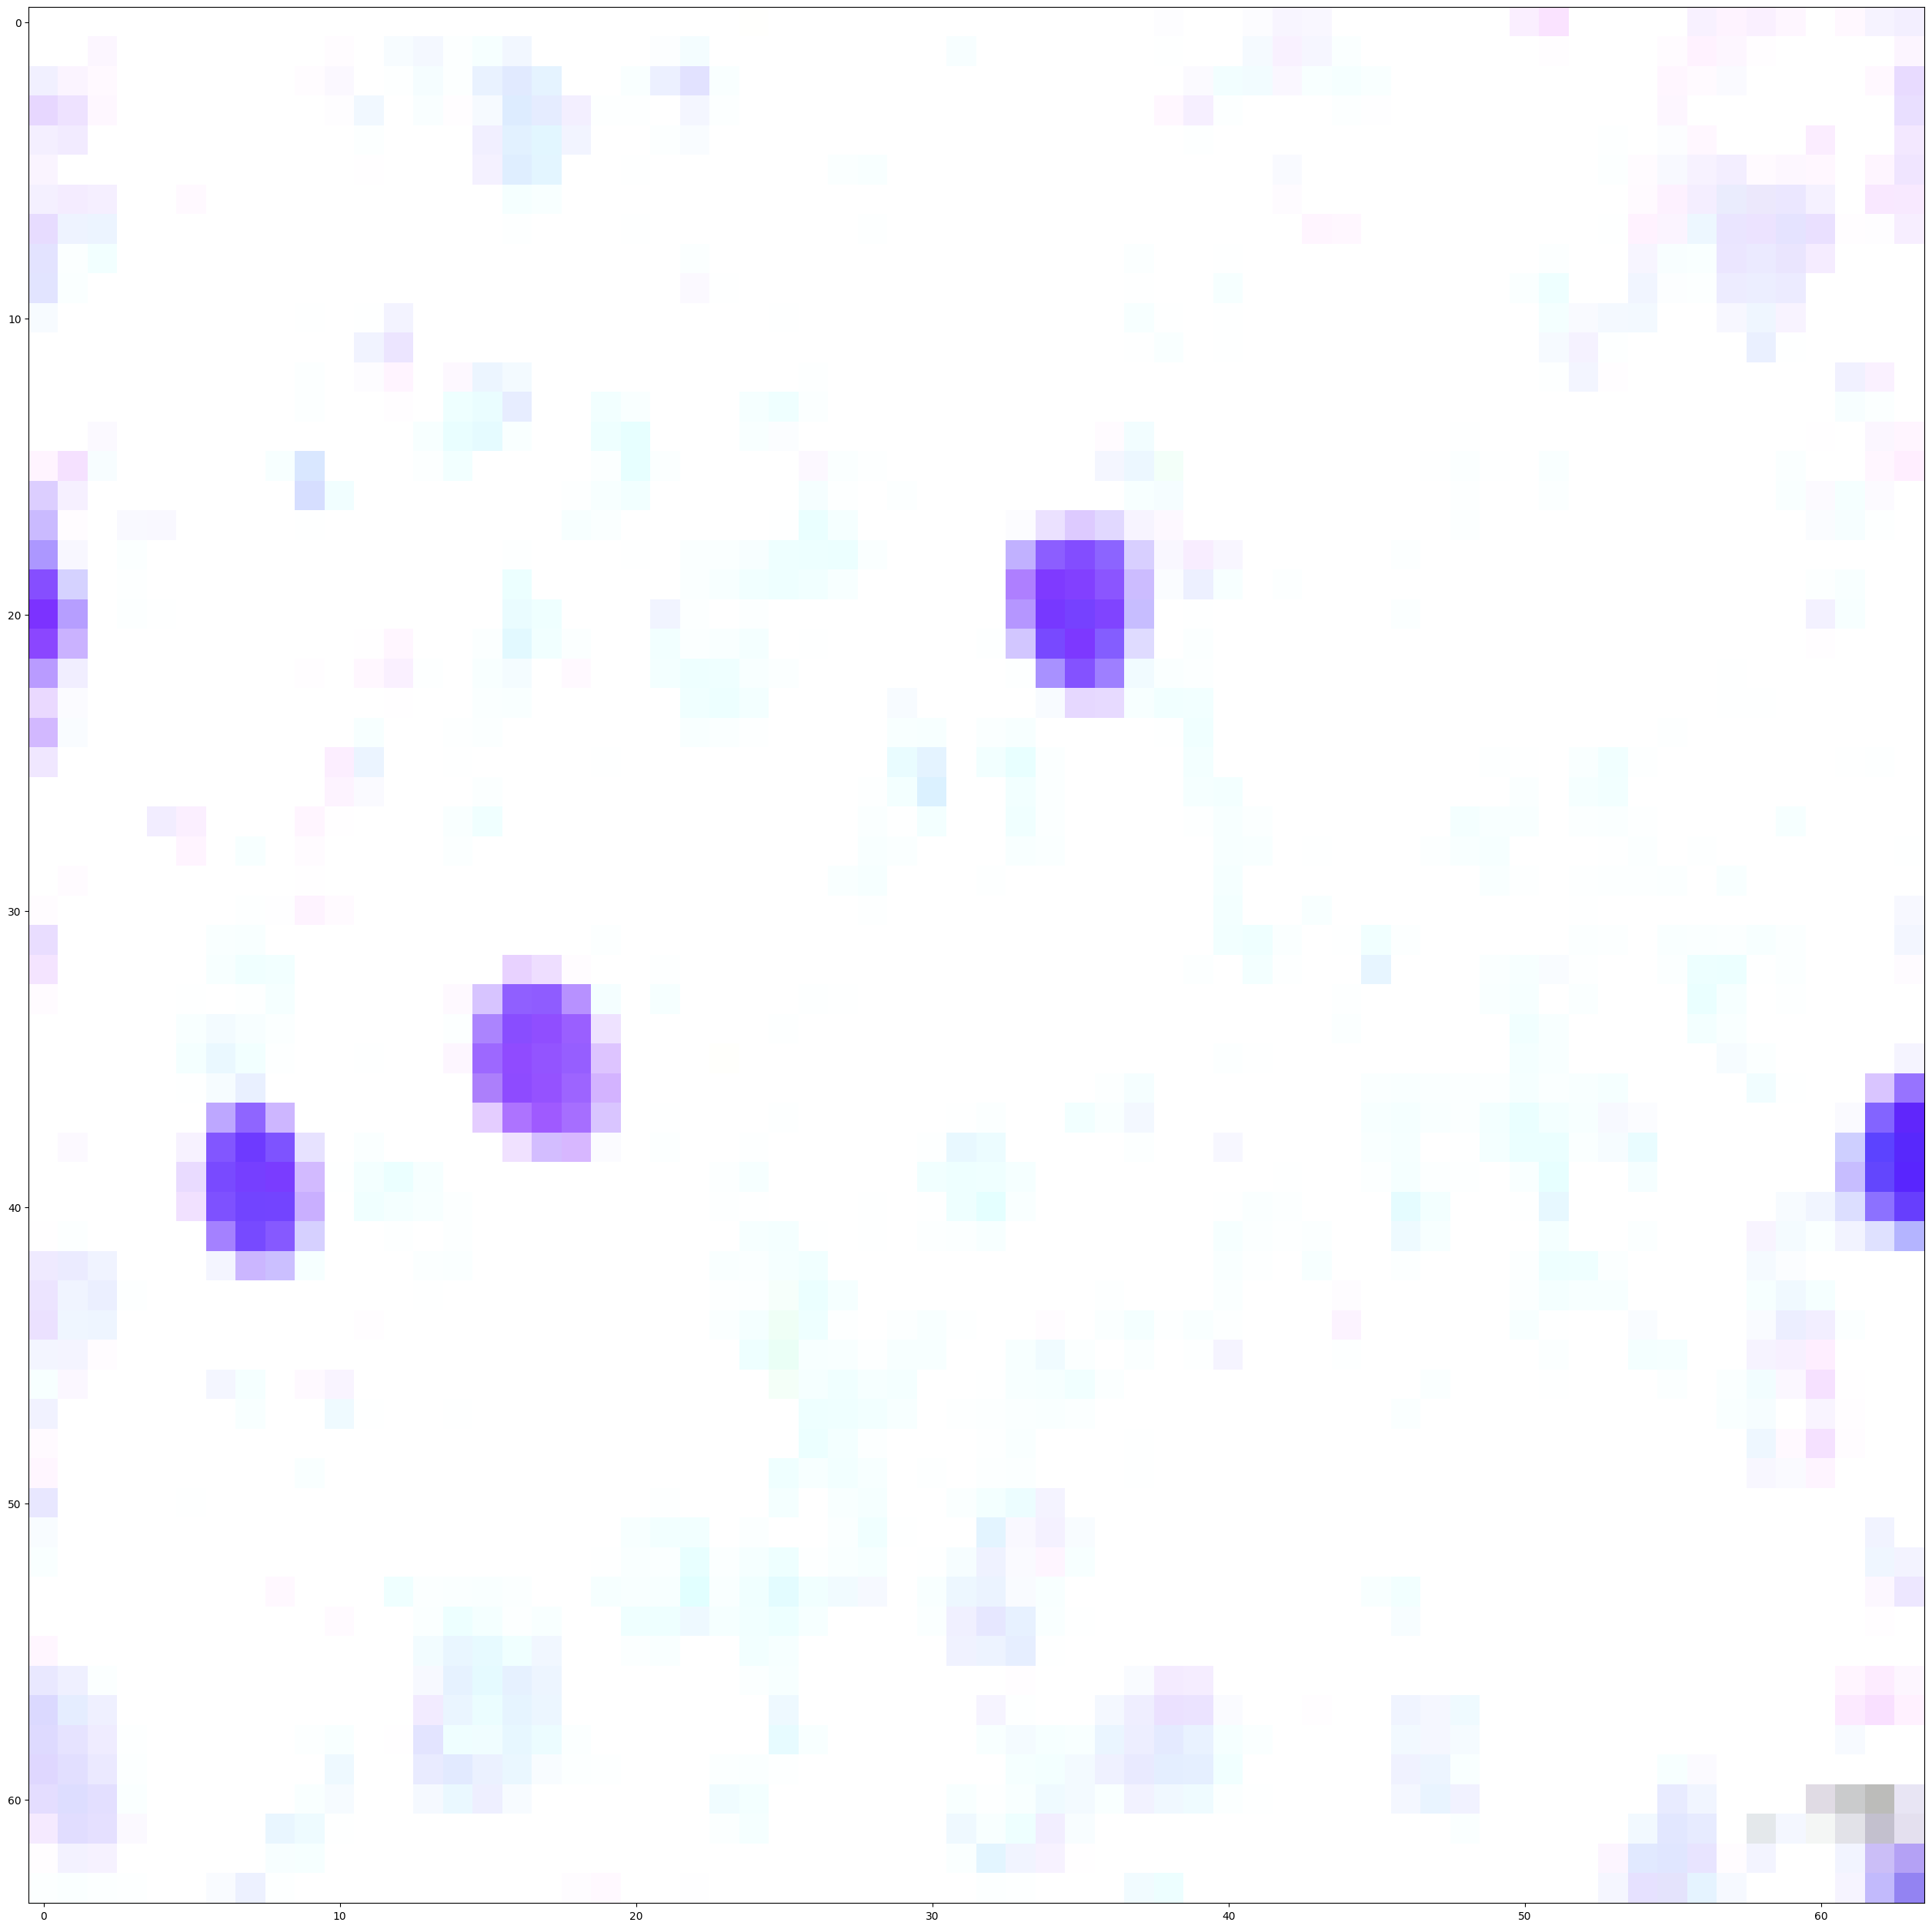

10:12:00 - INFO: Sampling 1 new images....
999it [00:19, 50.80it/s]


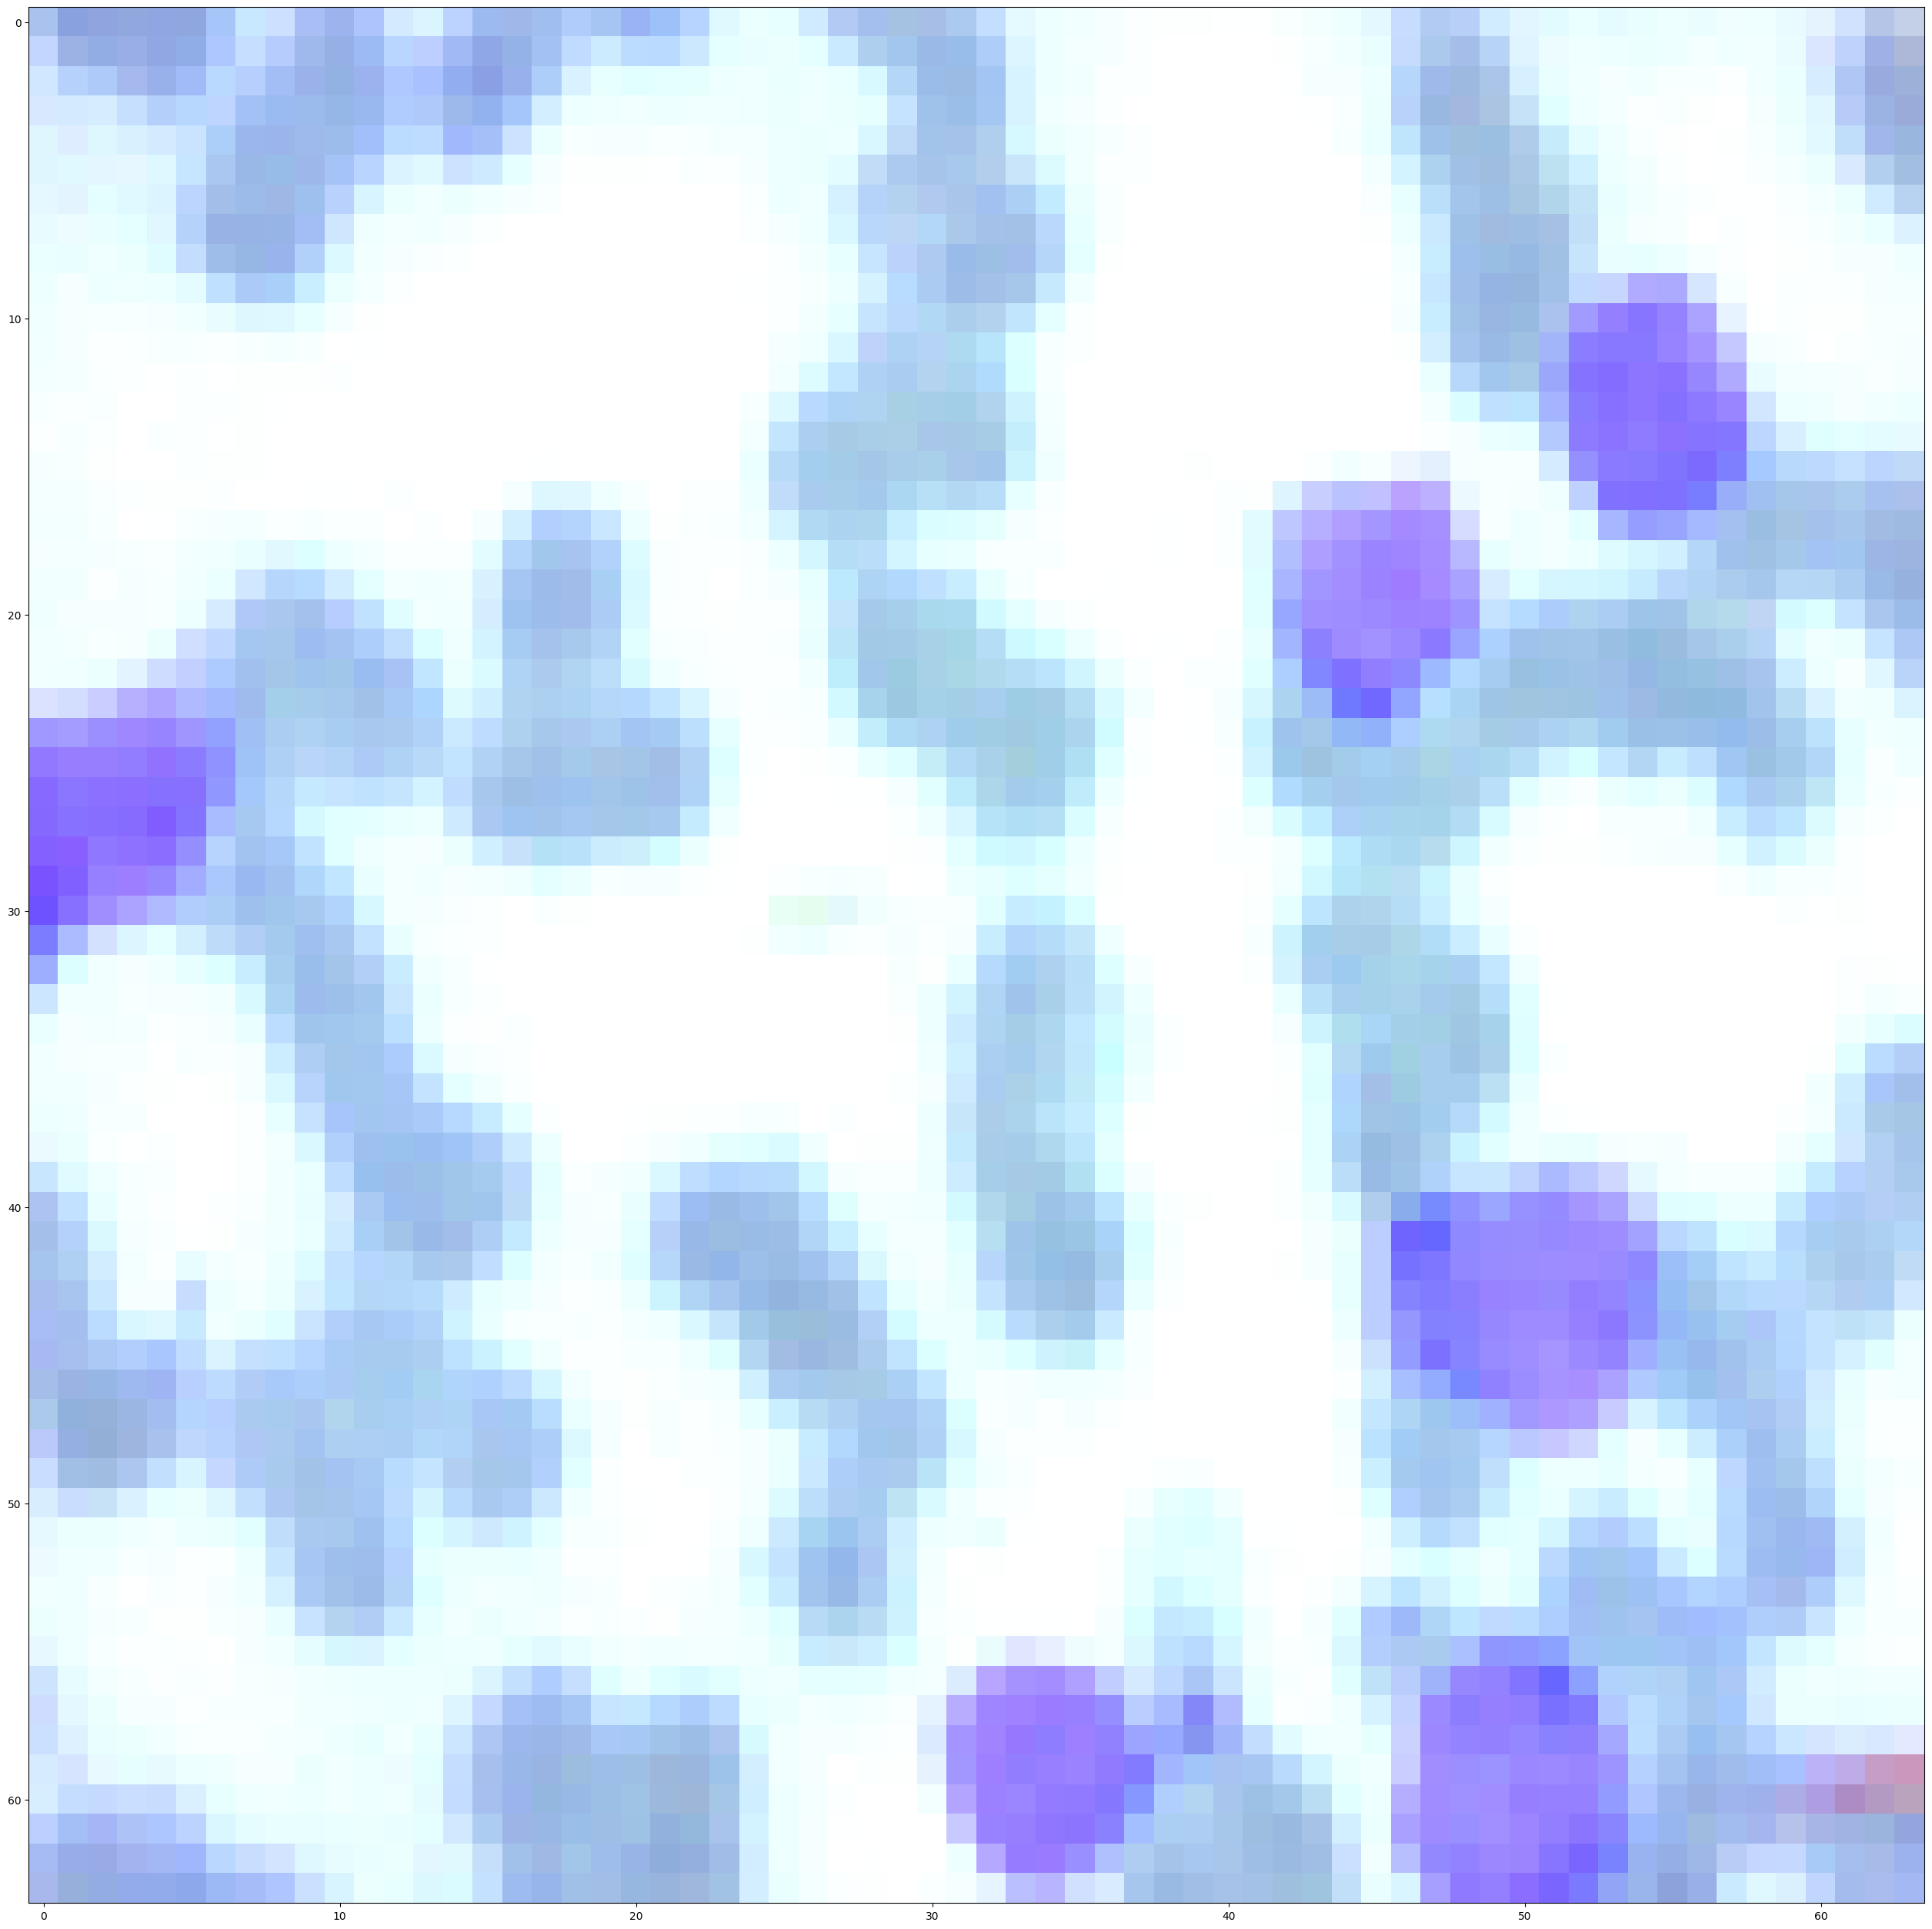

10:12:21 - INFO: Sampling 1 new images....
999it [00:21, 46.63it/s]


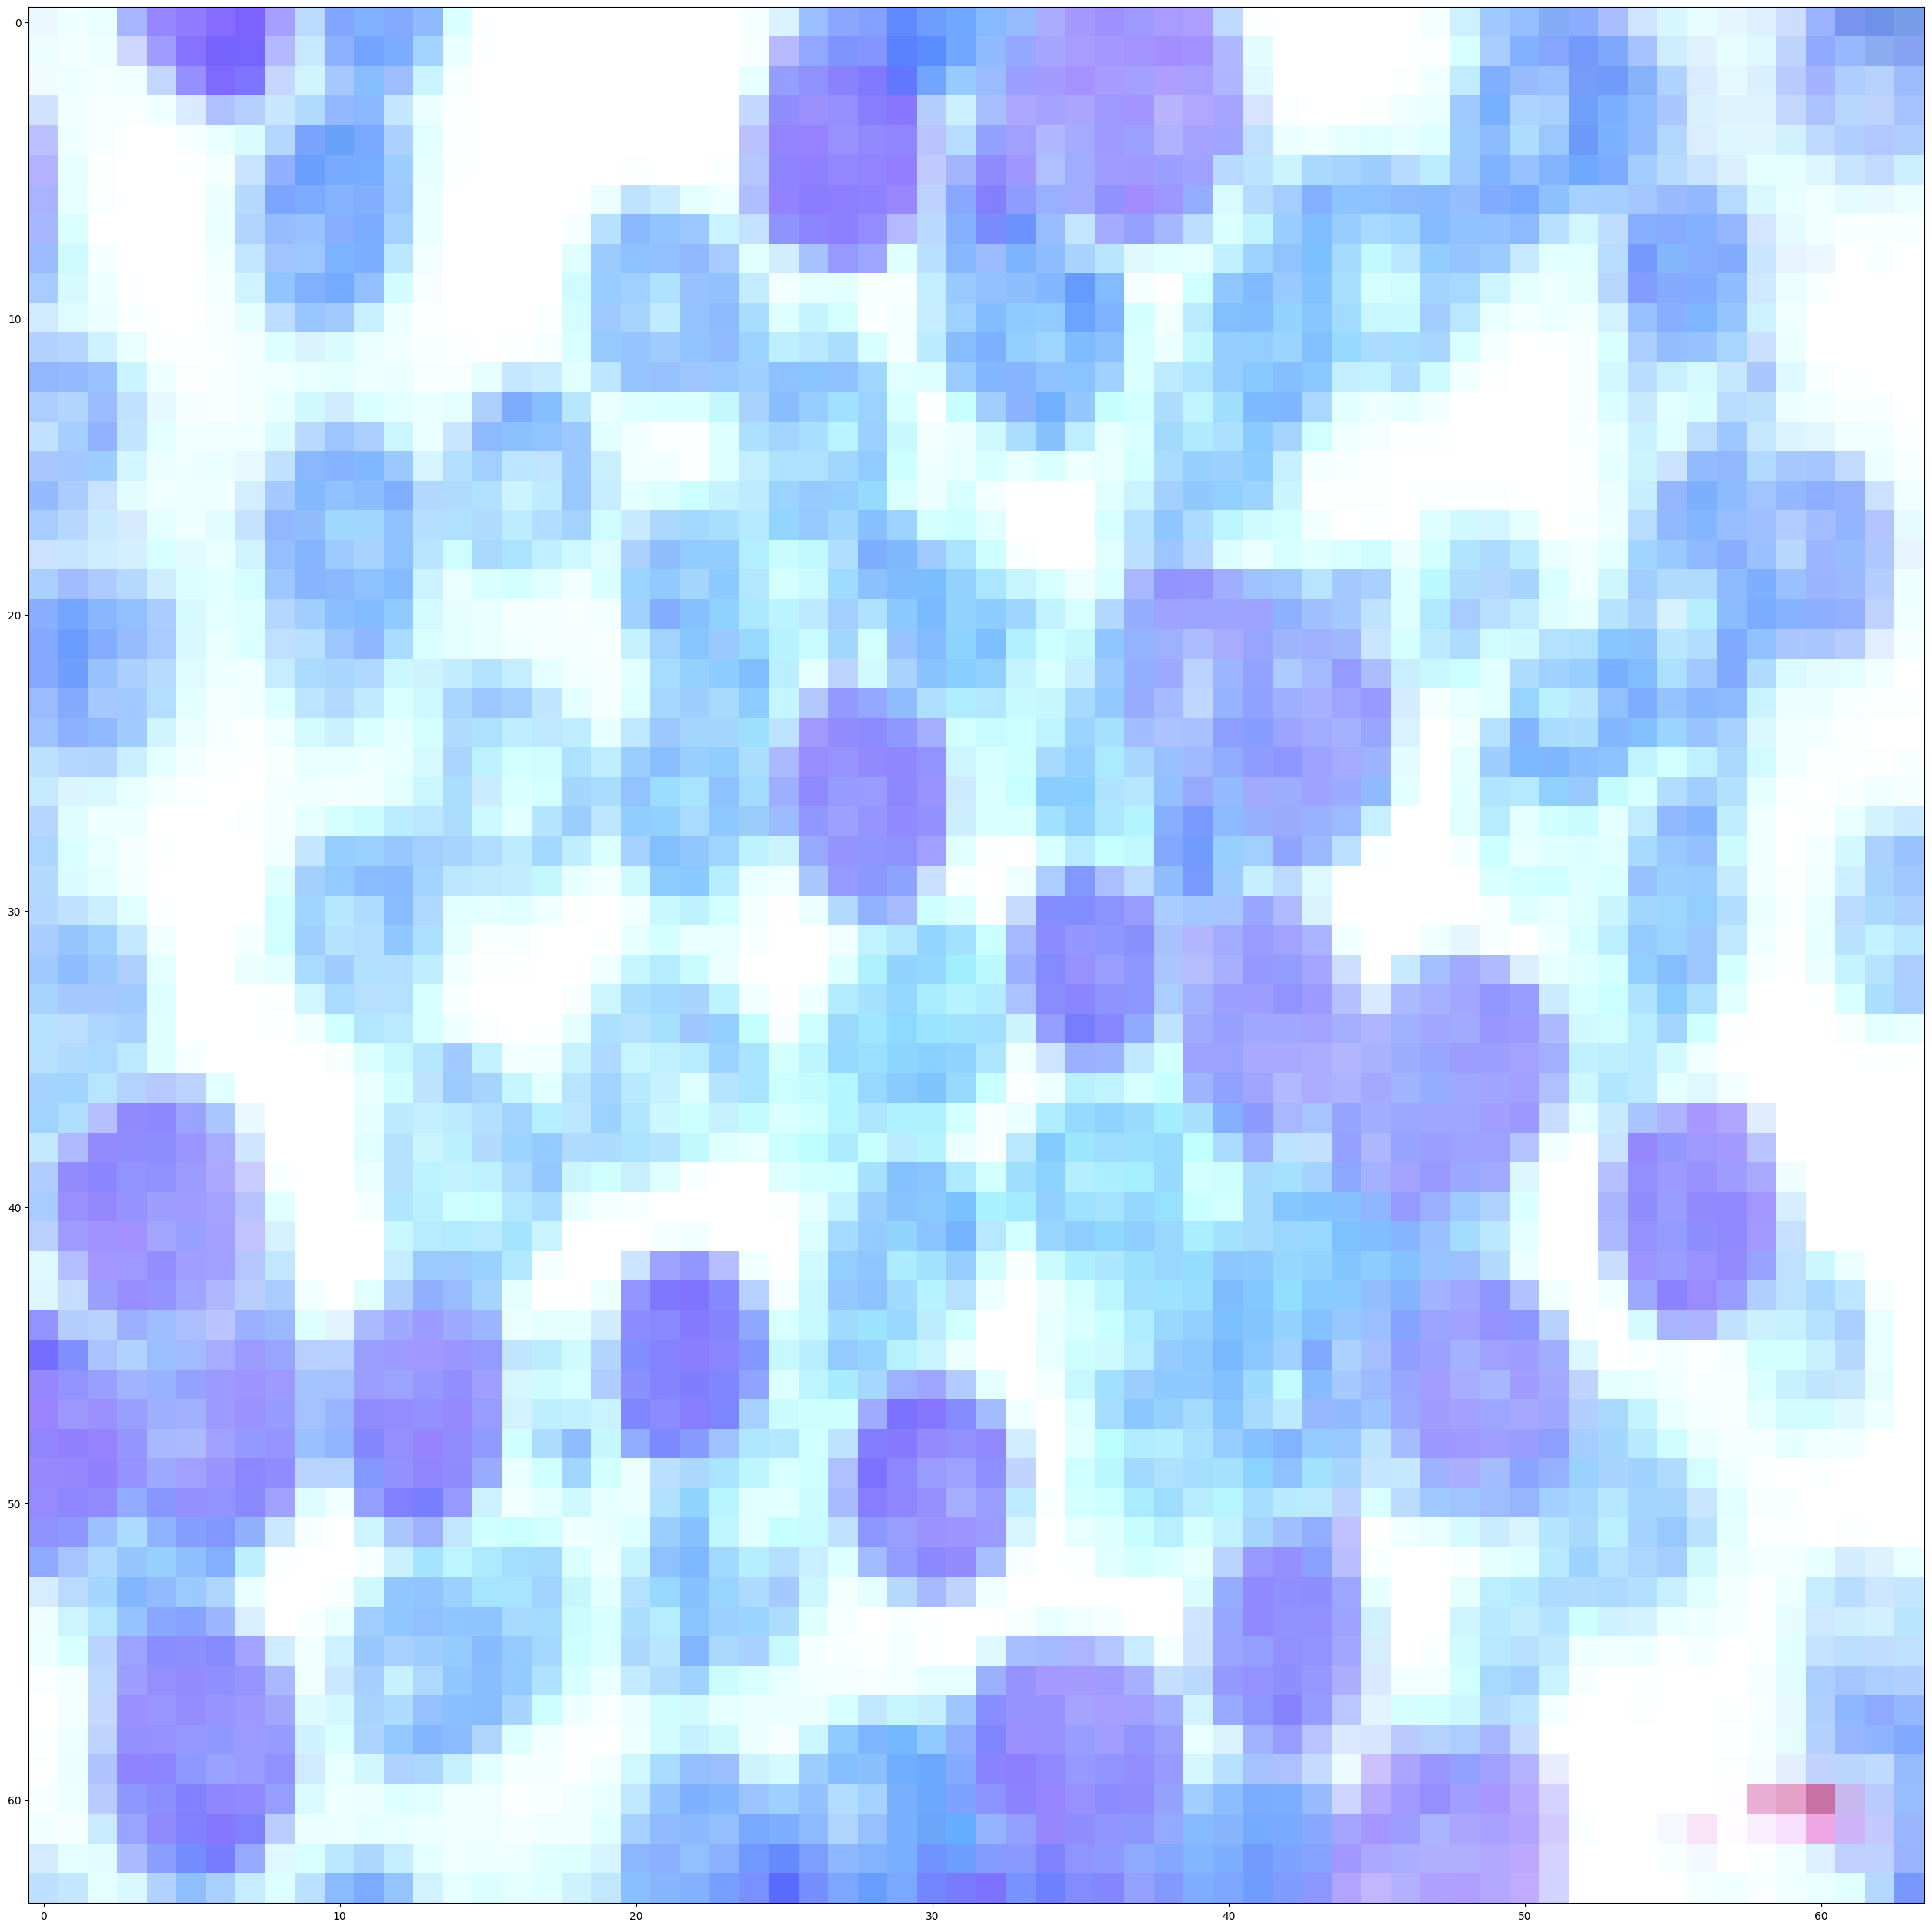

10:12:42 - INFO: Sampling 1 new images....
999it [00:20, 47.94it/s]


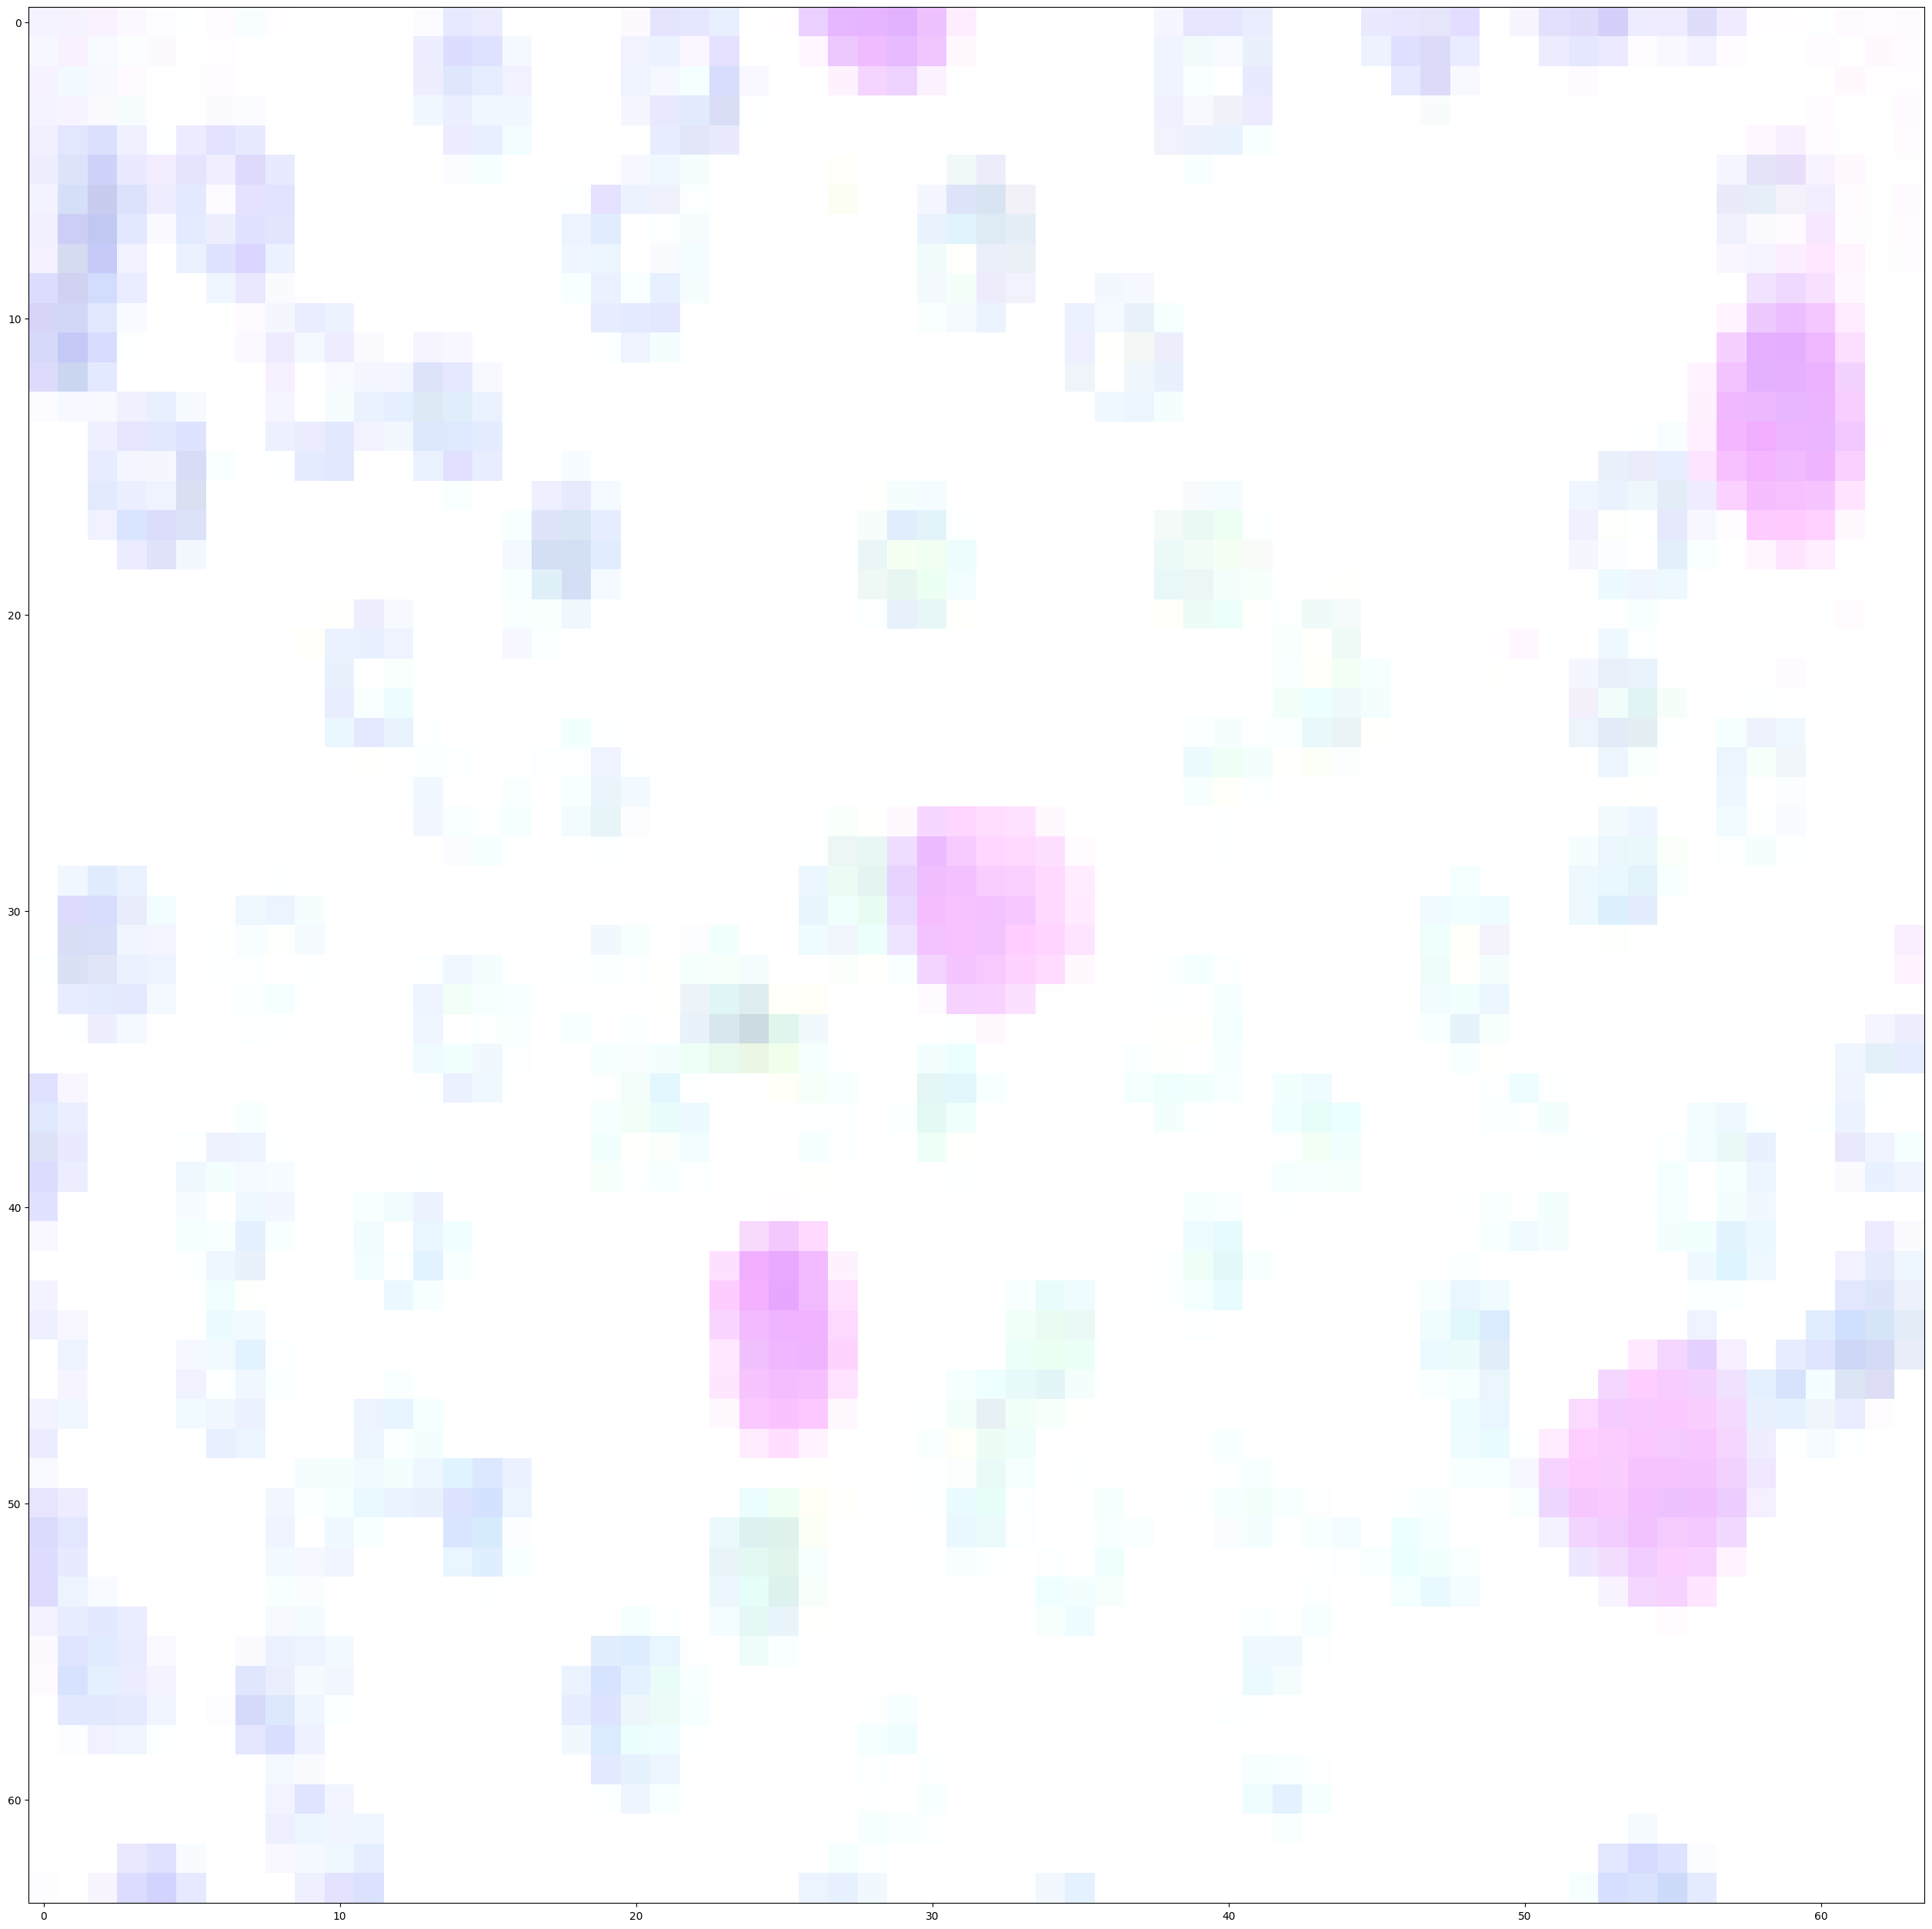

10:13:04 - INFO: Sampling 1 new images....
999it [00:19, 52.28it/s]


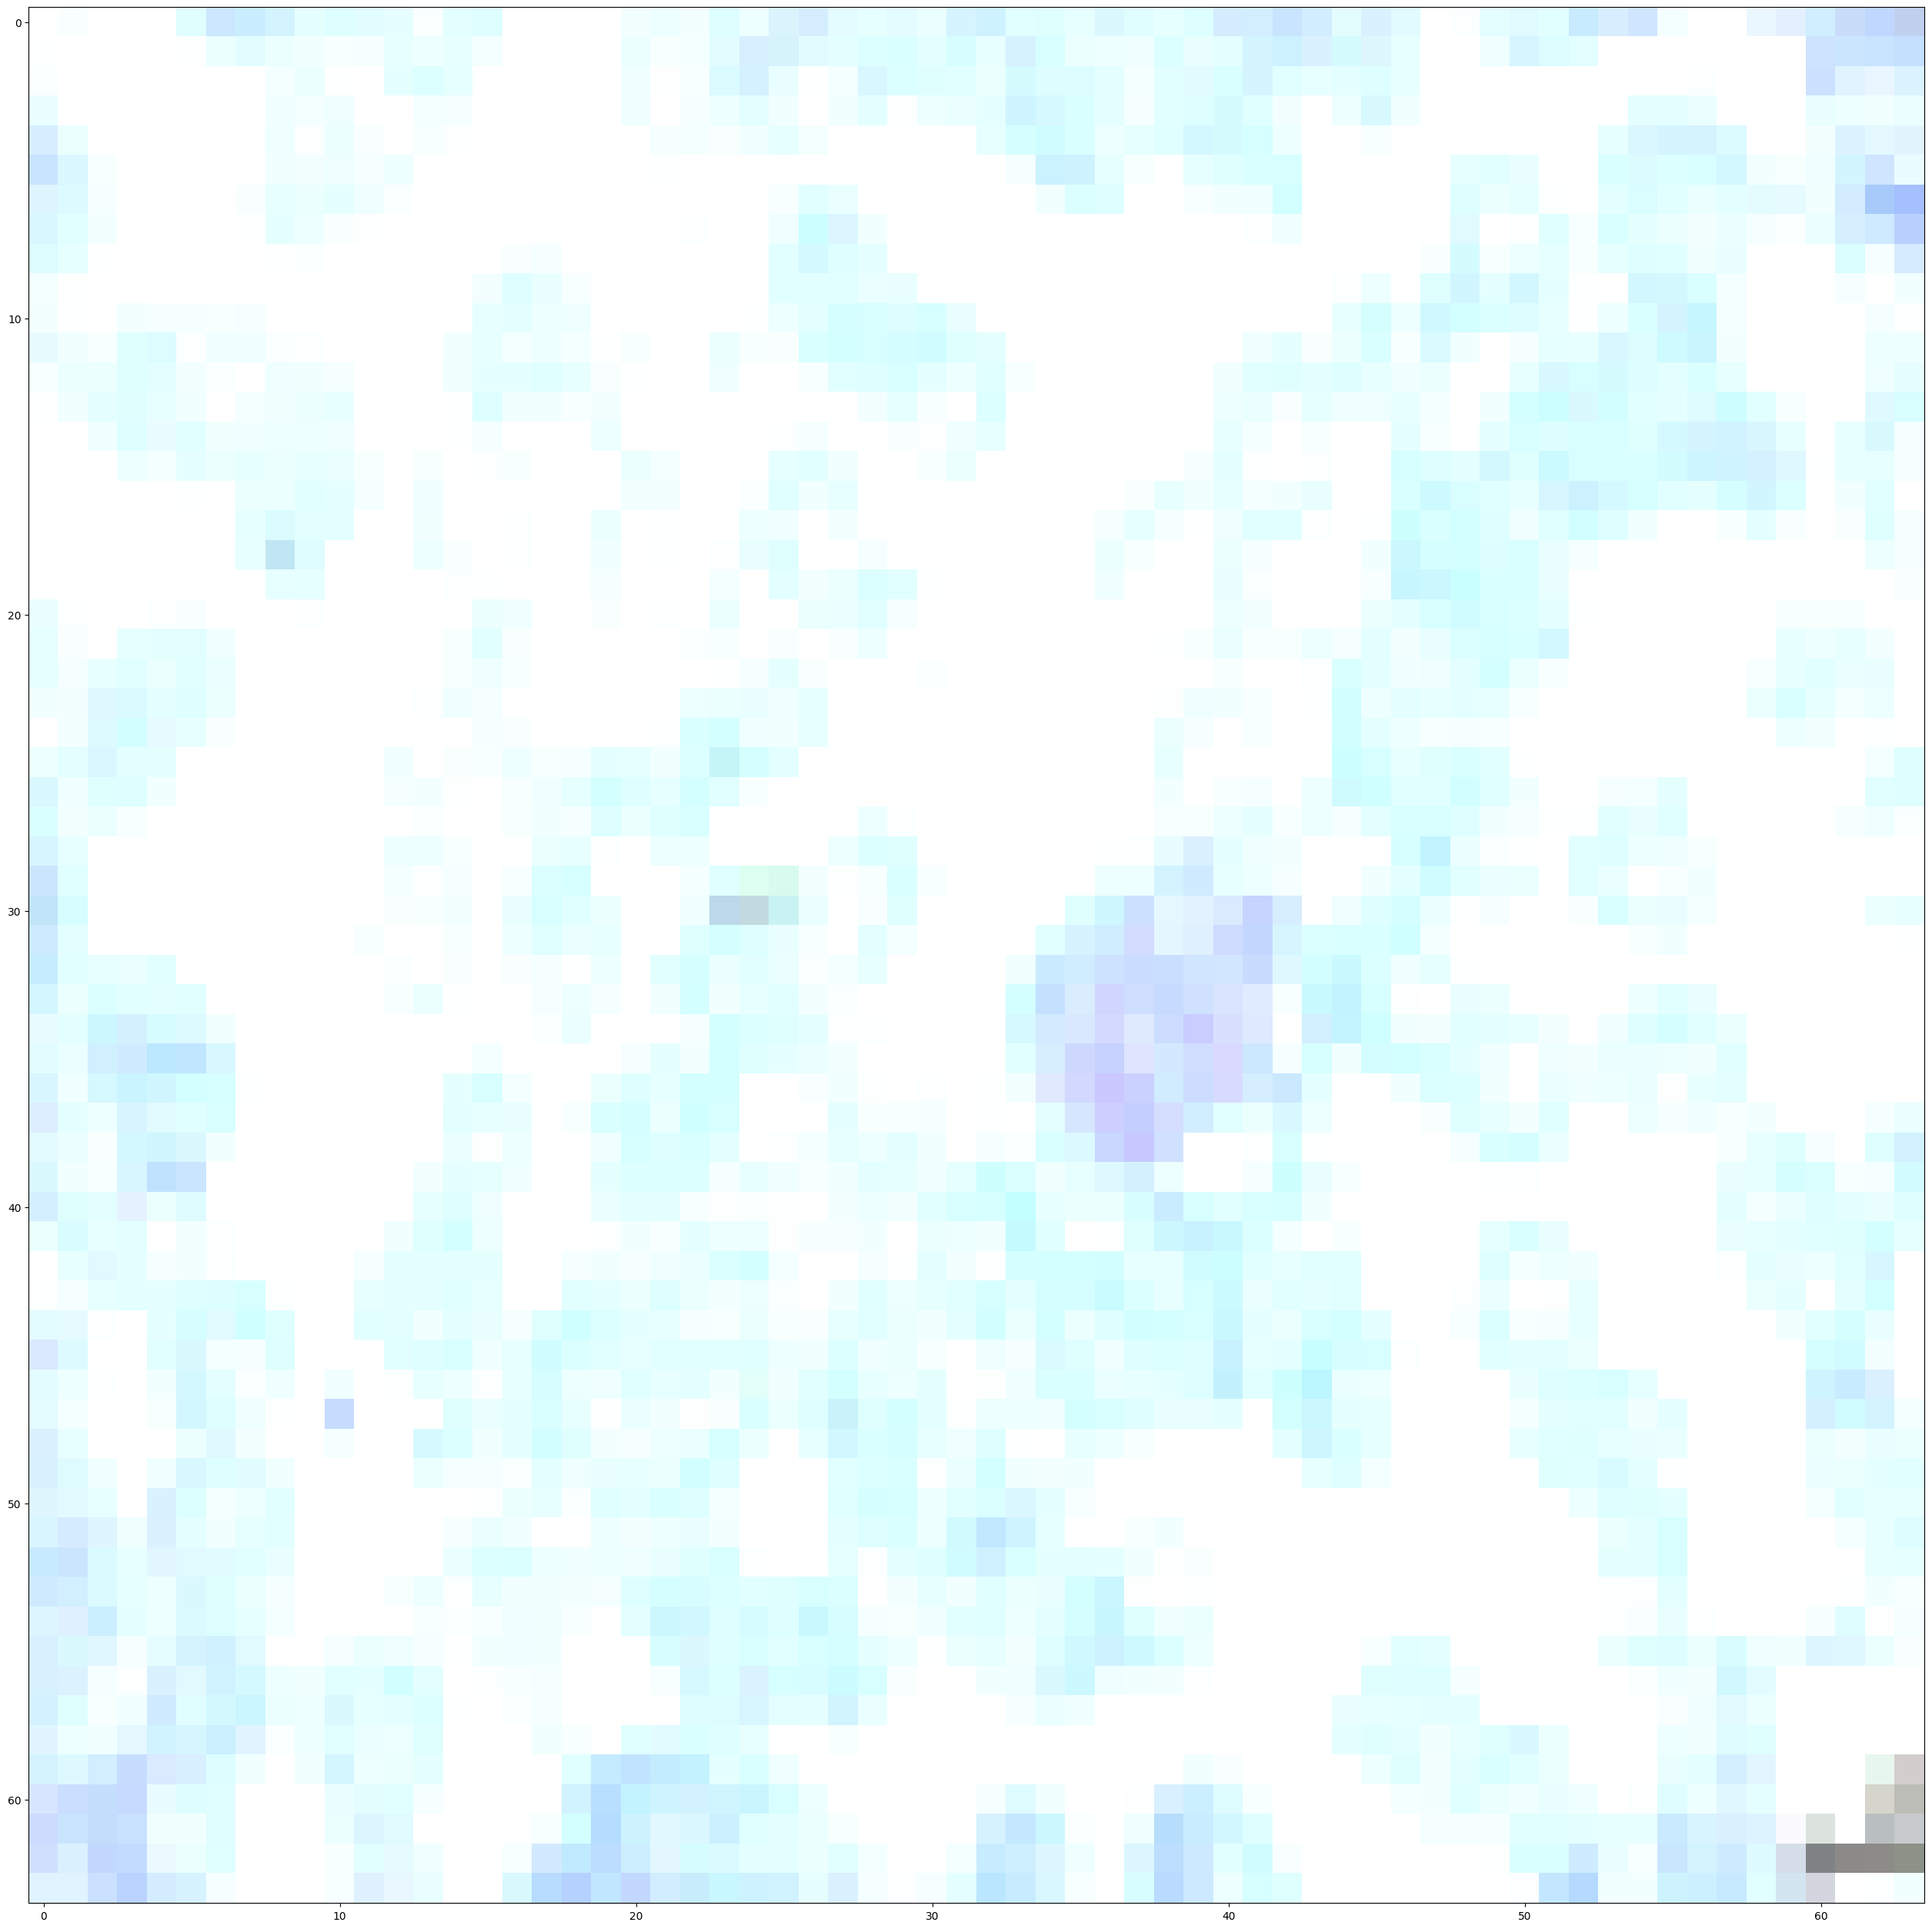

10:13:23 - INFO: Sampling 1 new images....
999it [00:20, 48.40it/s]


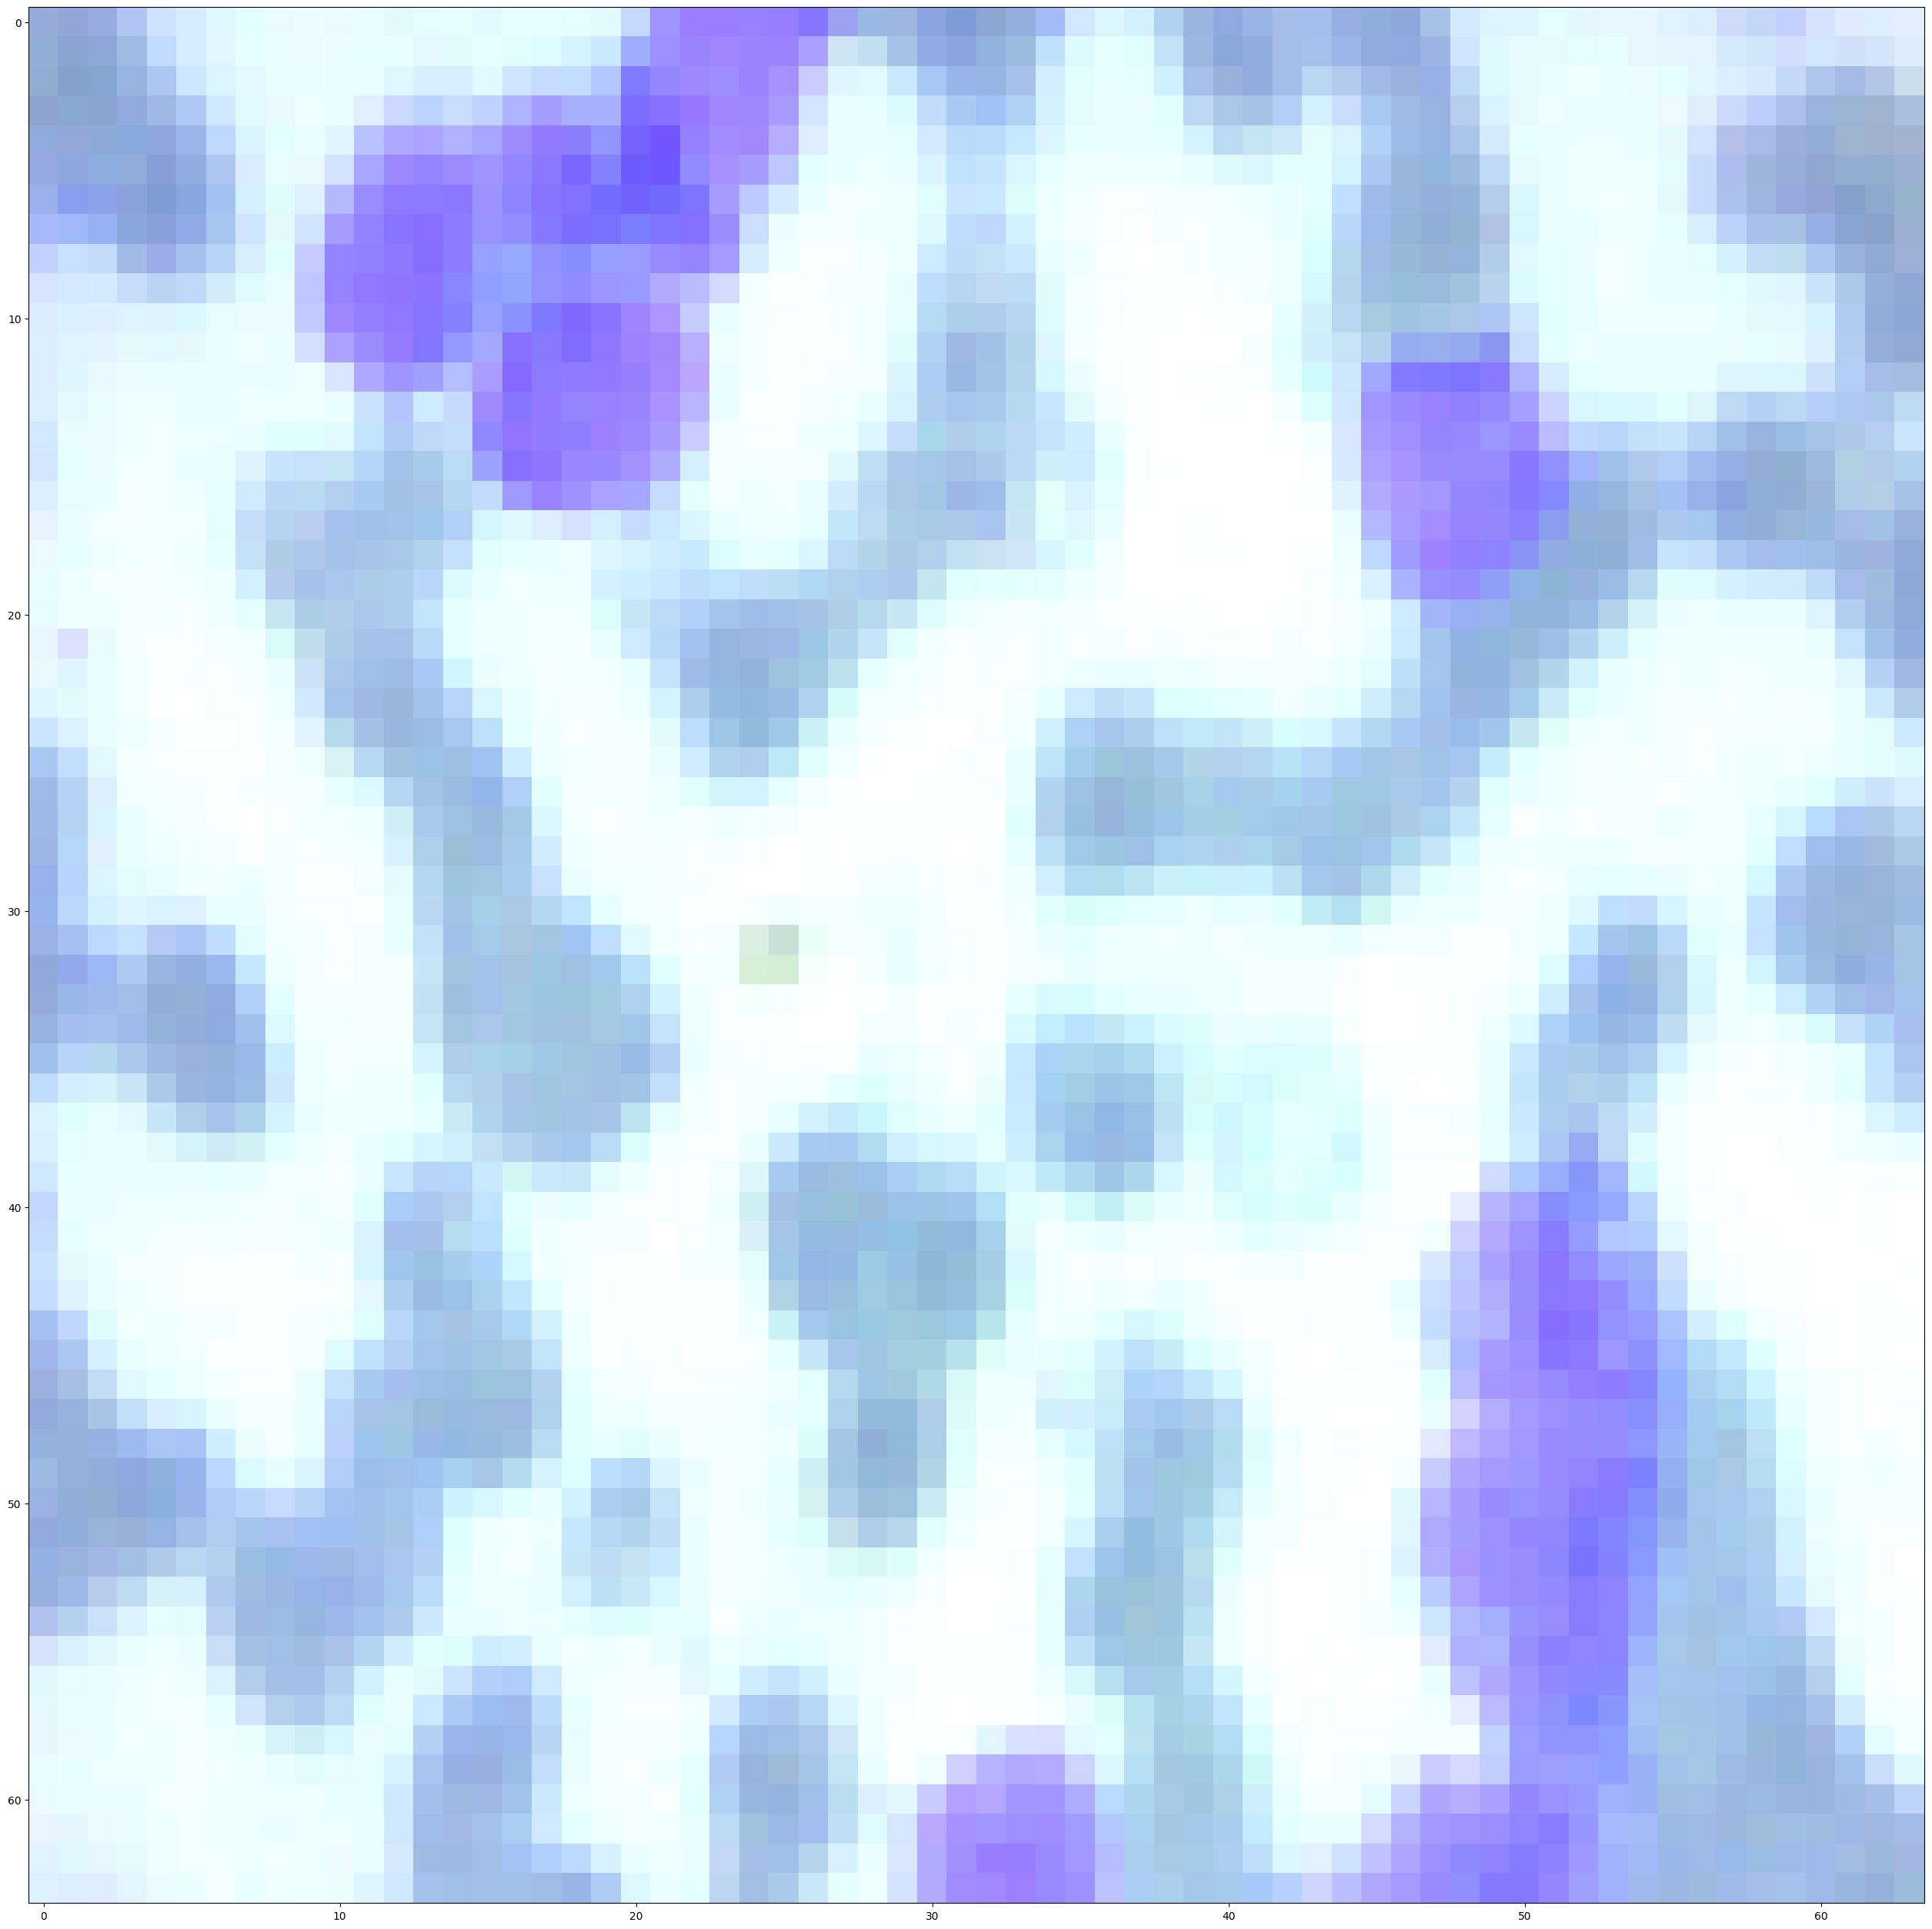

10:13:45 - INFO: Sampling 1 new images....
999it [00:20, 48.67it/s]


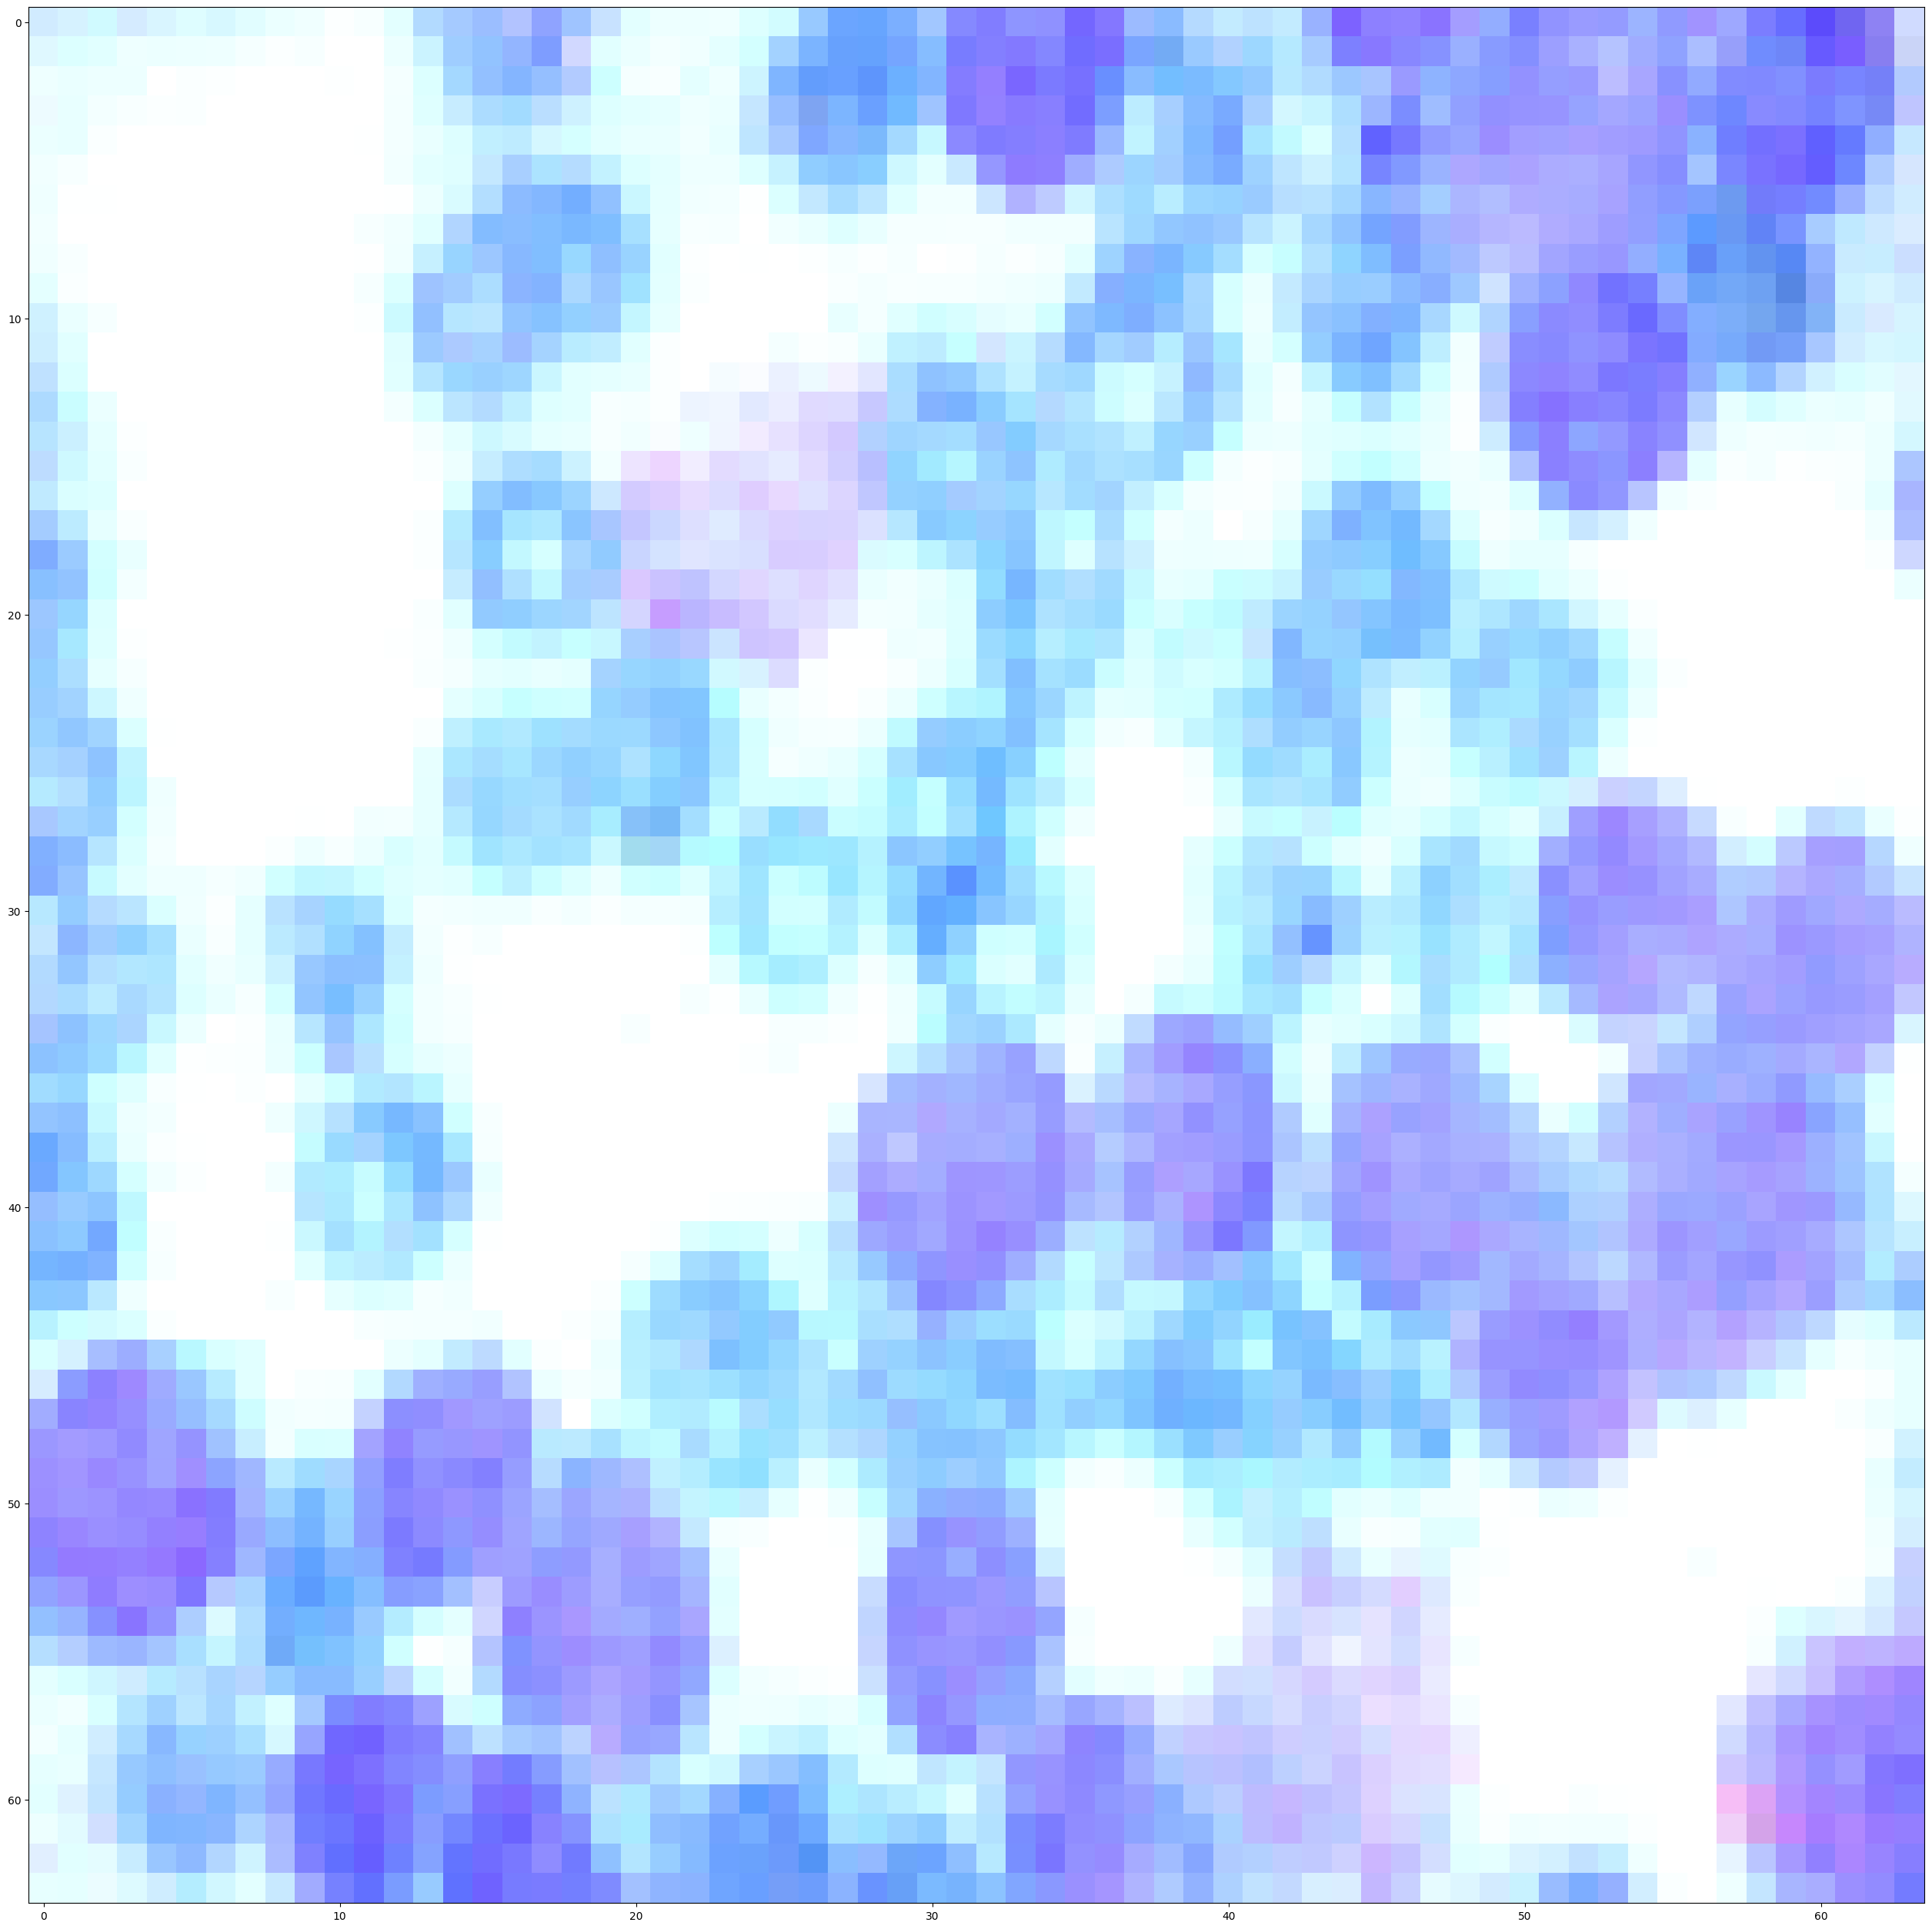

10:14:06 - INFO: Sampling 1 new images....
999it [00:21, 47.30it/s]


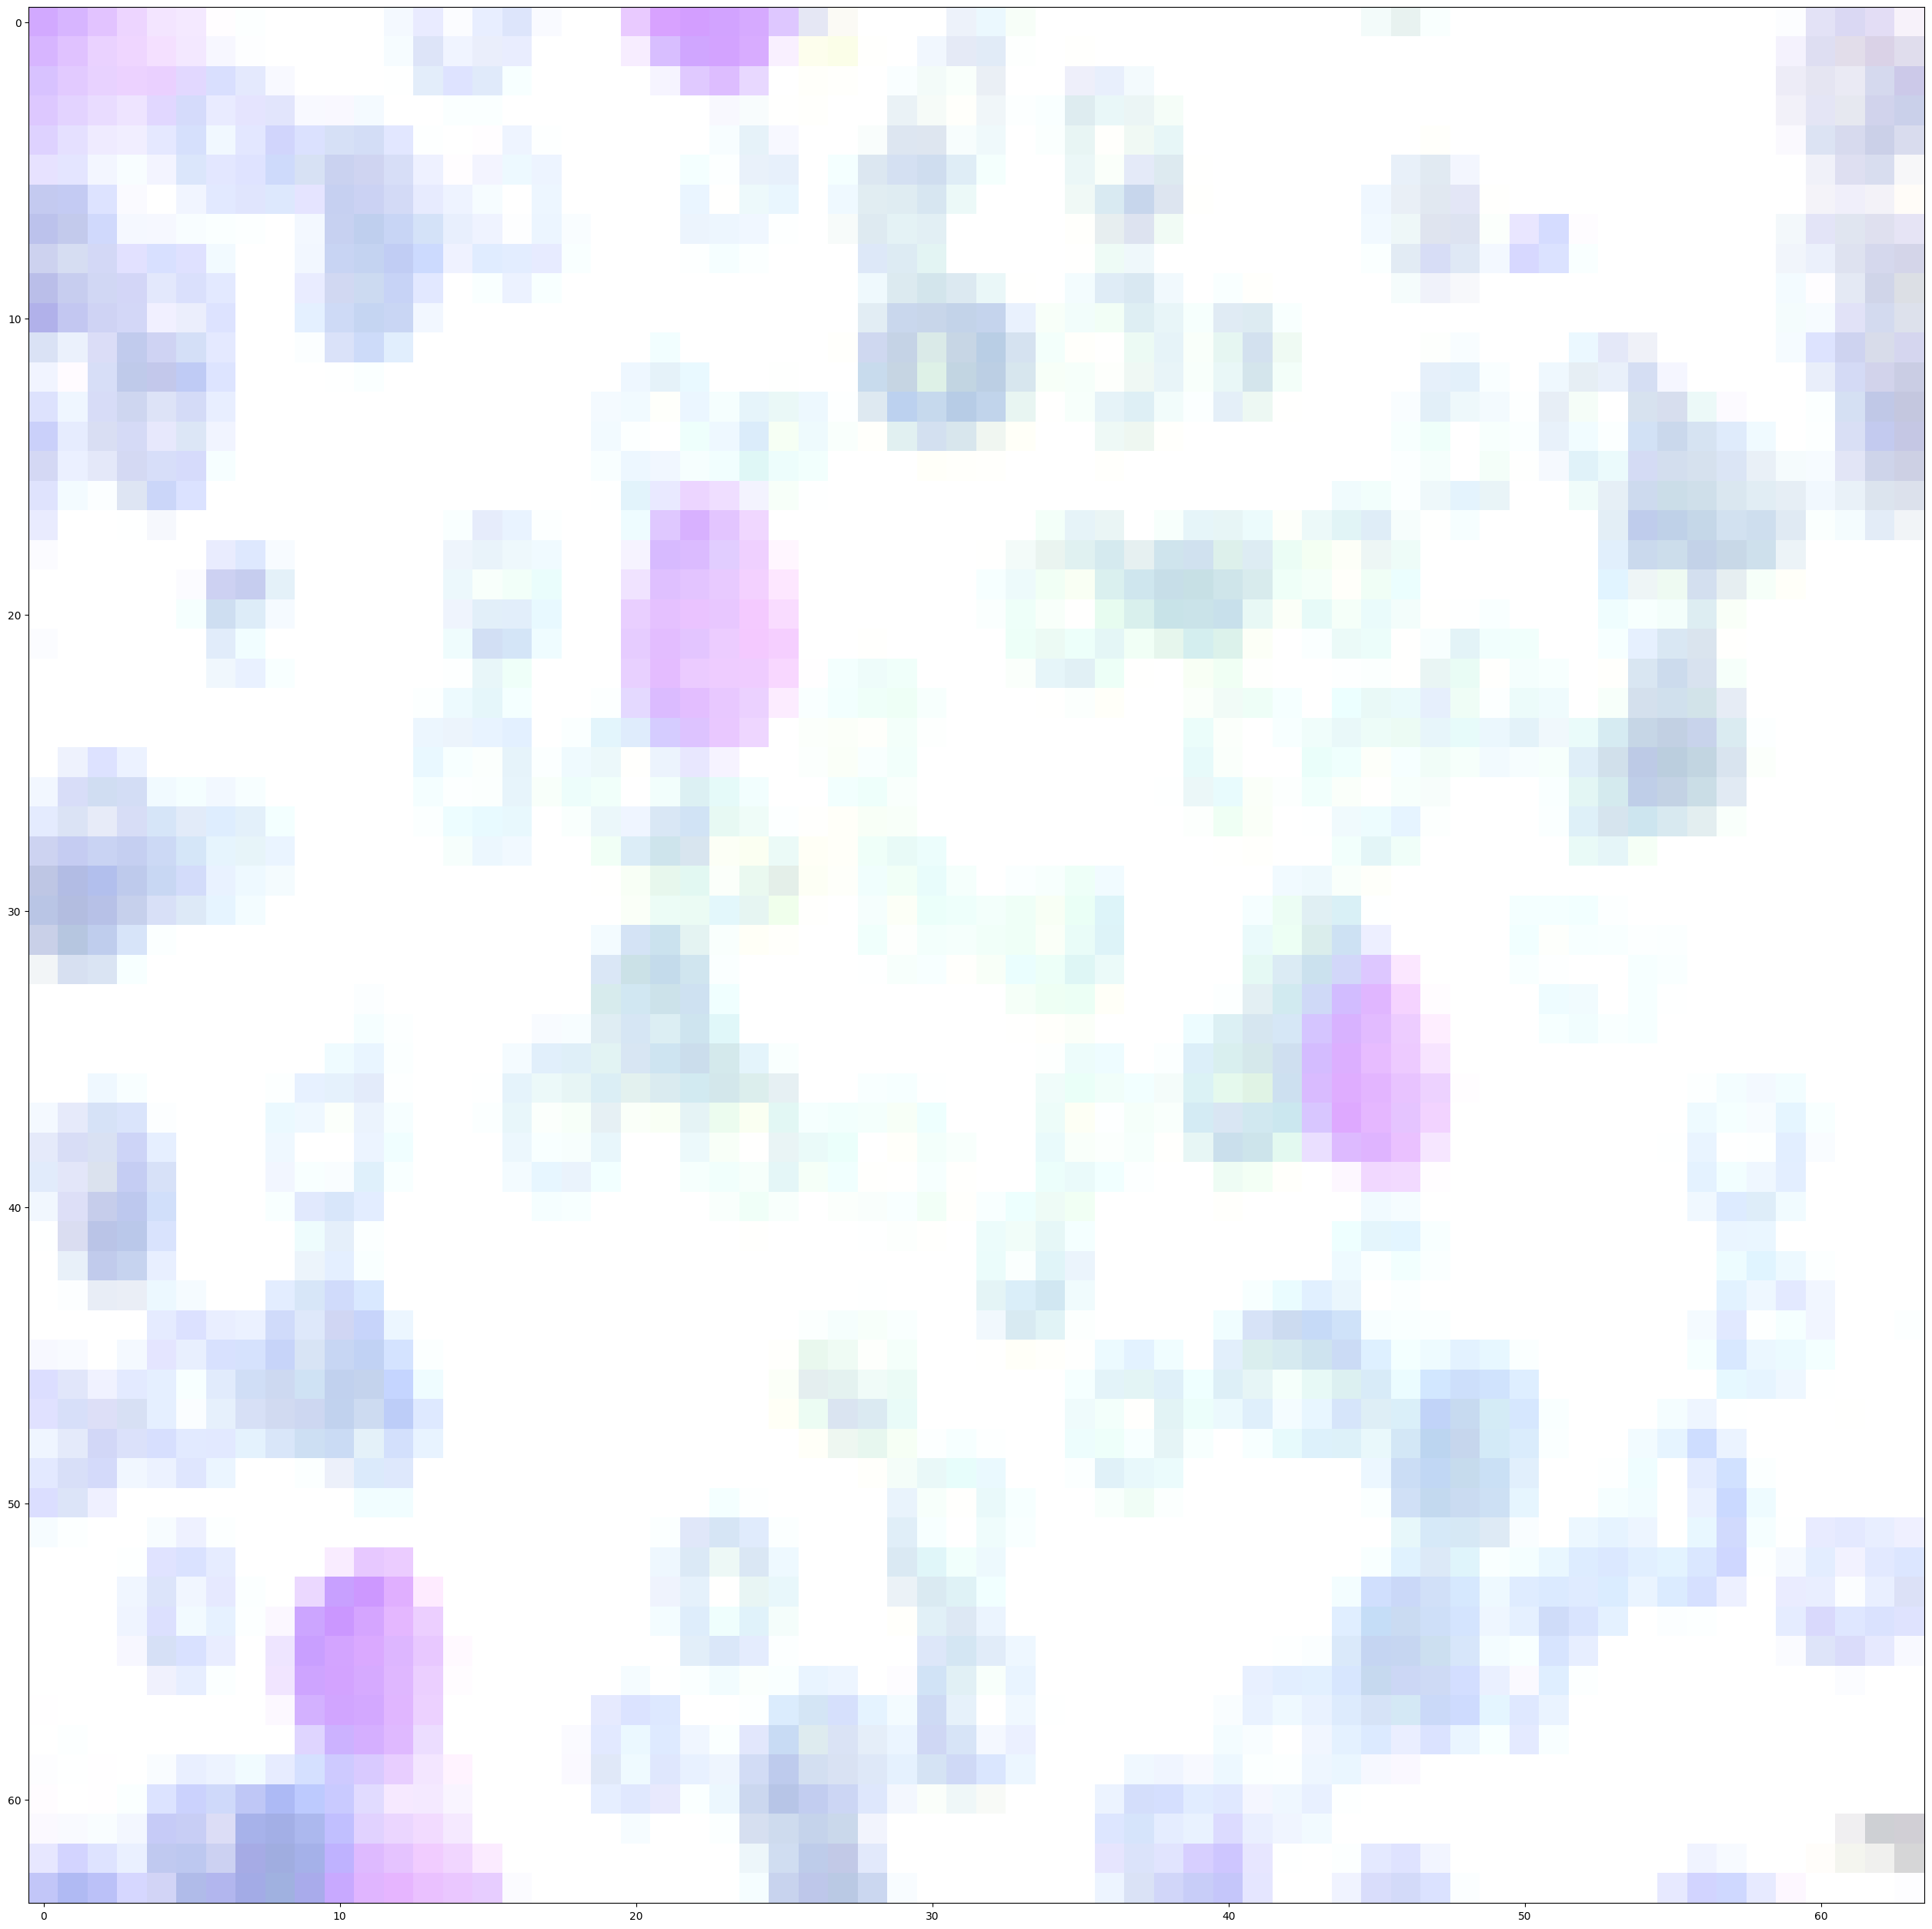

10:14:27 - INFO: Sampling 1 new images....
999it [00:19, 50.58it/s]


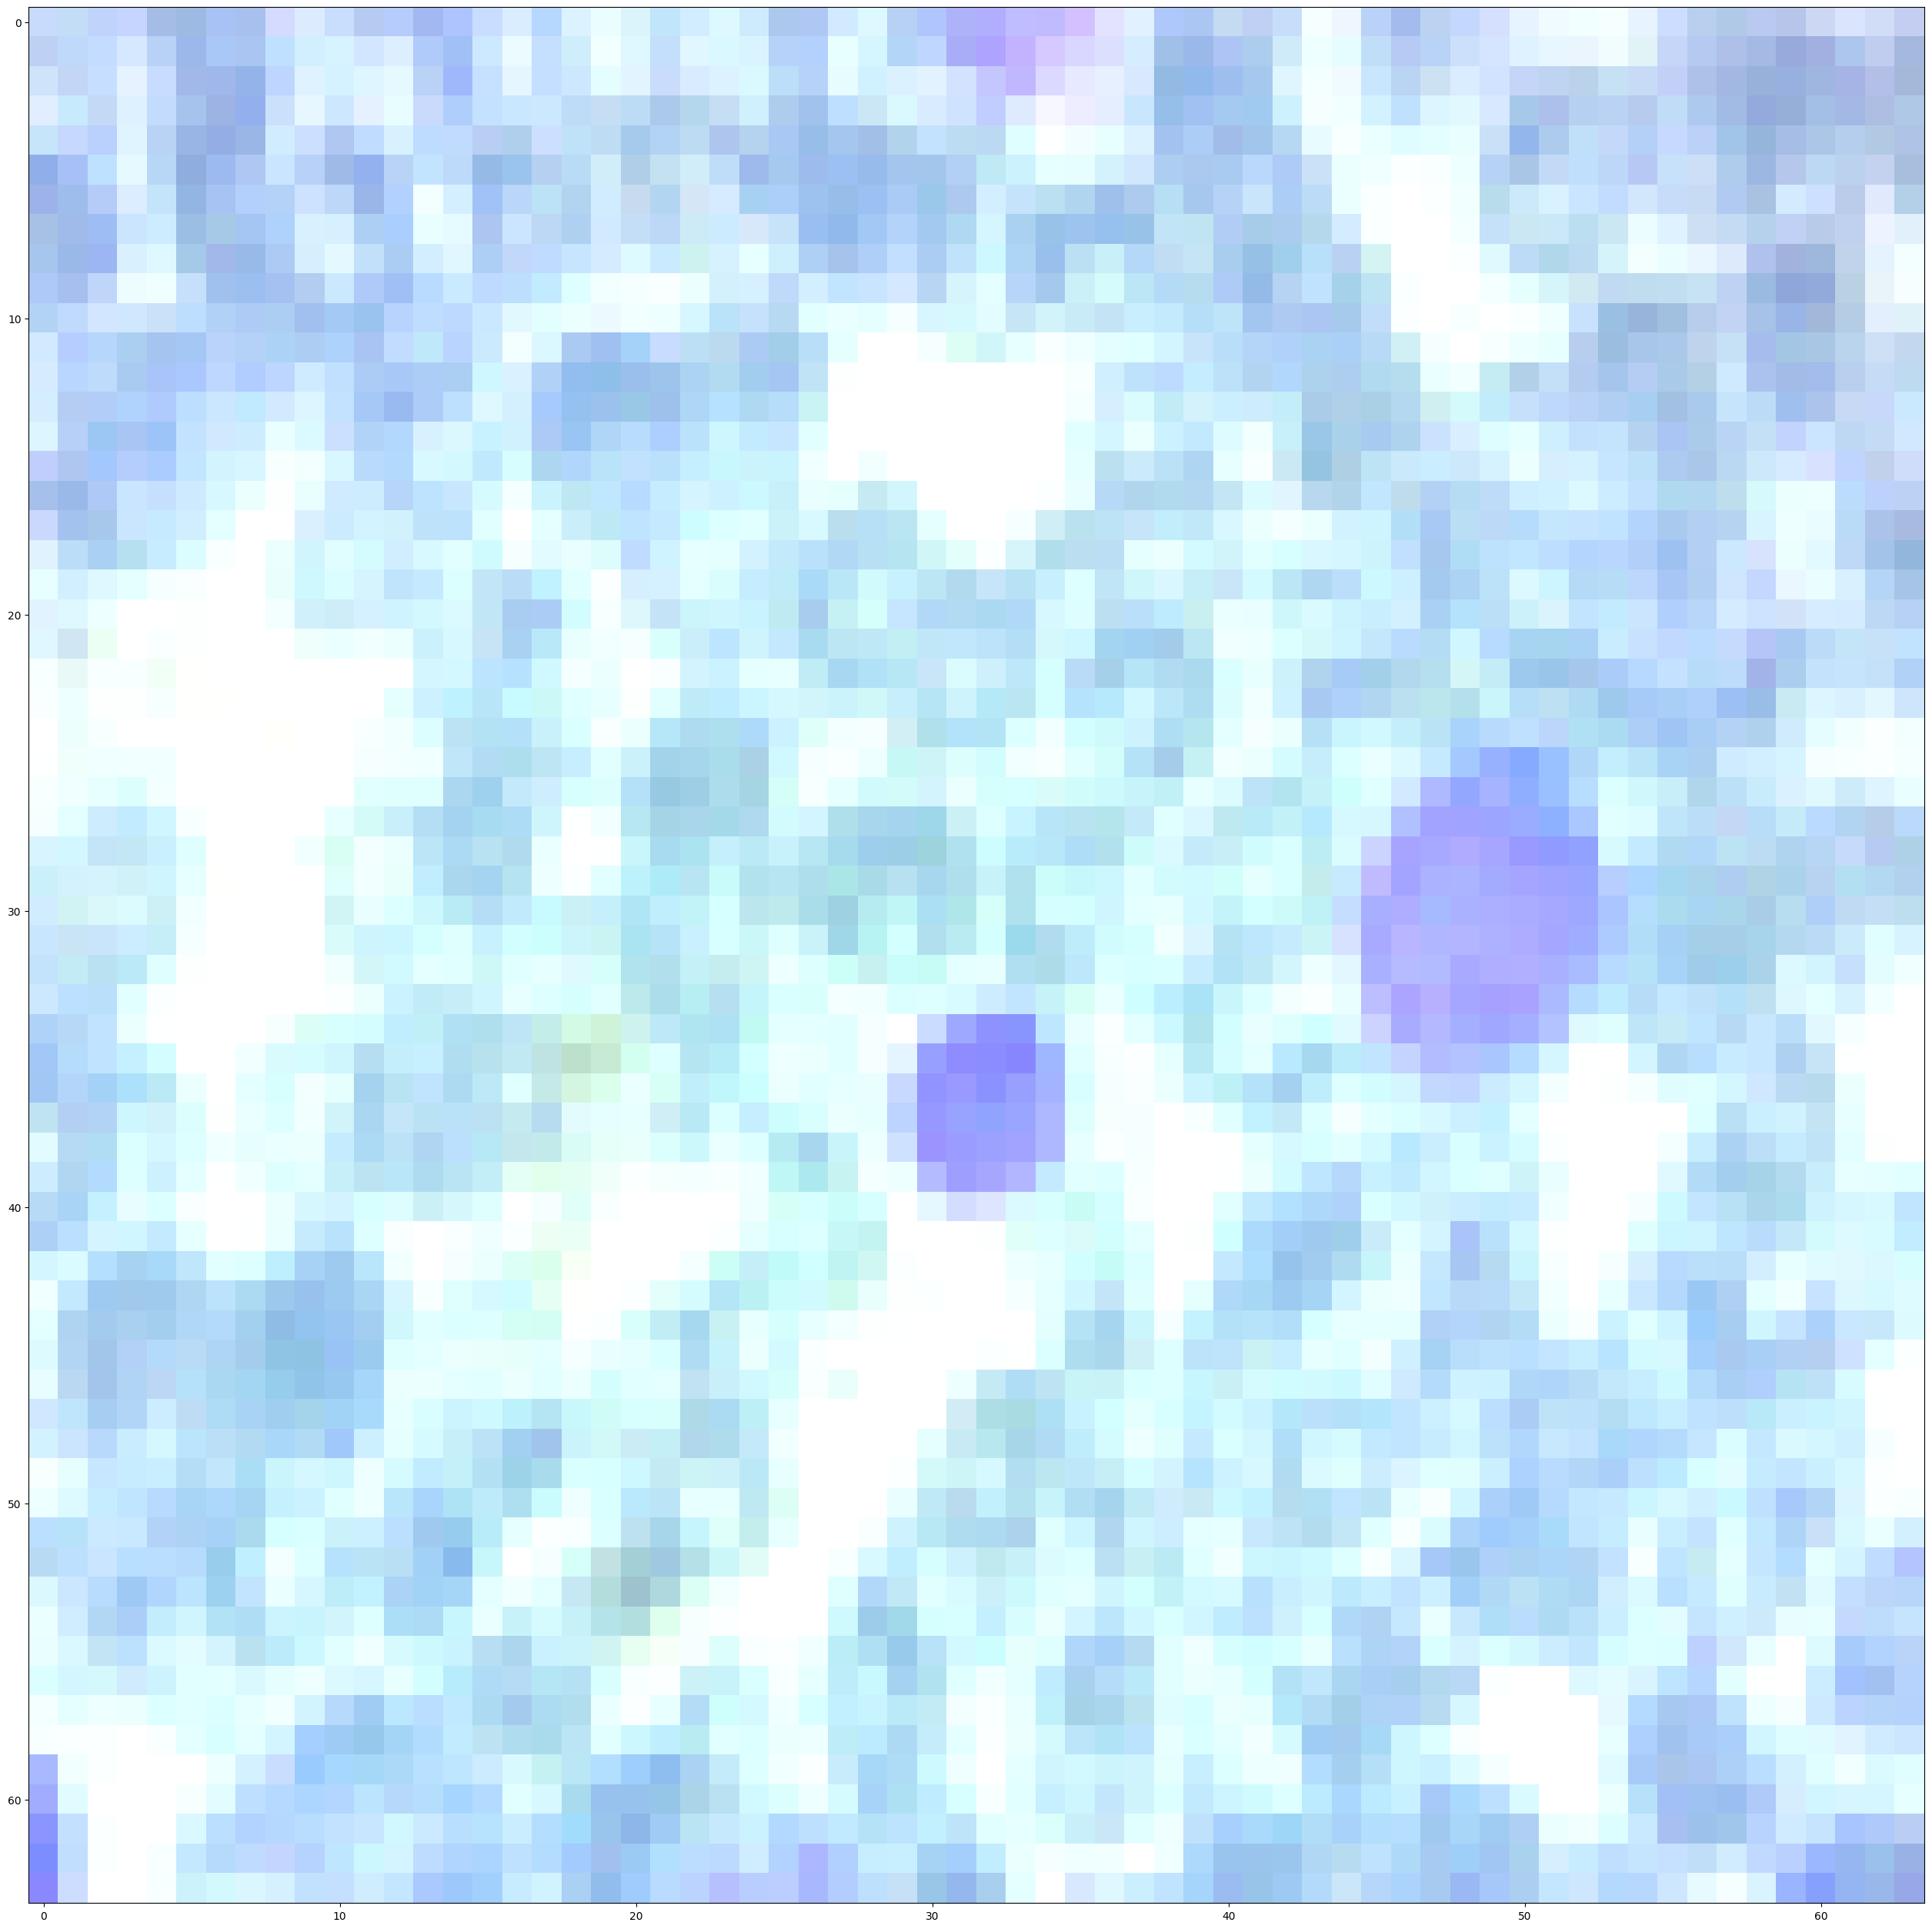

10:14:48 - INFO: Sampling 1 new images....
999it [00:21, 47.21it/s]


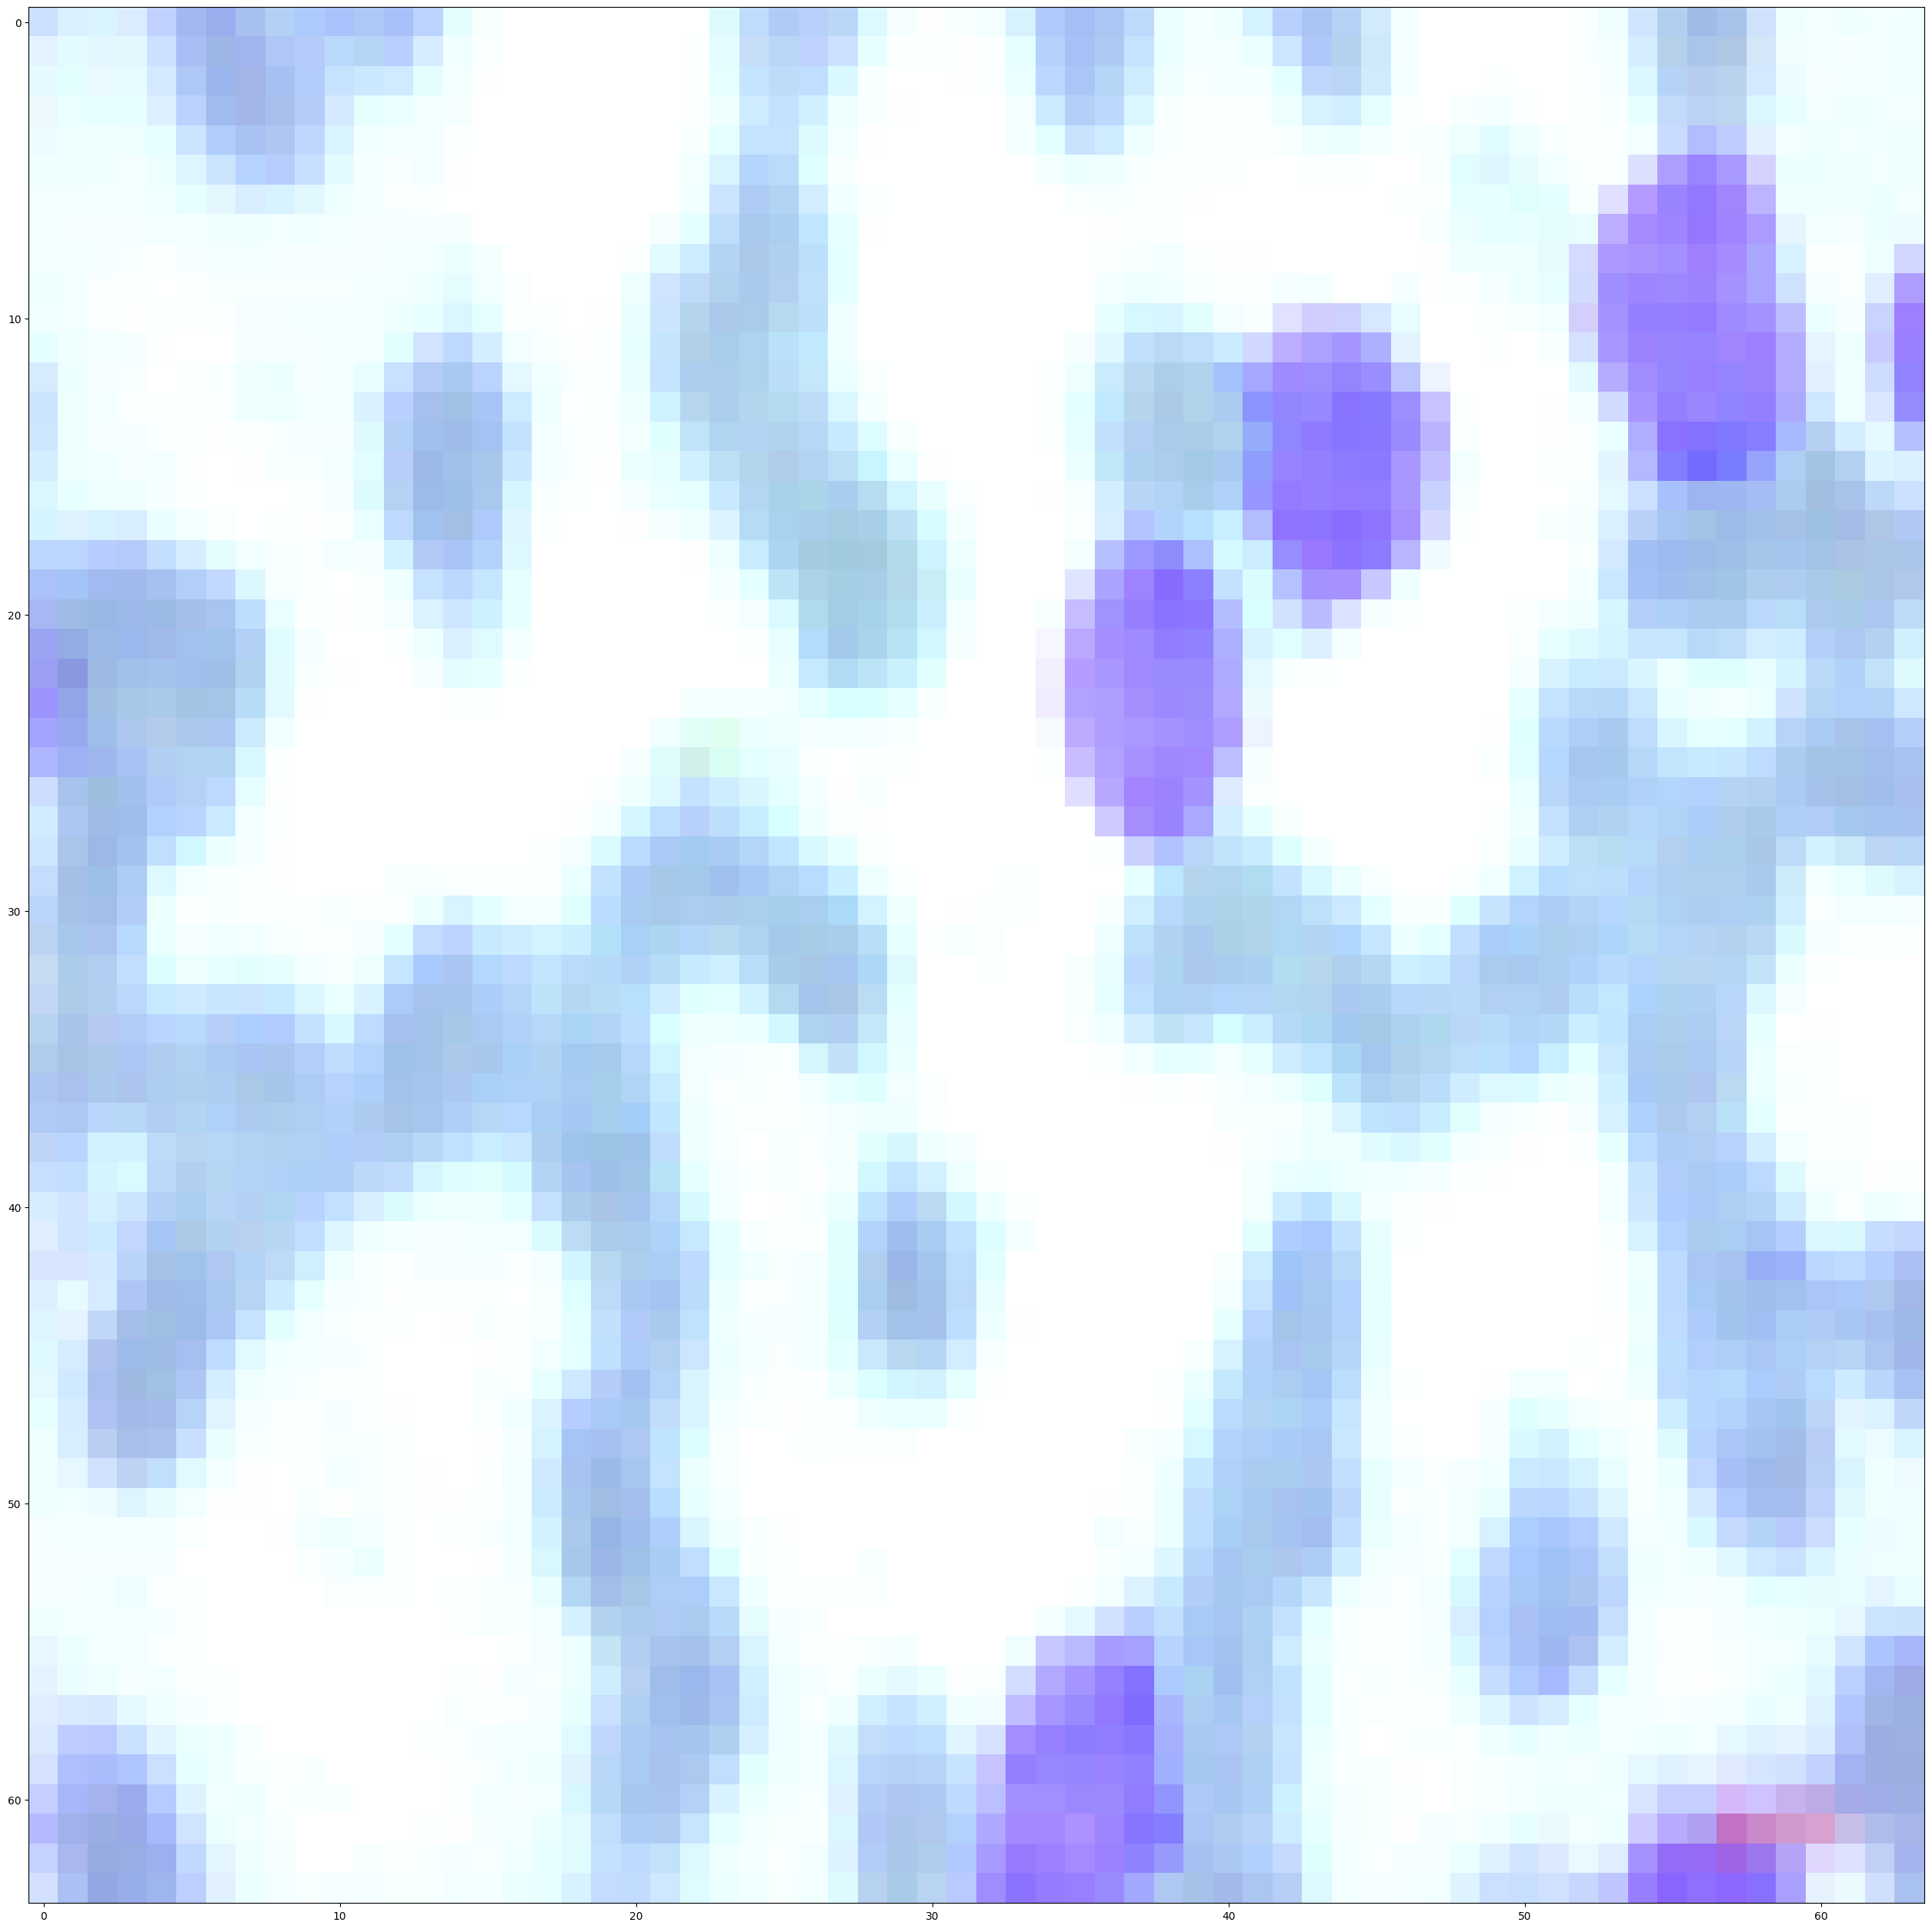

10:15:09 - INFO: Sampling 1 new images....
999it [00:19, 51.27it/s]


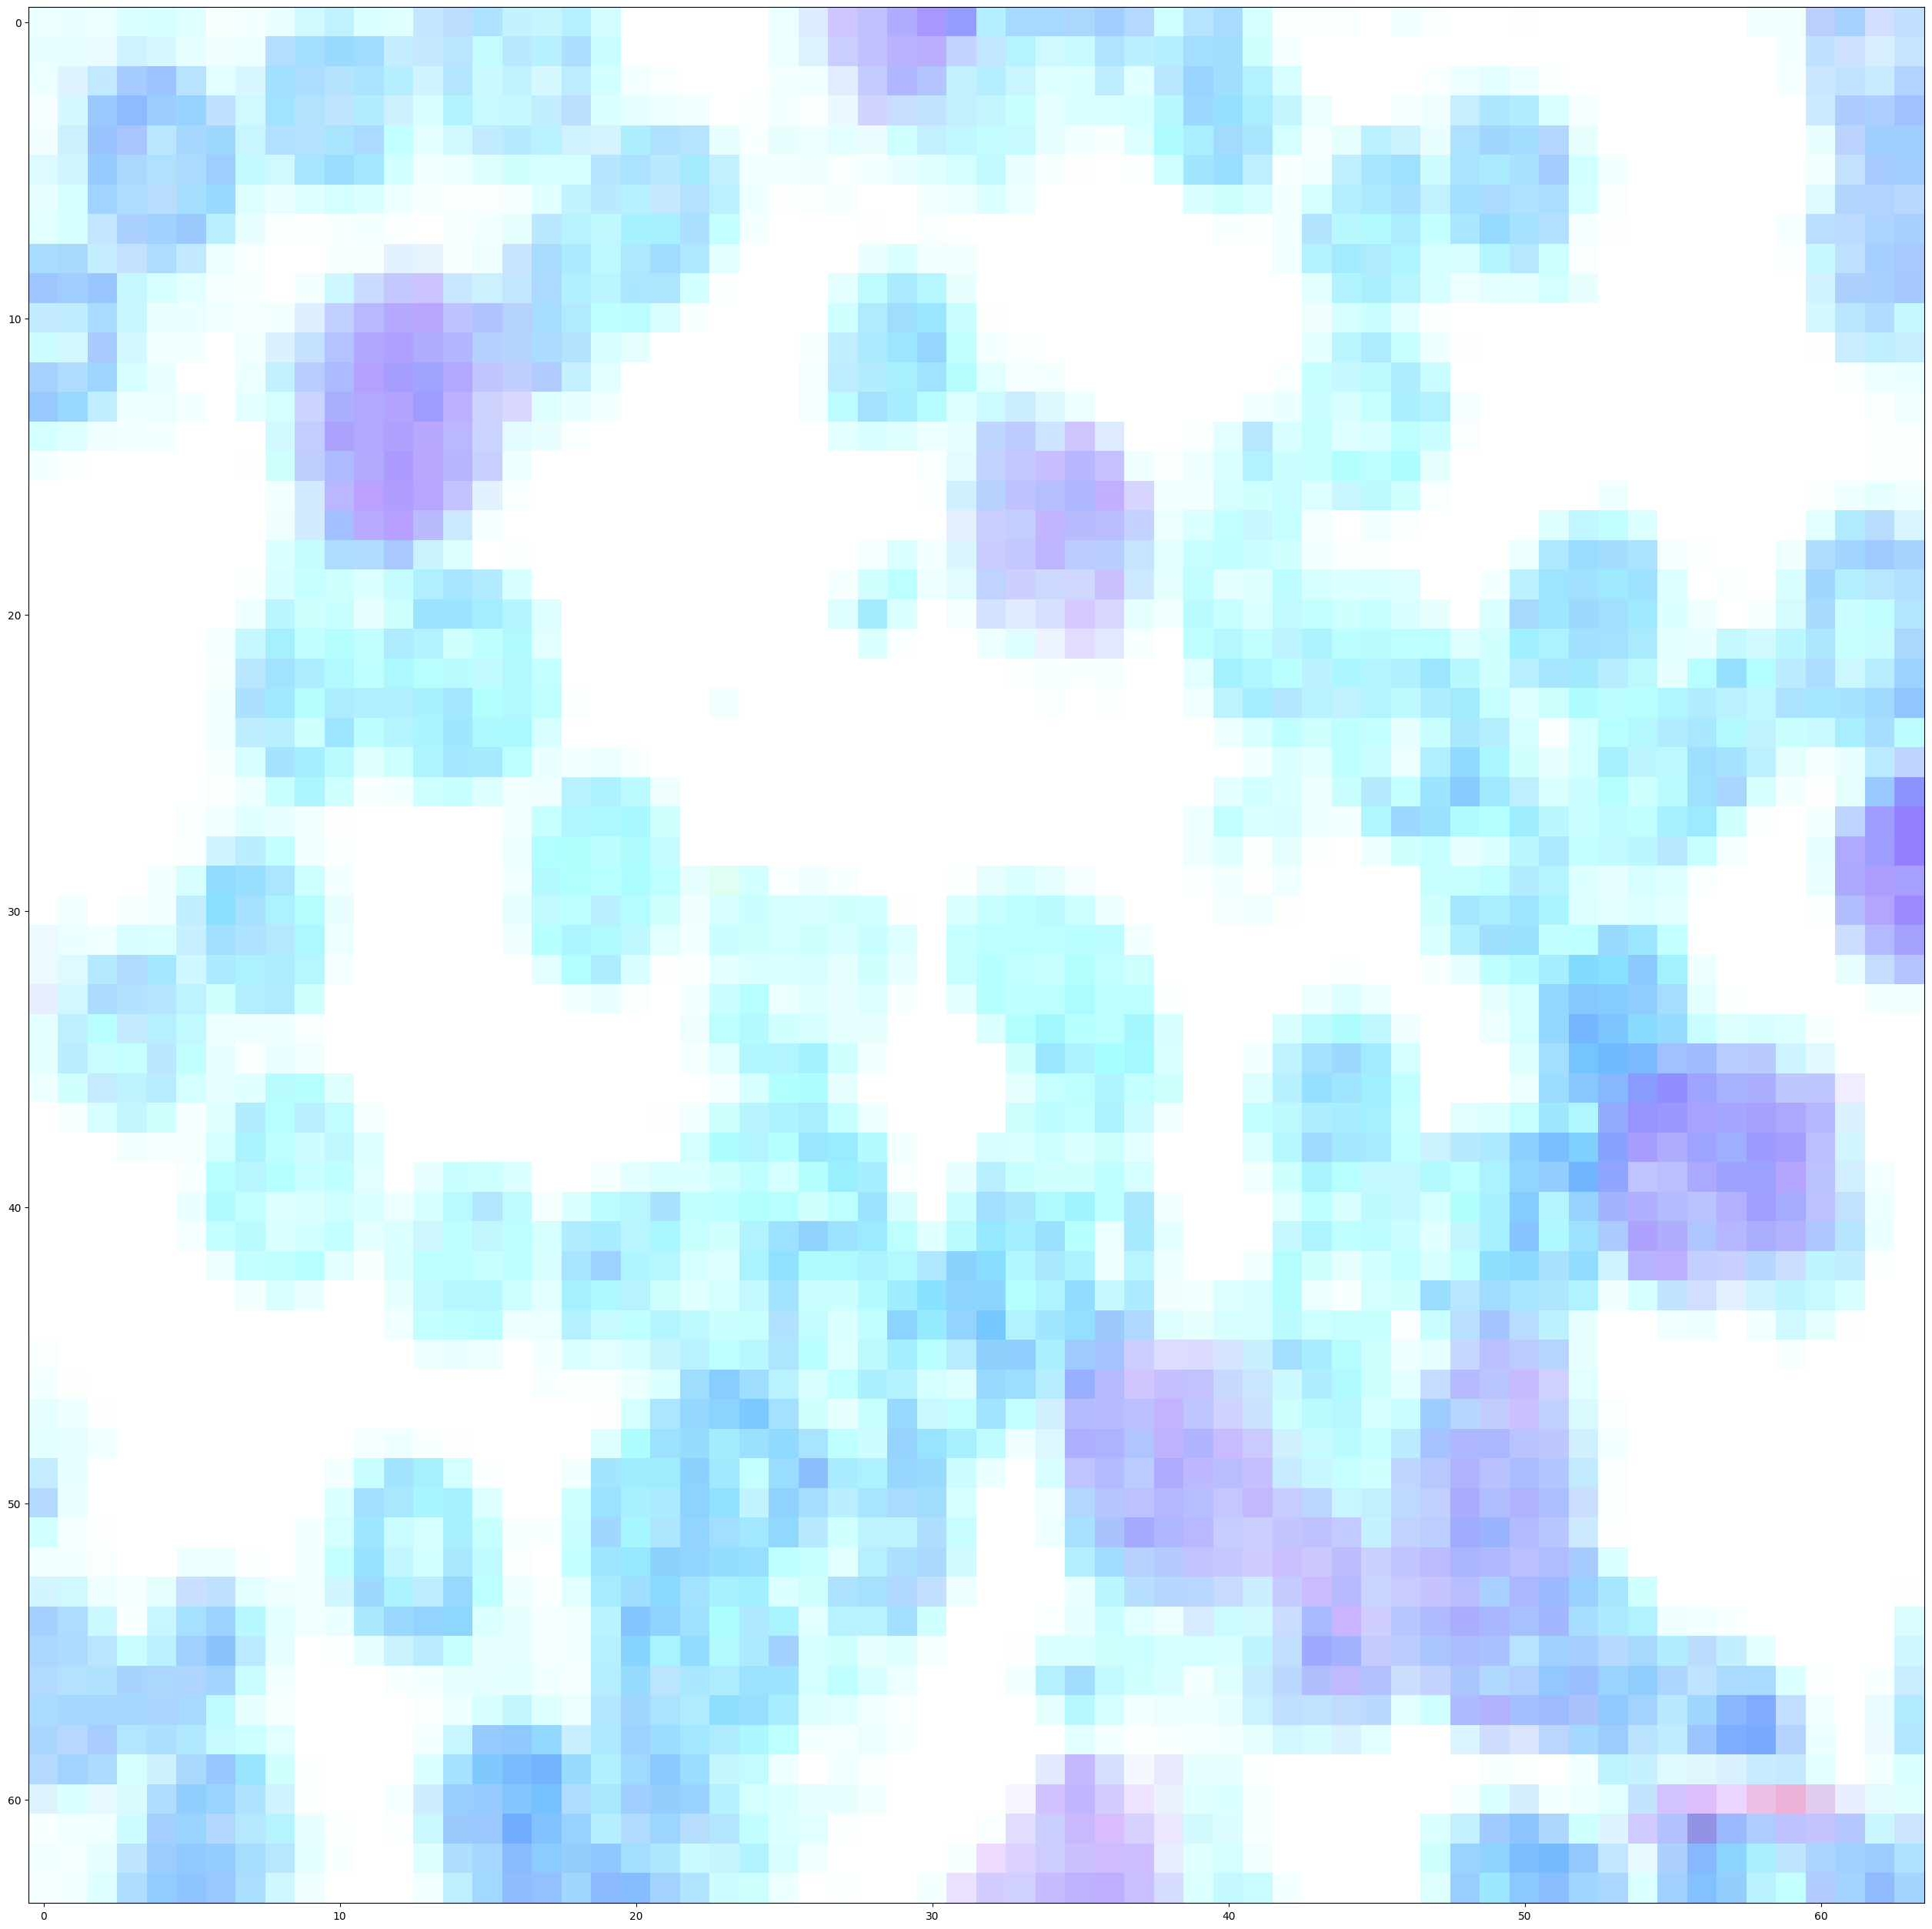

10:15:29 - INFO: Sampling 1 new images....
999it [00:20, 48.63it/s]


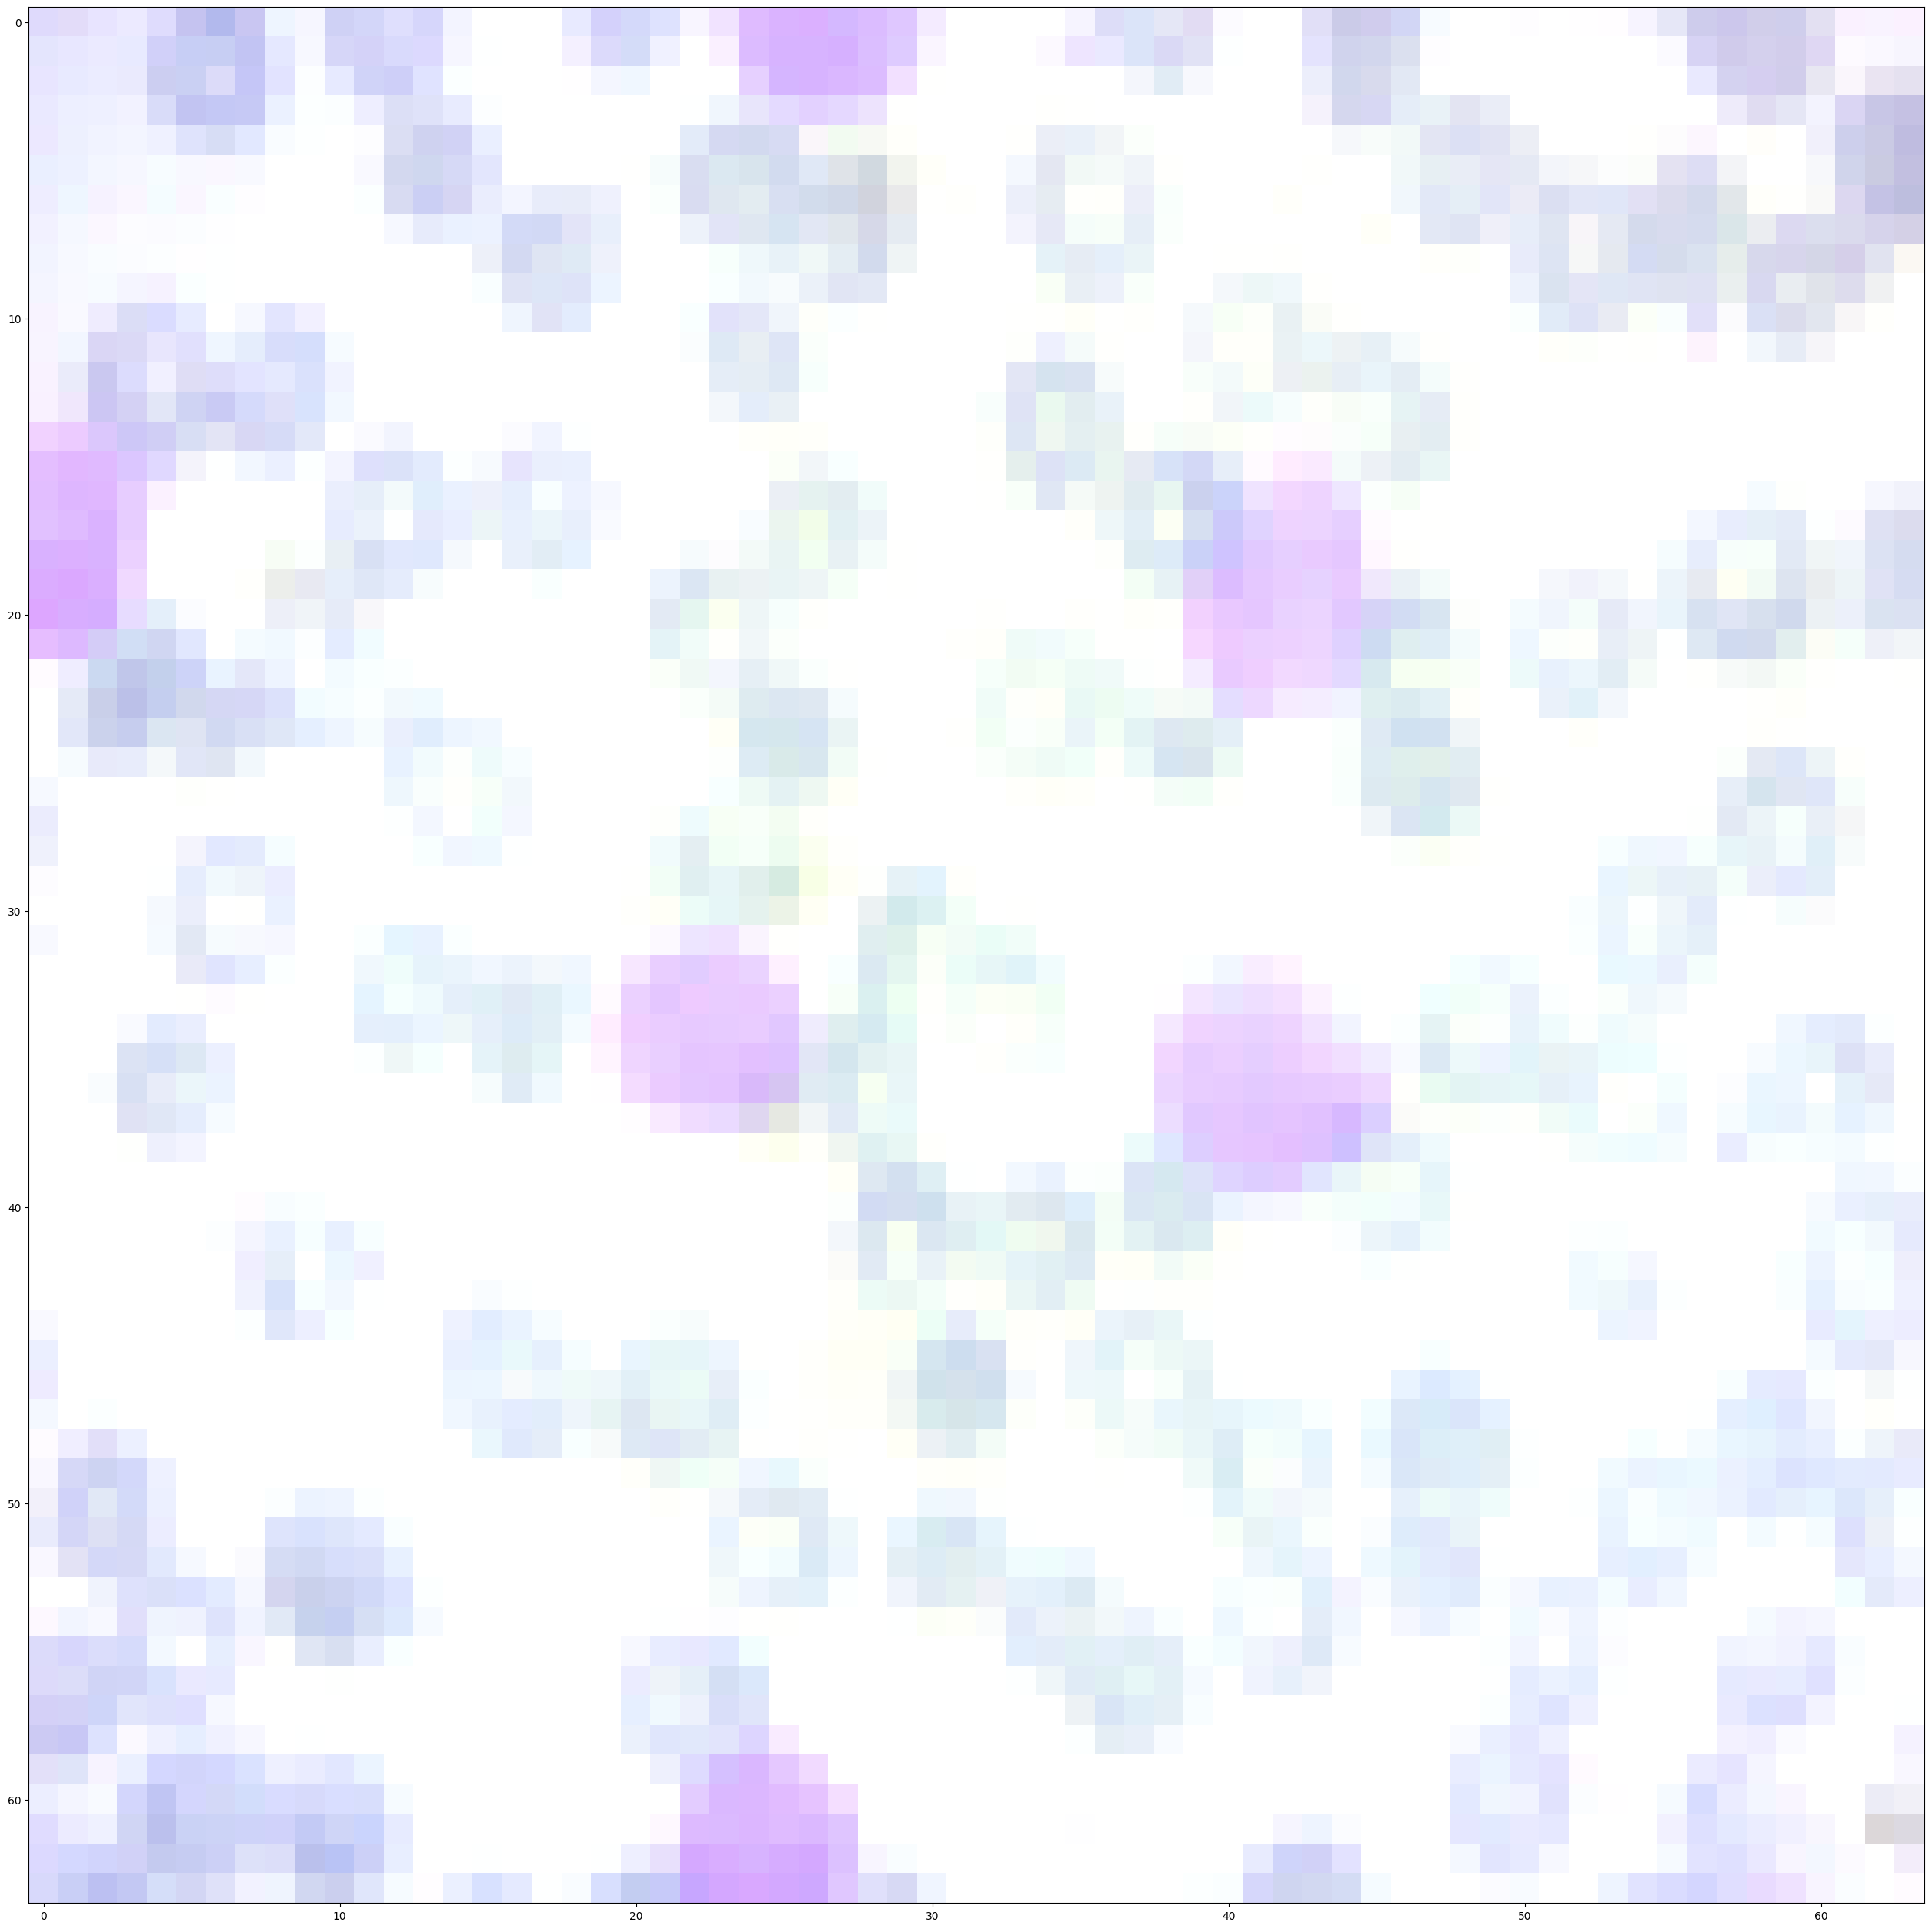

10:15:50 - INFO: Sampling 1 new images....
999it [00:20, 47.77it/s]


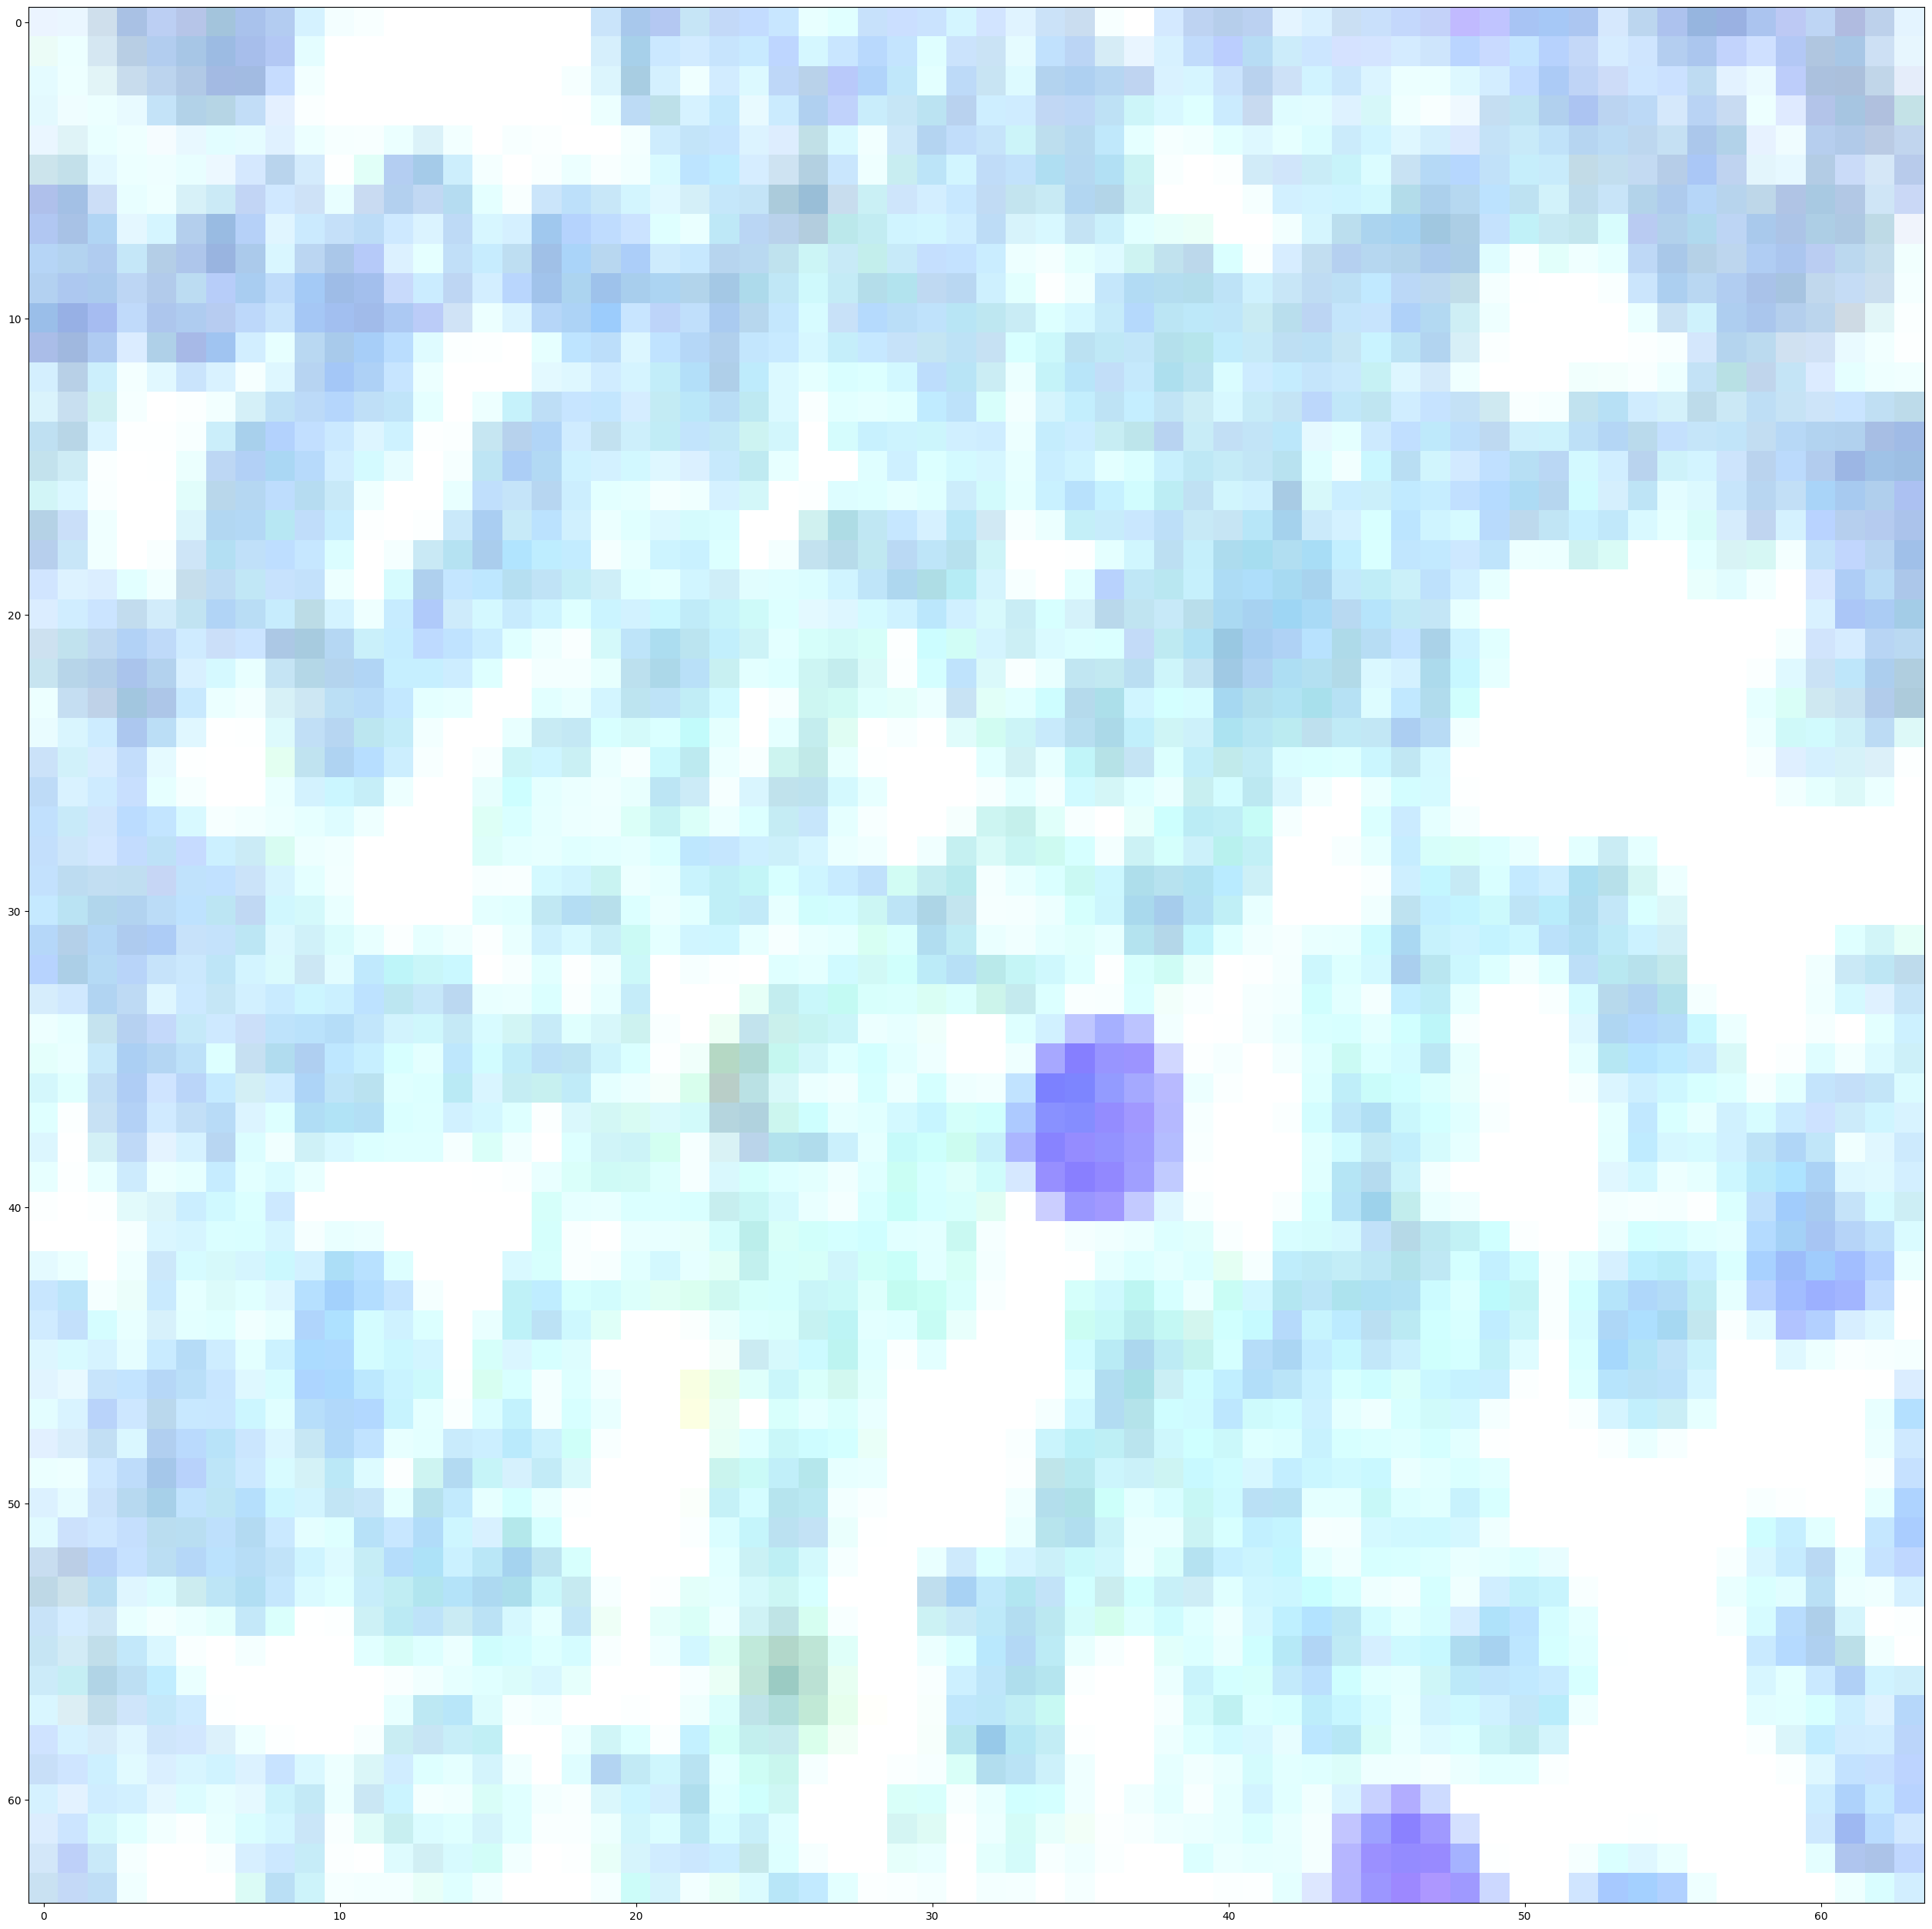

10:16:12 - INFO: Sampling 1 new images....
999it [00:20, 49.19it/s]


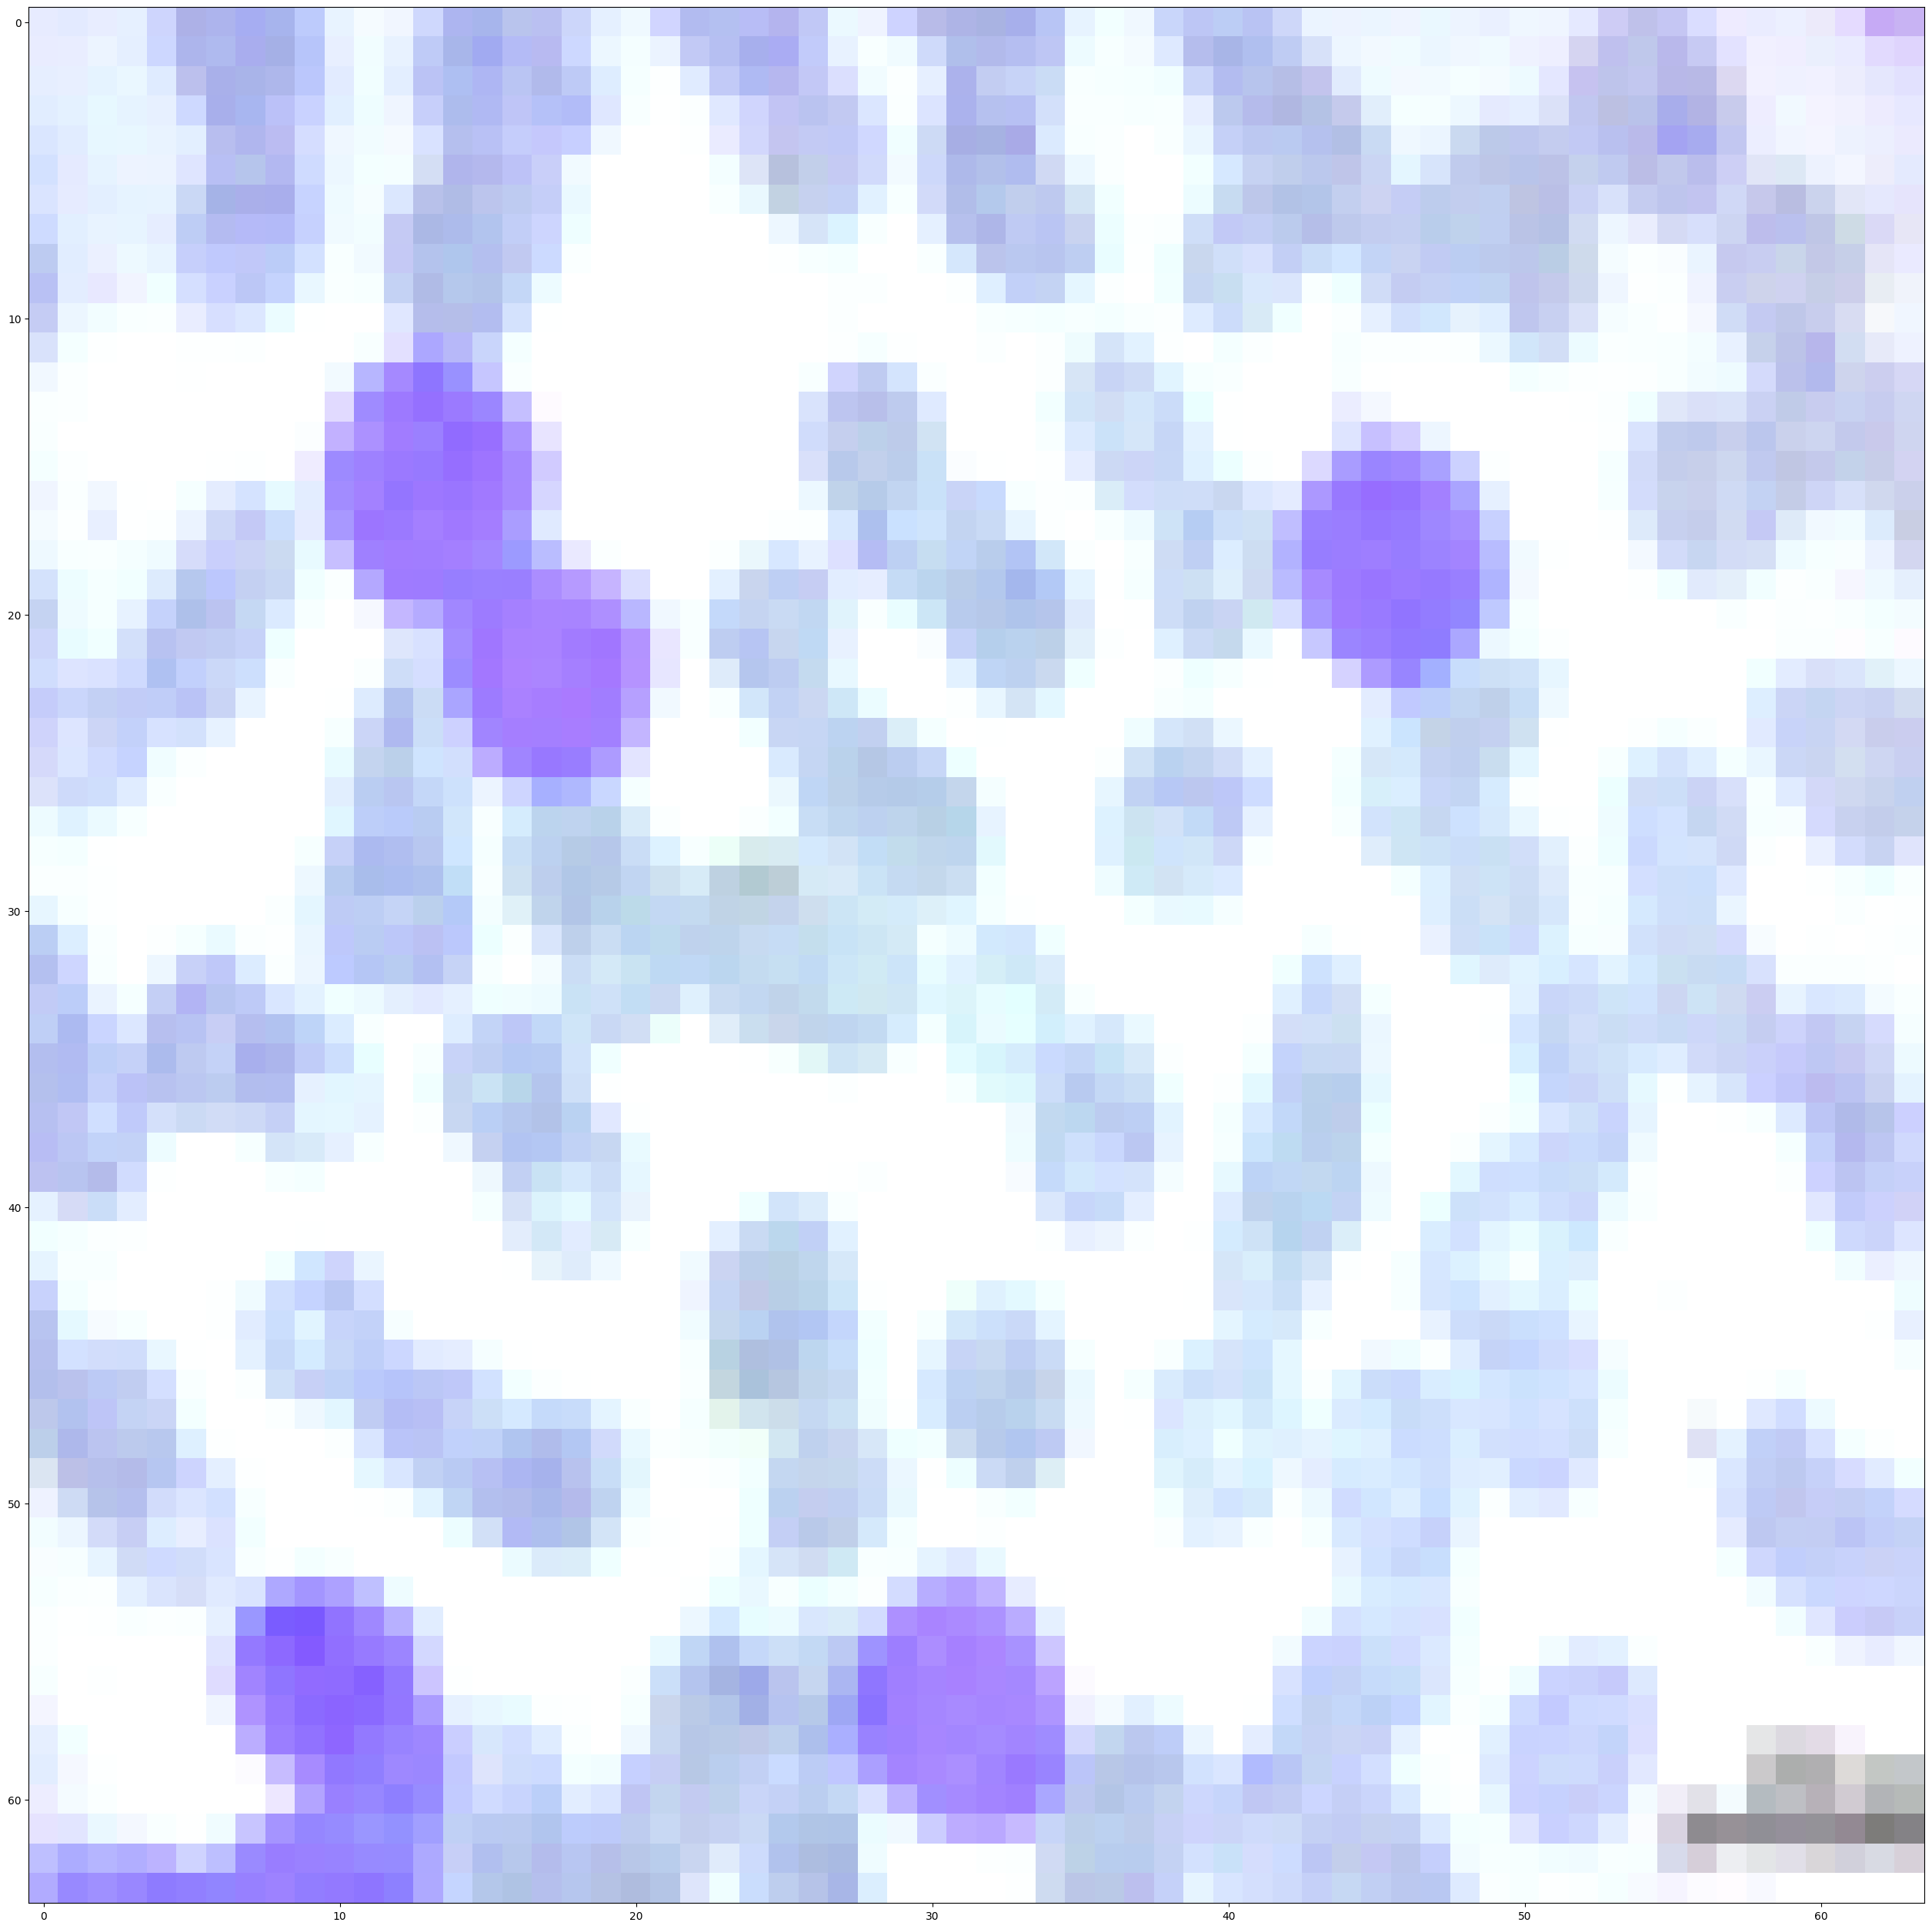

10:16:33 - INFO: Sampling 1 new images....
999it [00:21, 46.76it/s]


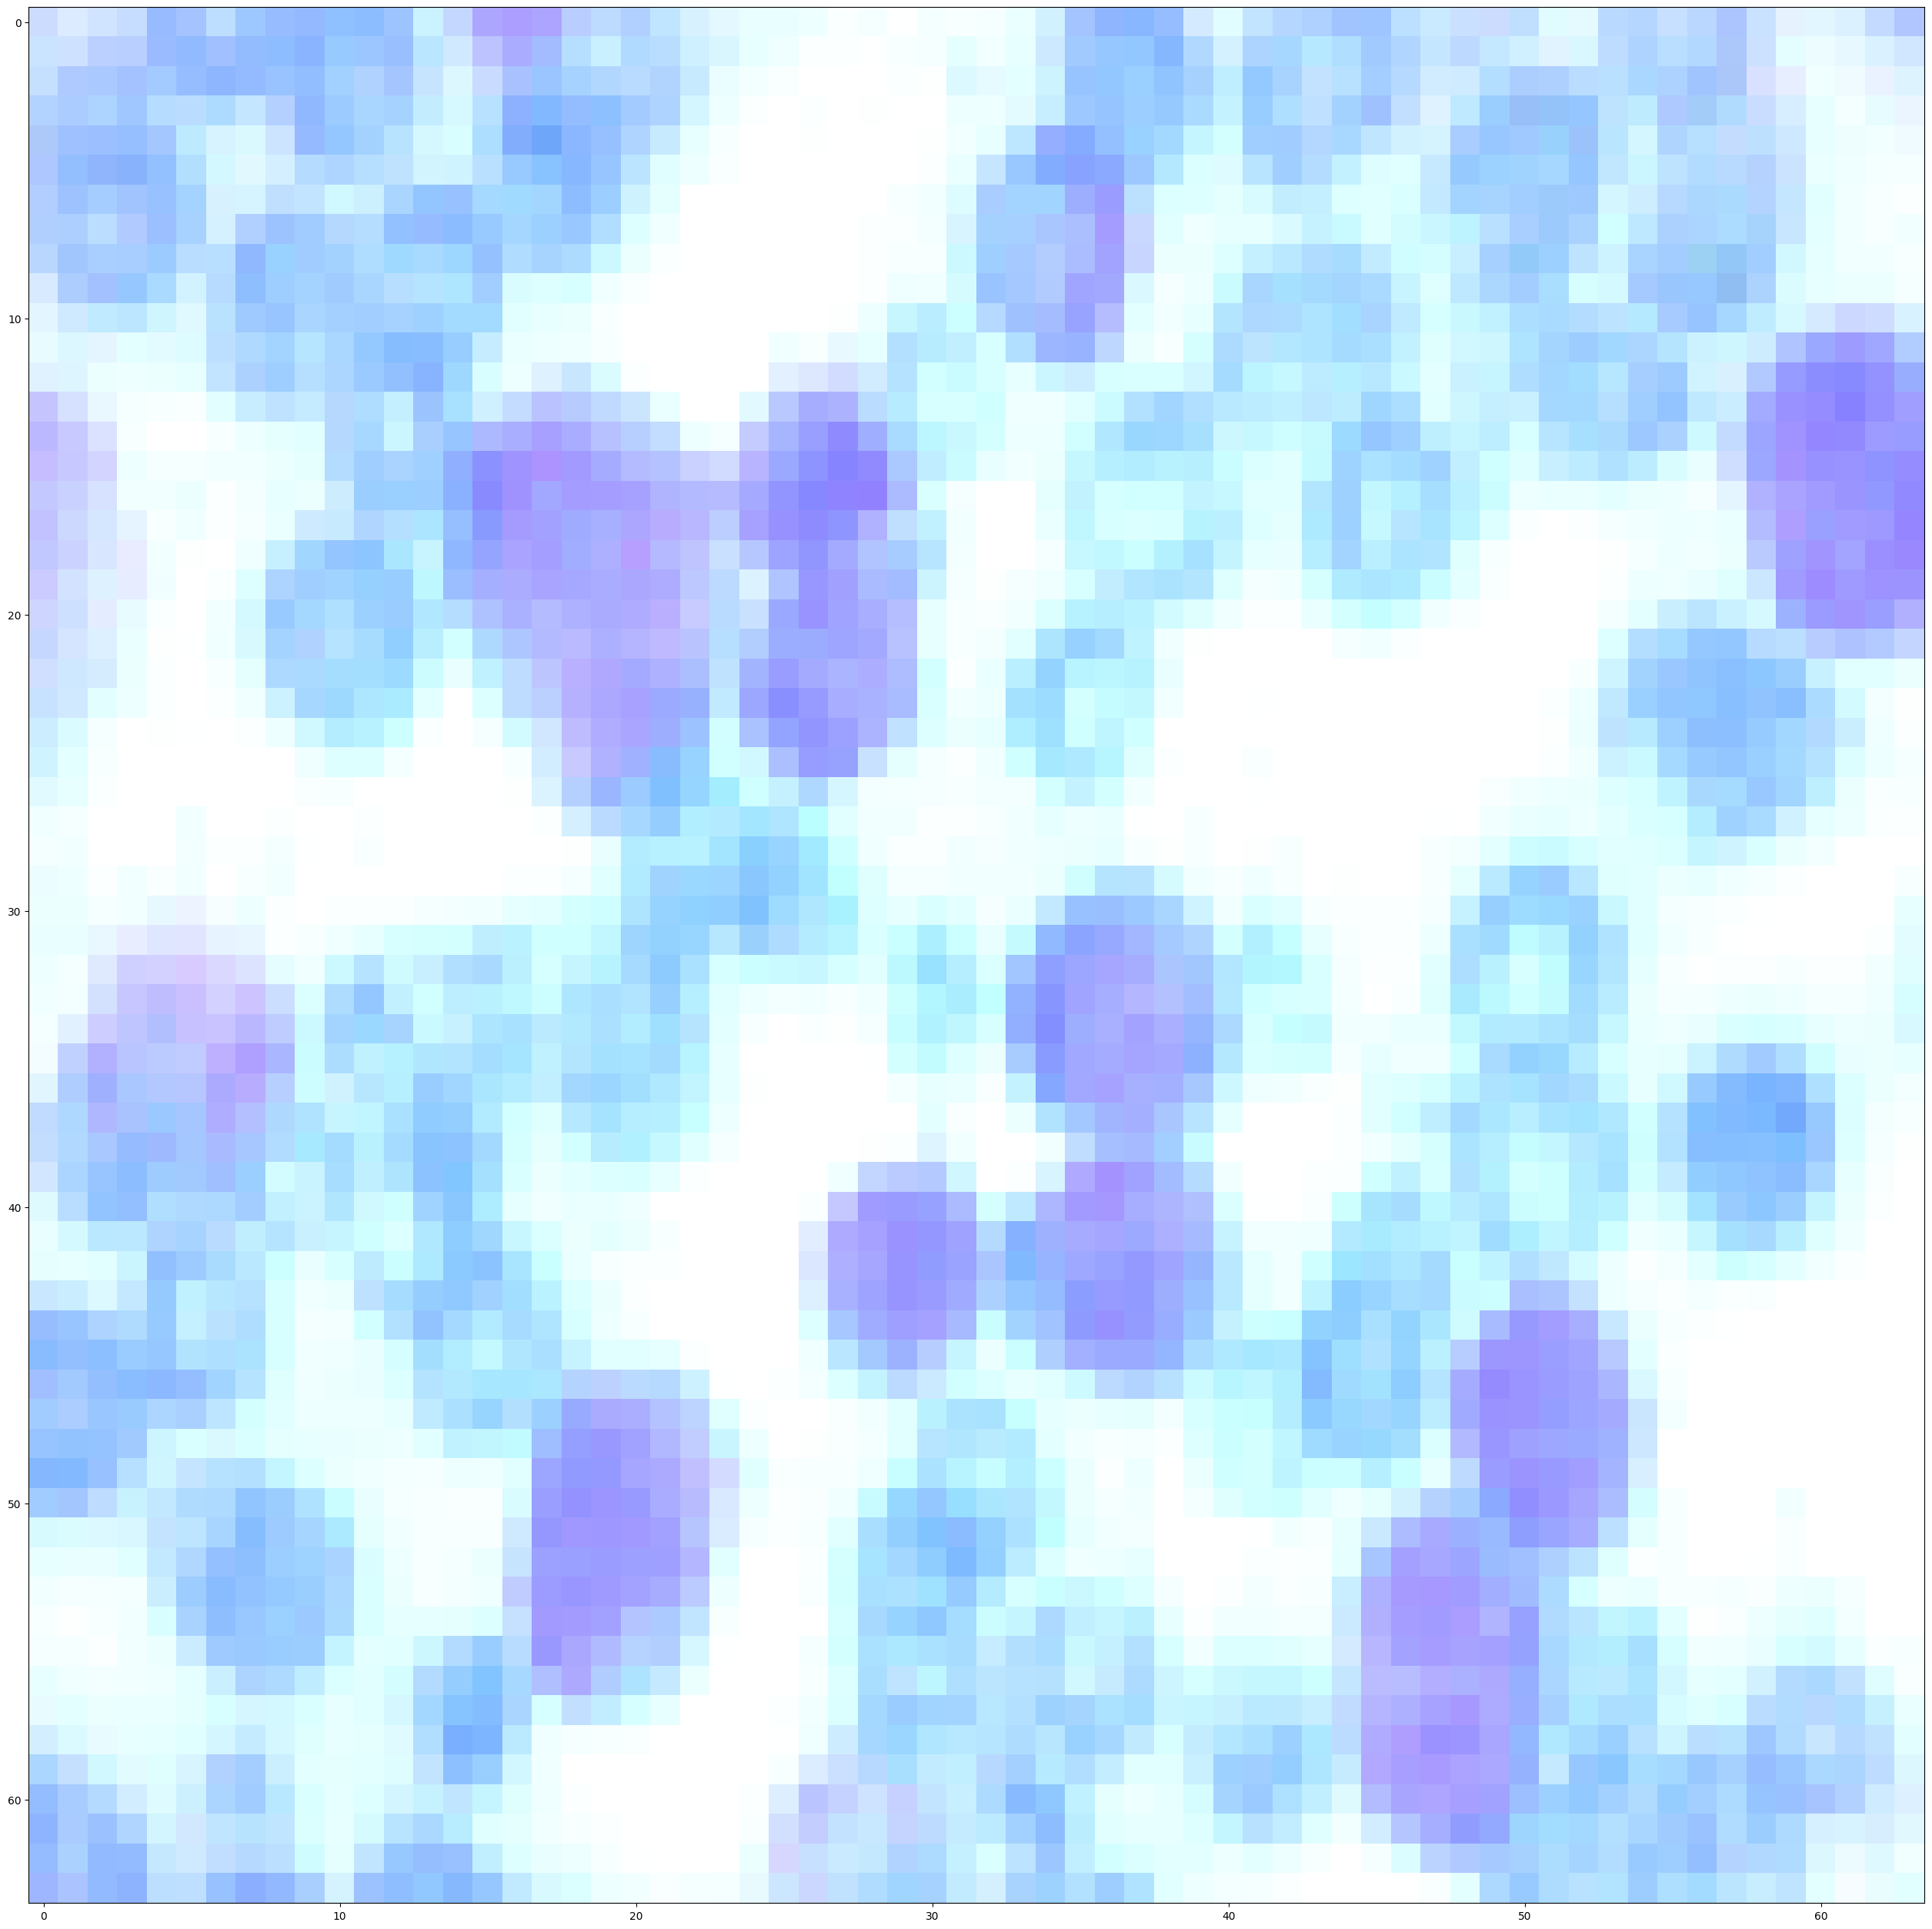

10:16:55 - INFO: Sampling 1 new images....
999it [00:21, 46.69it/s]


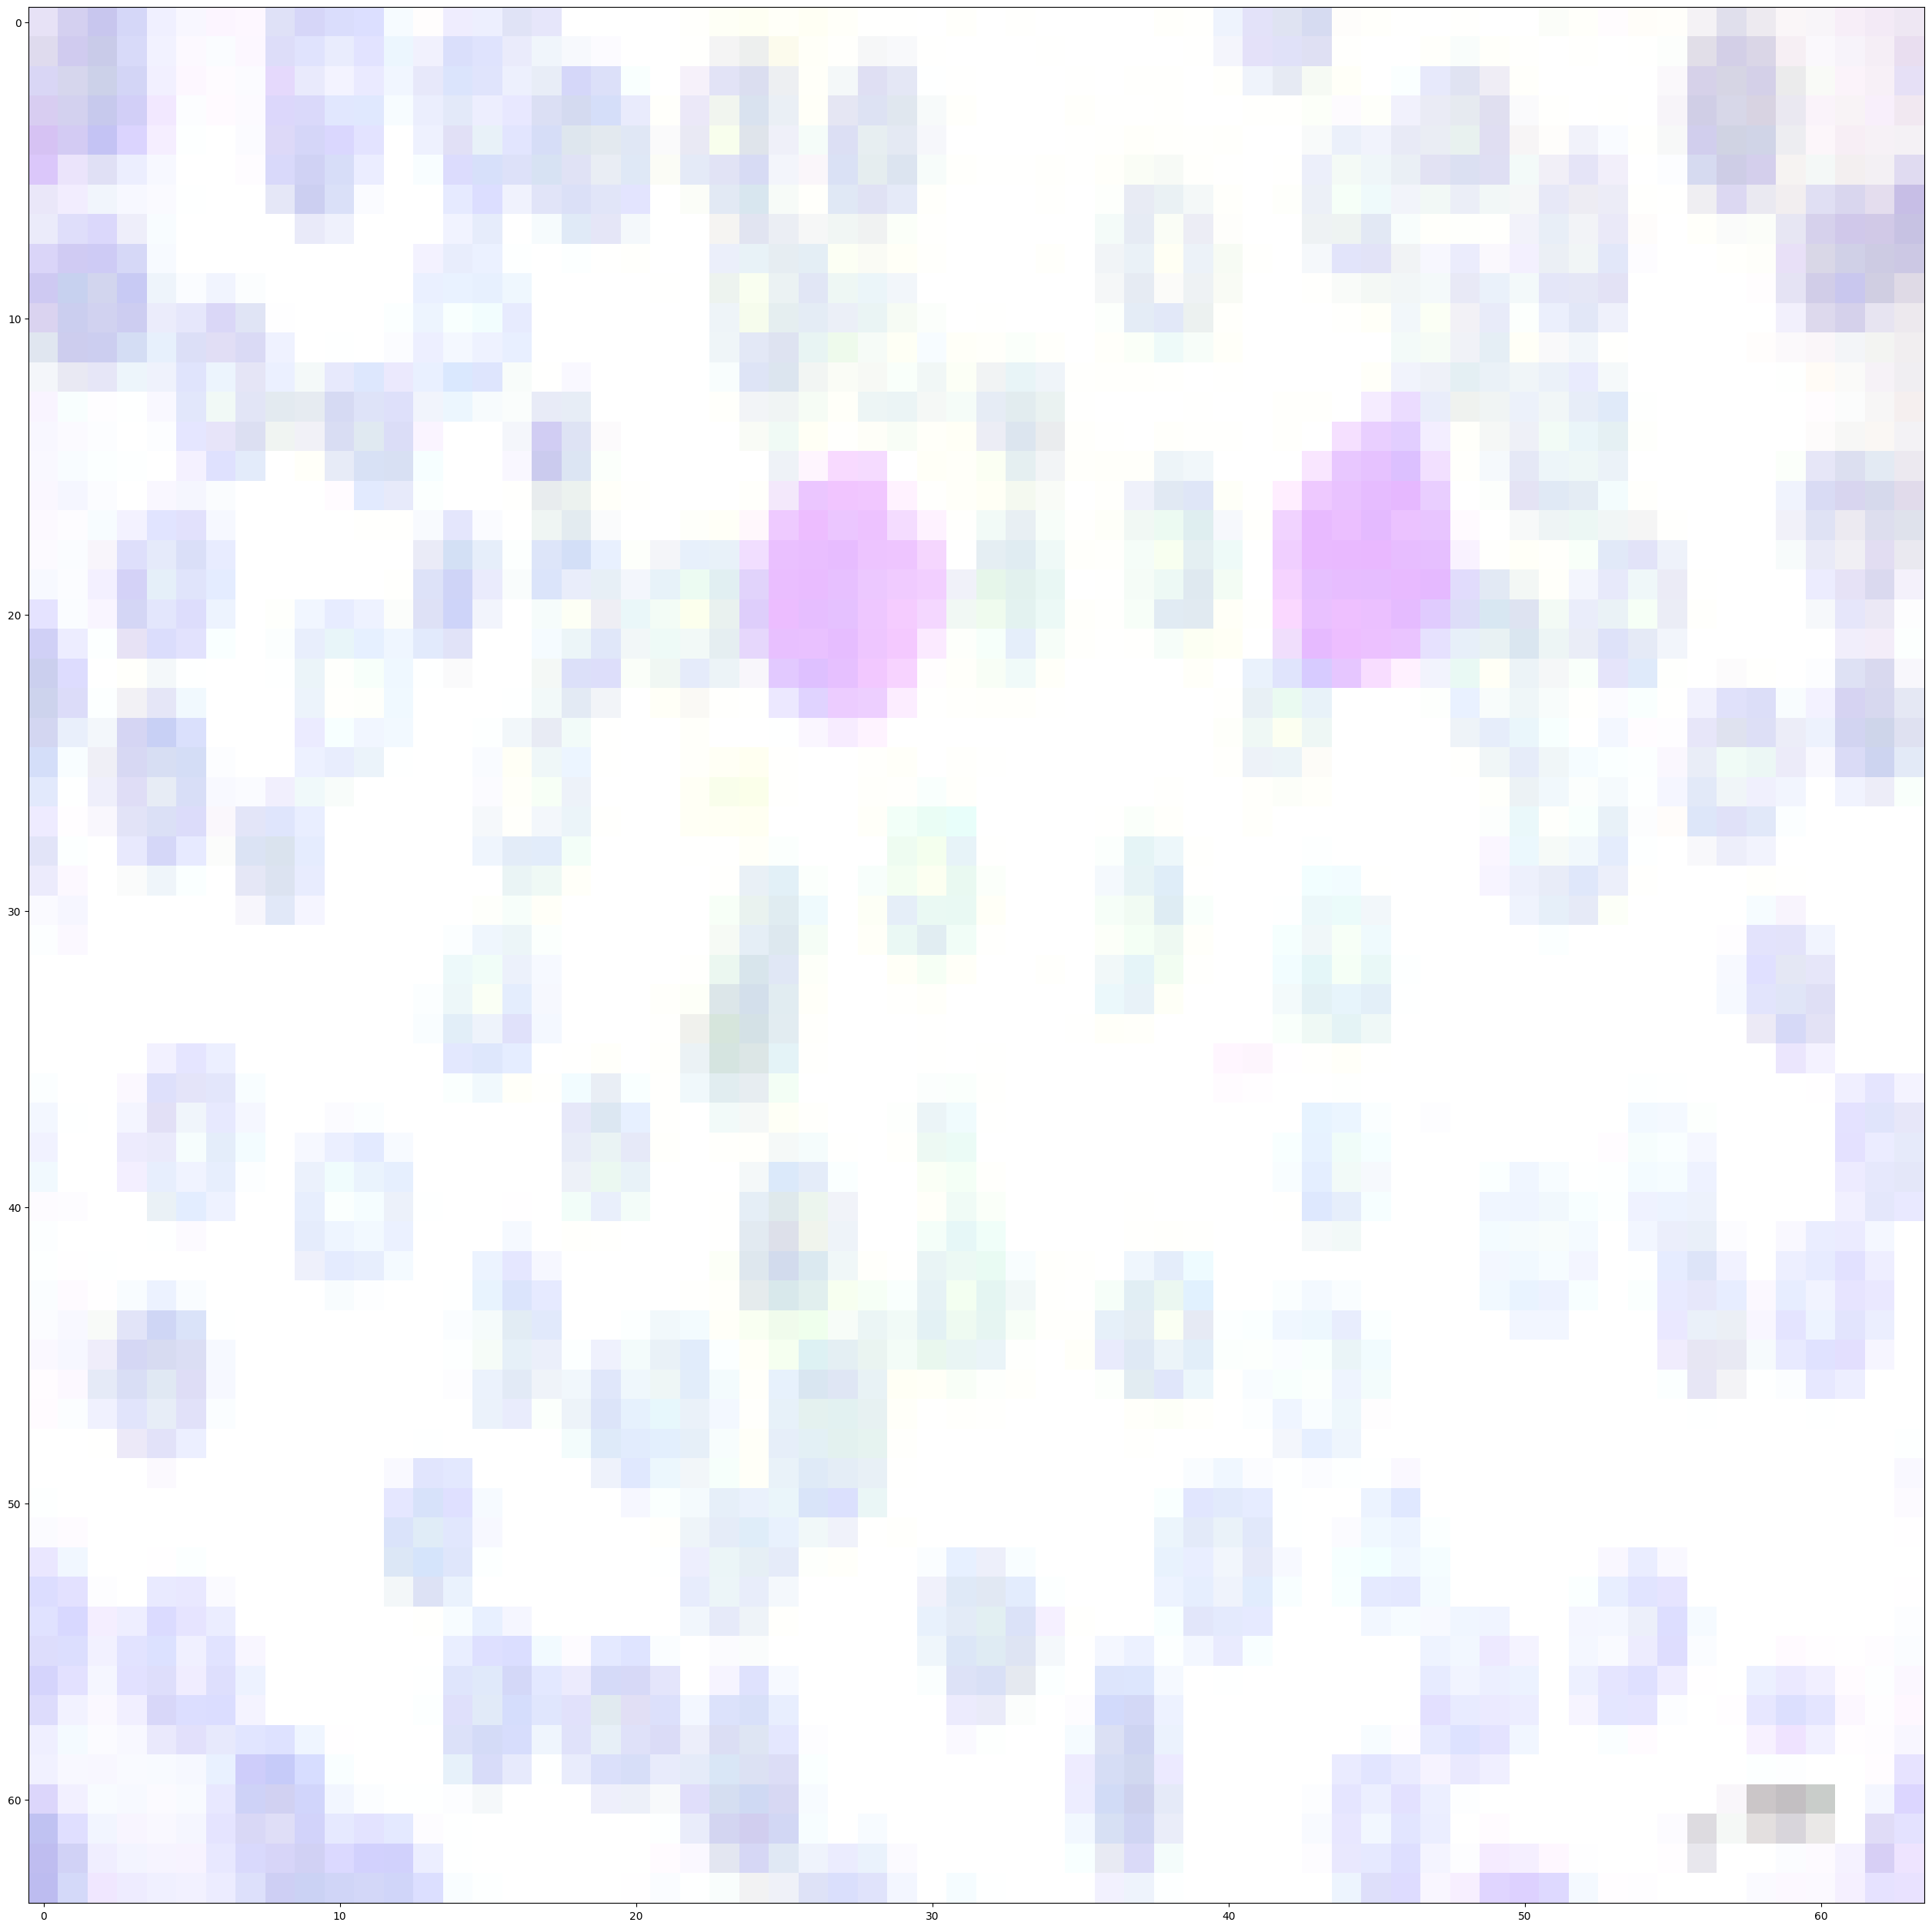

10:17:17 - INFO: Sampling 1 new images....
999it [00:21, 46.92it/s]


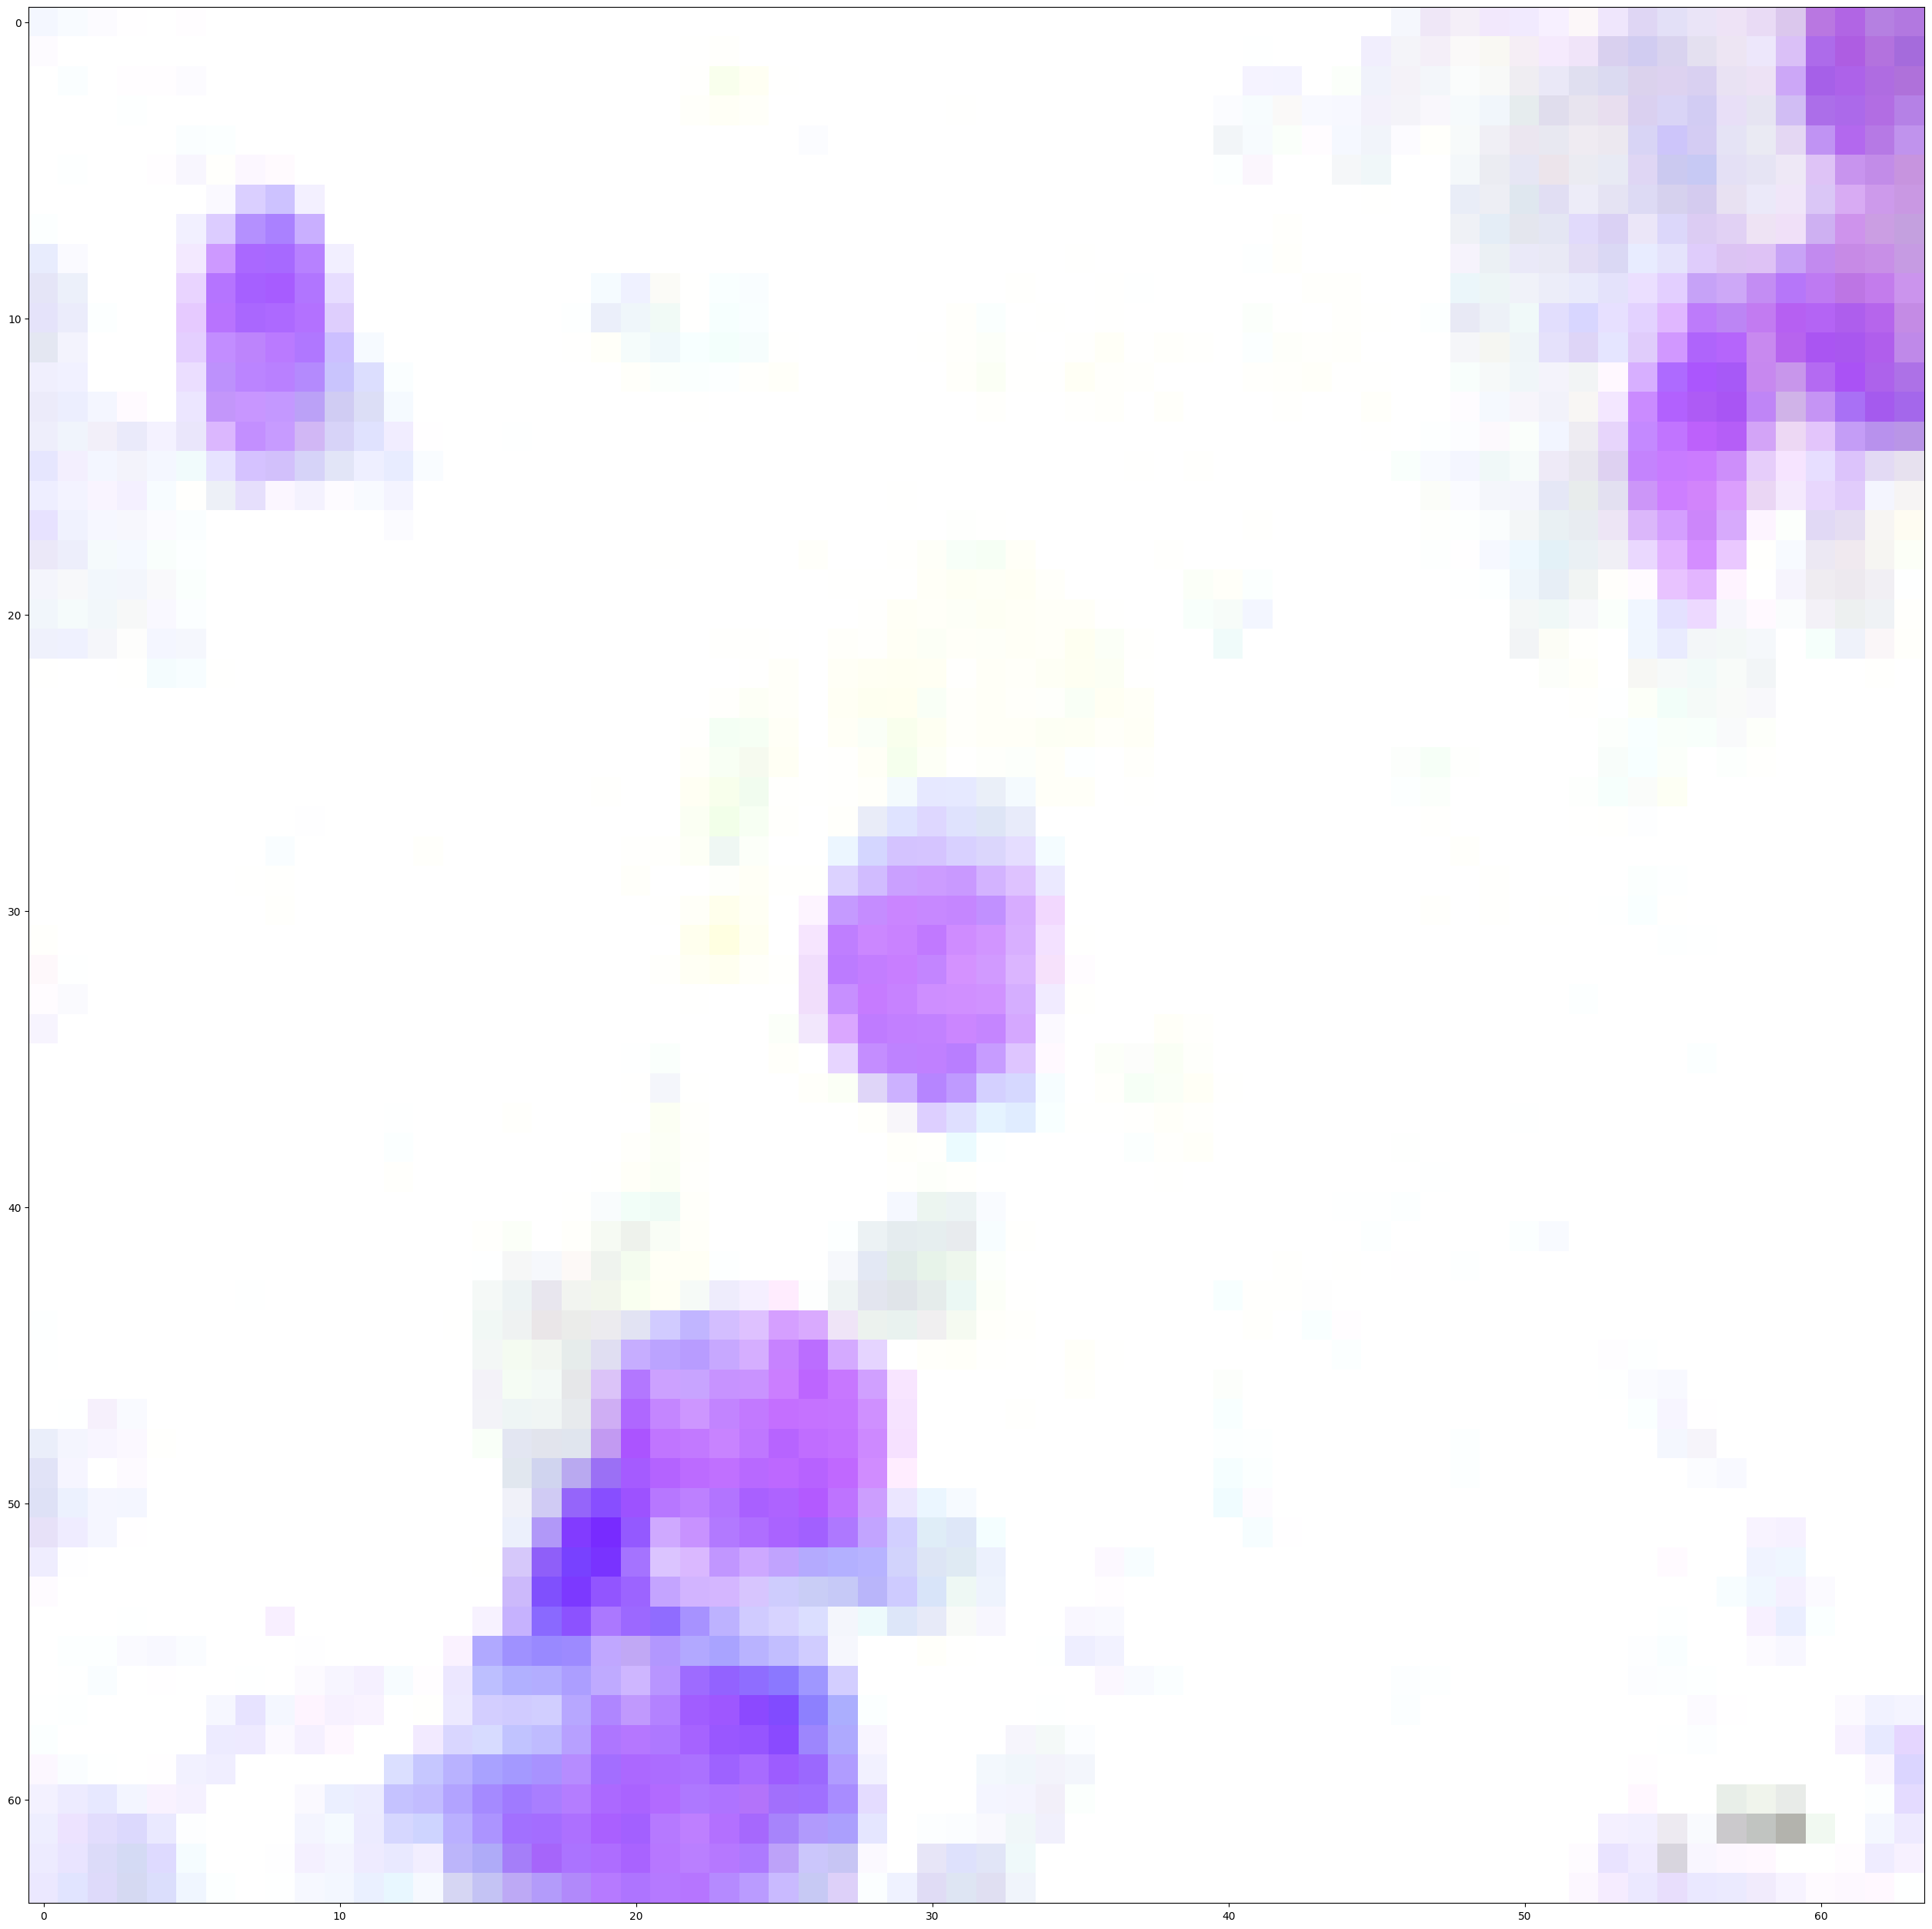

10:17:38 - INFO: Sampling 1 new images....
999it [00:20, 49.65it/s]


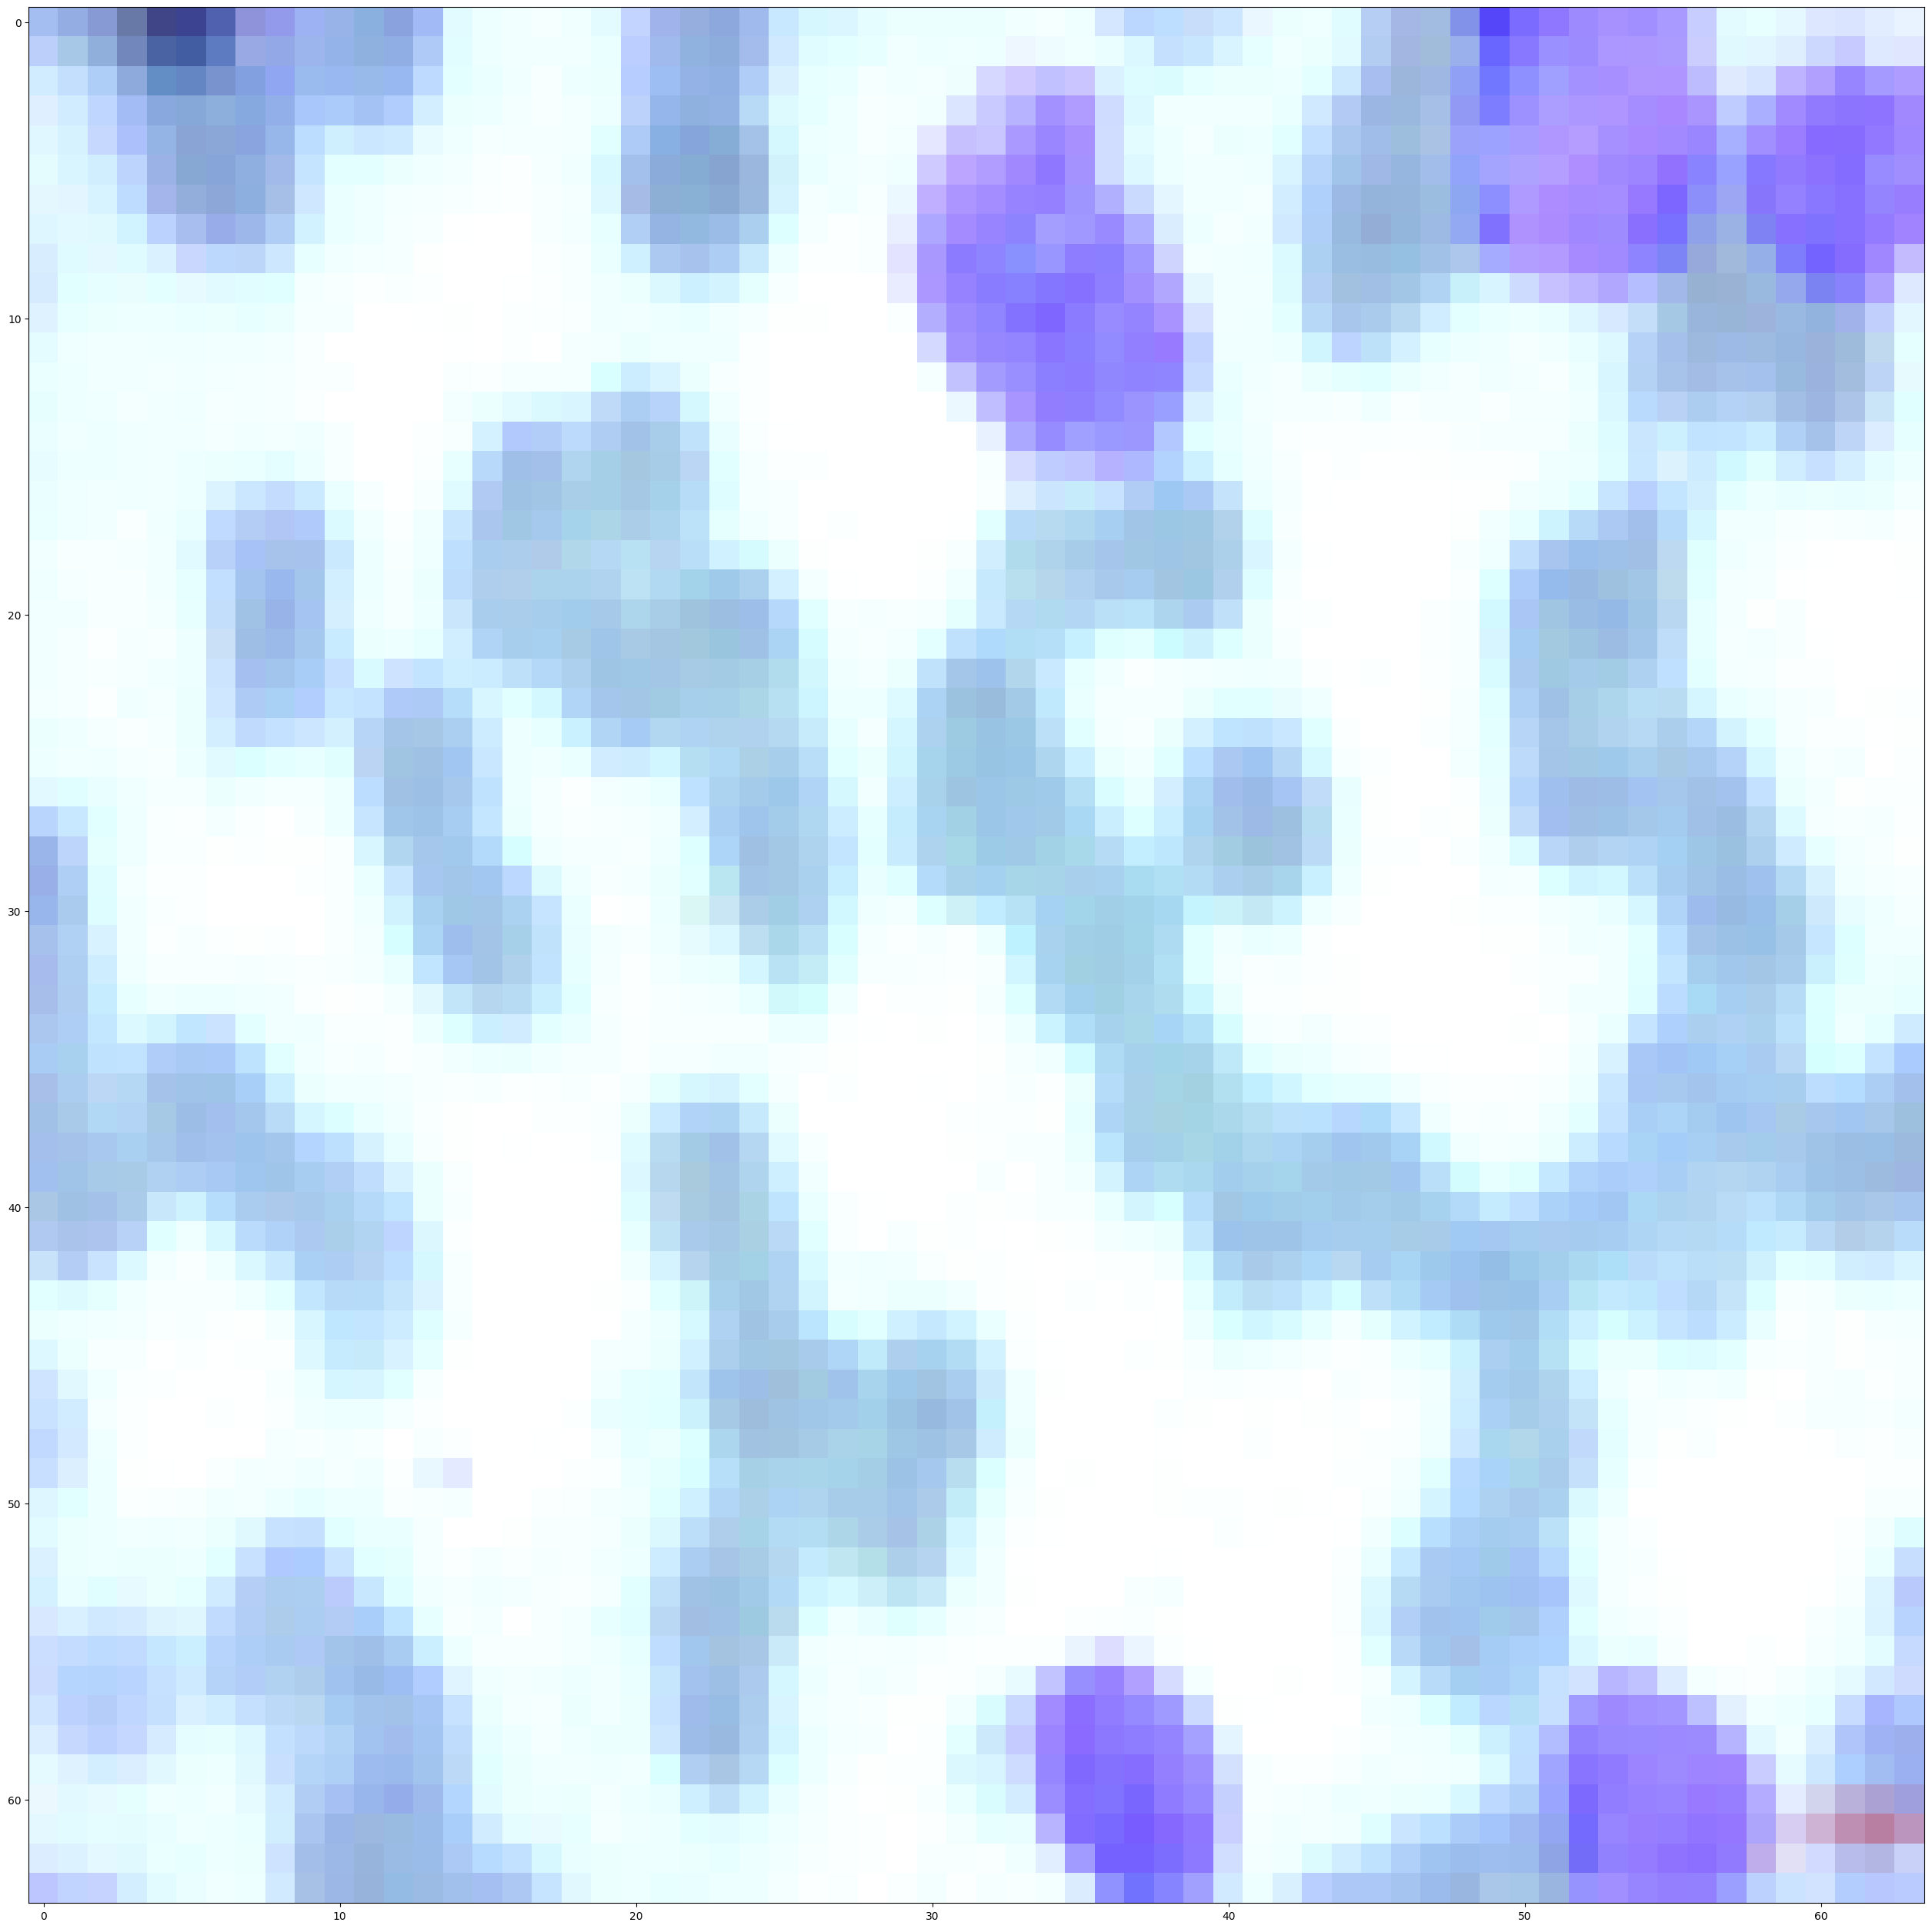

10:17:59 - INFO: Sampling 1 new images....
867it [00:17, 52.11it/s]

In [15]:
for i in range(719,3000):
  labels = torch.tensor([0,1,2,3]).to(args.device)
  model = UNet_conditional(num_classes=args.num_classes).to(args.device)
  model.load_state_dict(torch.load('/data/Ahsan/nomandata/models/DDPM_conditional/all_samp_ckpt.pt'))
  diffusion = Diffusion(img_size=args.image_size, device=args.device)

  sampled_images = diffusion.sample(model, n=1, labels=labels[0])
  plot_images(sampled_images)
  save_images(sampled_images, f"/data/Ahsan/nomandata/all_gen/Benign/{i}.jpg")

  sampled_images = diffusion.sample(model, n=1, labels=labels[1])
  plot_images(sampled_images)
  save_images(sampled_images, f"/data/Ahsan/nomandata/all_gen/Early/{i}.jpg")

  sampled_images = diffusion.sample(model, n=1, labels=labels[2])
  plot_images(sampled_images)
  save_images(sampled_images, f"/data/Ahsan/nomandata/all_gen/Pre/{i}.jpg")

  sampled_images = diffusion.sample(model, n=1, labels=labels[3])
  plot_images(sampled_images)
  save_images(sampled_images, f"/data/Ahsan/nomandata/all_gen/Pro/{i}.jpg")